<a href="https://colab.research.google.com/github/globalfinancialinsights/Macrofinancial-dashboard/blob/main/USA_Macro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Preliminary Work

<p style="color:red;">N.B.: The IMF WEO dataset has to be updated twice each year (in April and October), while the EBA assessment framework (Section 10) once a year!!</p>

In [ ]:
!pip install quandl

In [ ]:
!jupyter notebook restart

[C 02:47:59.434 NotebookApp] No such file or directory: /content/restart


In [ ]:
!pip install dbnomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.8 MB/s eta 0:00:00


In [ ]:
import dbnomics

In [ ]:
pip install fredapi

In [ ]:
pip install investpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 11.6 MB/s eta 0:00:00
  Created wheel for investpy: filename=investpy-1.0.8-py3-none-any.whl size=4481566 sha256=23d299667c363dd365f0d8405099eca2a6494b18bd1e696f5aada2c6b4487916
  Stored in directory: /root/.cache/pip/wheels/db/f4/ae/980b93b0257620bc8e4afc98a854a7a746a33eb8335fd07906
Successfully built investpy


In [ ]:
!pip install rise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.0 MB/s eta 0:00:00


In [ ]:
import rise

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-bright')
from dbnomics import fetch_series
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import quandl

from fredapi import Fred
import yfinance as yf

import scipy
from bs4 import BeautifulSoup
import requests
import ipywidgets as widgets
import plotly.express as px
import investpy
import datetime as dt
import rise

In [ ]:
#Time window for annual analysis
start='1995-01-01' #Start date for several analysis
today = '2024-01-01' #IMPORTANT: it is the last complete full year
current_quarter = '2024-01-01' #Beginning of current quarter
current_month = '2024-01-01'   #Beginning of current month
fd = '01/01/2018' #Date from when fetching economic calendar data
td = dt.datetime.today().strftime("%d/%m/%Y") #Today
country = 'united states'

In [ ]:
#Fetch economic calendar of the country
eco_cal = investpy.news.economic_calendar(countries=[country], from_date=fd, to_date=td)

In [ ]:
#Define a function to clean data fetched from DBnomics
def clean_data(data, name):
    data = data[['period', 'value']]
    data = data.set_index('period')
    data = data.loc[start:]
    data = data.rename(columns={'value': name})

    return(data)

In [ ]:
#Define a function to filter specific percentage data from the economic calendar and convert it to float
def eco_cal_data_pct(event):

    df = eco_cal[eco_cal['event'].str.startswith(event)]
    df = df[['date', 'actual']]
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['actual'] = list(map(lambda x: x[:-1], df['actual'].values))
    df['actual'] = [float(x) for x in df['actual'].values]
    df = df.rename(columns={'actual':event})

    return(df)

In [ ]:
#Define a function to filter specific data from the economic calendar and convert it to int
def eco_cal_data_int(event):

    df = eco_cal[eco_cal['event'].str.startswith(event)]
    df = df[['date', 'actual']]
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index, dayfirst=True)
    df['actual'] = list(map(lambda x: x[:-1], df['actual'].values))
    df['actual'] = [int(x.replace(',',"").strip()) for x in df['actual'].values]
    df = df.rename(columns={'actual':event})

    return(df)

# Section 1: Supply and Productivity

In this section we are going to analyze the total factor productivity and labor supply of the U.S. Our goal is to understand if the so-called "A" factor in the Cobb-Douglas function (Y = A * K^a * L^(1-a)) is positive (meaning that structural reforms, technological progress and policies are contributing positively to the long-term productivity of the country) or not. We will also look at the unemployment level compared to its natural rate and estimate the potential level of labor (L*).

In [ ]:
#Fetch data for Total Factor Productivity
tfp = fetch_series('AMECO/ZVGDF/USA.3.0.0.0.ZVGDF')
tfp = clean_data(tfp, 'TFP')

#Fetch data for Capital share in TFP
cap_share = fetch_series('AMECO/ZVGDK/USA.3.0.0.0.ZVGDK')
cap_share = clean_data(cap_share, 'Capital Share in TFP')

#Fetch data for Labor share in TFP
lab_share = fetch_series('AMECO/ZVGDE/USA.3.0.0.0.ZVGDE')
lab_share = clean_data(lab_share, 'Labor Share in TFP')

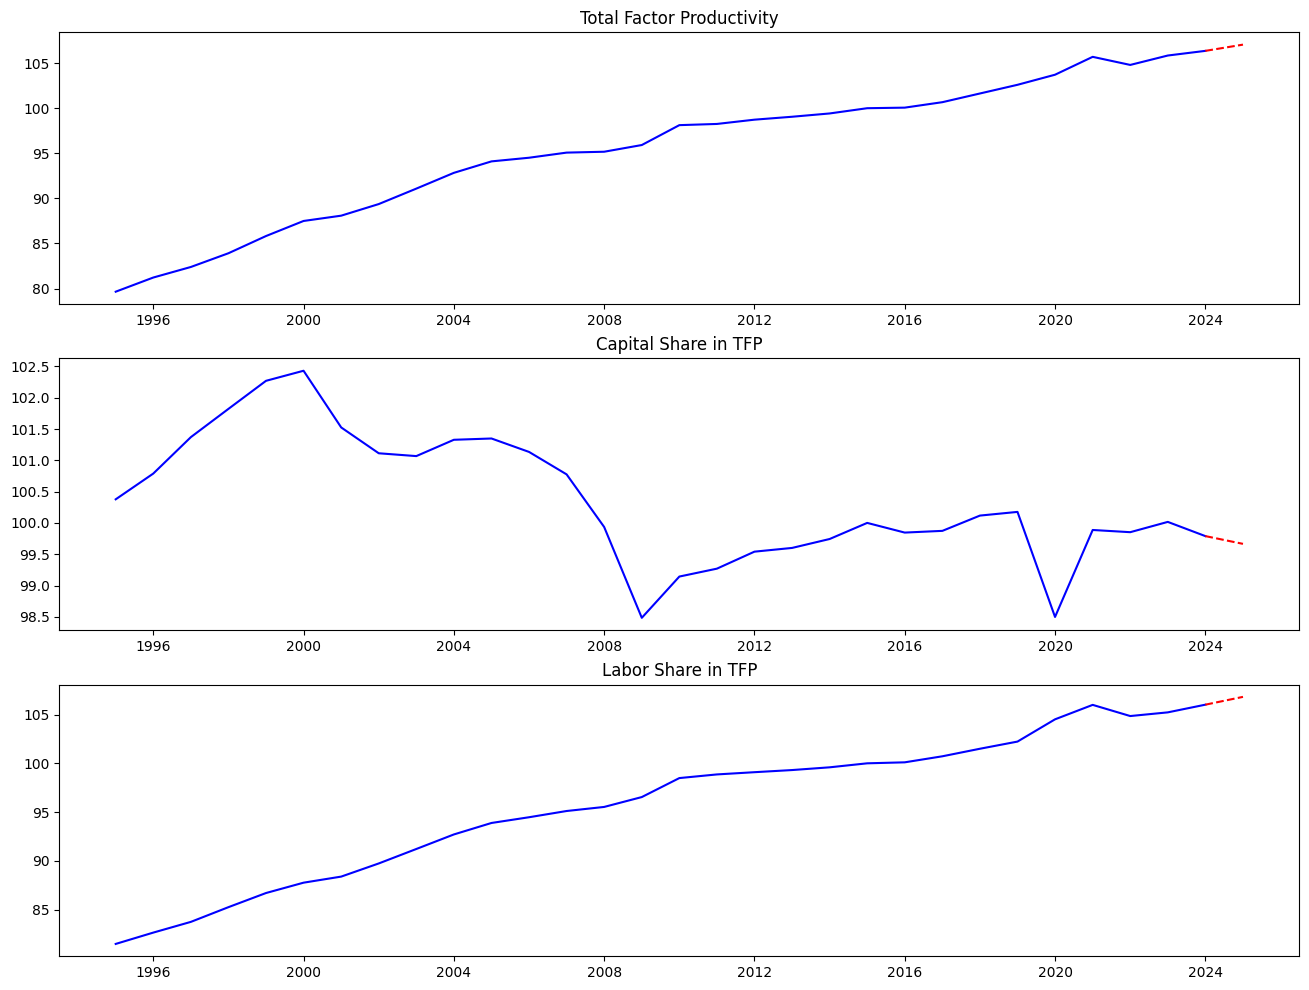

In [ ]:
#Let's plot the TFP level till today and its projection
plt.subplots(figsize=(16,12))
plt.subplot(311)
plt.plot(tfp[:today], color='b')
plt.plot(tfp[today:], color='r', linestyle='--')
plt.title('Total Factor Productivity')

plt.subplot(312)
plt.plot(cap_share[:today], color='b')
plt.plot(cap_share[today:], color='r', linestyle='--')
plt.title('Capital Share in TFP')

plt.subplot(313)
plt.plot(lab_share[:today], color='b')
plt.plot(lab_share[today:], color='r', linestyle='--')
plt.title('Labor Share in TFP')

plt.show()

In [ ]:
#Fetch data for Capital productivity
cap_prod = fetch_series('AMECO/AVGDK/USA.1.0.0.0.AVGDK')
cap_prod = clean_data(cap_prod, 'Capital Productivity')

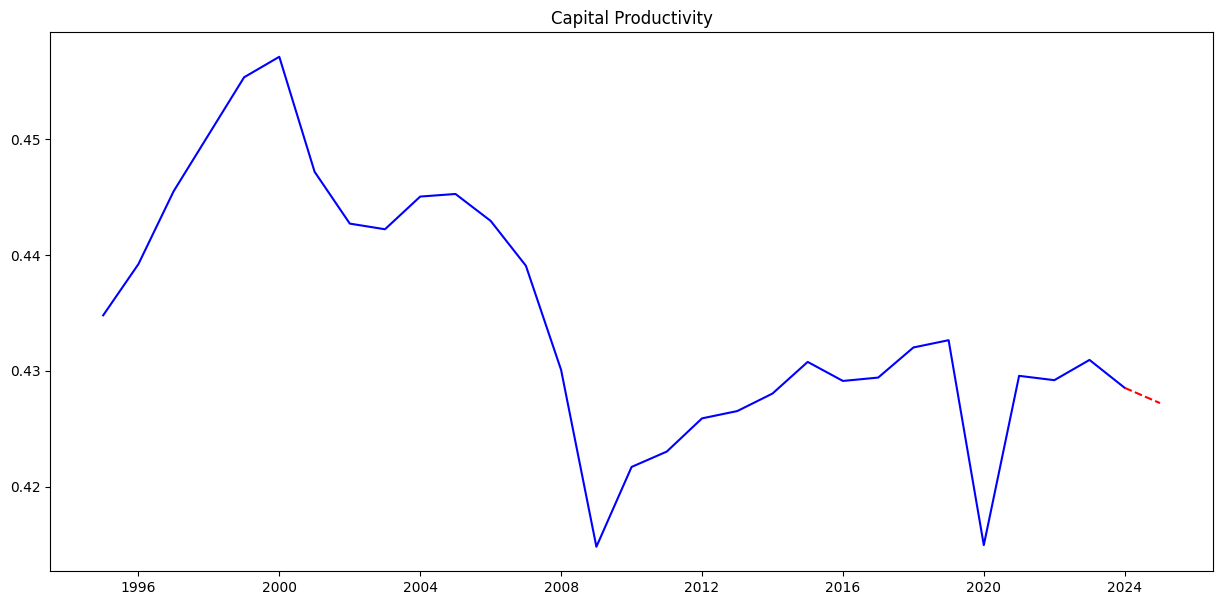

In [ ]:
#Plot Capital Productivity data
plt.figure(figsize=(15,7))
plt.plot(cap_prod.loc[:today], color='b')
plt.plot(cap_prod.loc[today:], color='r', linestyle='--')
plt.title('Capital Productivity')
plt.show()

In [ ]:
#Fetching and cleaning labor force data (SA)
labor_force = fetch_series('ILO/EAP_TEA1_SEX_AGE_NB/USA.BA_453.AGE_AGGREGATE_TOTAL.SEX_T.Q')

labor_force = clean_data(labor_force, 'Labor Force (Thousands)')

labor_force.tail()

Labor Force (Thousands)
period                             
2022-10-01                 164706.0
2023-01-01                 166274.7
2023-04-01                 166833.7
2023-07-01                 167616.7
2023-10-01                 167767.0

In [ ]:
#Fetching and cleaning unemployment rate data (SA)
unemp_rate = fetch_series('ILO/UNE_DEA1_SEX_AGE_RT/USA.BA_453.AGE_AGGREGATE_TOTAL.SEX_T.Q')
unemp_rate = clean_data(unemp_rate, 'Unemployment Rate (SA)')
unemp_rate.tail()

Unemployment Rate (SA)
period                            
2022-10-01                   3.567
2023-01-01                   3.500
2023-04-01                   3.567
2023-07-01                   3.700
2023-10-01                   3.733

In [ ]:
#Merging the two above dataframes
labor_supply = pd.concat([labor_force, unemp_rate], axis=1)
labor_supply.tail()

Labor Force (Thousands)  Unemployment Rate (SA)
period                                                     
2022-10-01                 164706.0                   3.567
2023-01-01                 166274.7                   3.500
2023-04-01                 166833.7                   3.567
2023-07-01                 167616.7                   3.700
2023-10-01                 167767.0                   3.733

In [ ]:
#Calculate the Employment rate
labor_supply['Employment Rate'] = 100 - labor_supply['Unemployment Rate (SA)']
labor_supply.tail()

Labor Force (Thousands)  Unemployment Rate (SA)  Employment Rate
period                                                                      
2022-10-01                 164706.0                   3.567           96.433
2023-01-01                 166274.7                   3.500           96.500
2023-04-01                 166833.7                   3.567           96.433
2023-07-01                 167616.7                   3.700           96.300
2023-10-01                 167767.0                   3.733           96.267

In [ ]:
#Calculate the Employment level (in thousands)
labor_supply['Employment (L)'] = (labor_supply['Labor Force (Thousands)'] * labor_supply['Employment Rate']) / 100
labor_supply['Log Employment (L)'] = np.log(labor_supply['Employment (L)']).values
labor_supply.tail()

Labor Force (Thousands)  Unemployment Rate (SA)  Employment Rate  \
period                                                                         
2022-10-01                 164706.0                   3.567           96.433   
2023-01-01                 166274.7                   3.500           96.500   
2023-04-01                 166833.7                   3.567           96.433   
2023-07-01                 167616.7                   3.700           96.300   
2023-10-01                 167767.0                   3.733           96.267   

            Employment (L)  Log Employment (L)  
period                                          
2022-10-01   158830.936980           11.975596  
2023-01-01   160455.085500           11.985769  
2023-04-01   160882.741921           11.988431  
2023-07-01   161414.882100           11.991733  
2023-10-01   161504.257890           11.992287

In [ ]:
#Estimating with the Hodrick-Prescott filter the potential Employment level (L*)
cycle, trend = sm.tsa.filters.hpfilter(labor_supply['Log Employment (L)'], 1600)
labor_decomp = labor_supply[['Log Employment (L)']]
labor_decomp["cycle"] = cycle
labor_decomp["trend"] = trend

In [ ]:
#Fetch the monthly data for the labor force rate (SA) and calculate its 12-M rolling mean
labor_force_rate = fetch_series('ILO/EAP_DWA1_SEX_AGE_RT/USA.BA_453.AGE_AGGREGATE_TOTAL.SEX_T.M')
labor_force_rate = clean_data(labor_force_rate, 'Labor Force Part. Rate (%, SA)')
labor_force_rate['12-M Avg'] = labor_force_rate['Labor Force Part. Rate (%, SA)'].rolling(12).mean()
labor_force_rate.tail()

Labor Force Part. Rate (%, SA)   12-M Avg
period                                               
2023-08-01                            62.8  62.475000
2023-09-01                            62.8  62.516667
2023-10-01                            62.7  62.550000
2023-11-01                            62.8  62.608333
2023-12-01                            62.5  62.625000

In [ ]:
#Fetch monthly data for the SA Unemployment rate
unemp_rate=fetch_series('ILO/UNE_DEA1_SEX_AGE_RT/USA.BA_453.AGE_AGGREGATE_TOTAL.SEX_T.M')
unemp_rate=clean_data(unemp_rate, 'Unemp. Rate (SA)')
unemp_rate.tail()

Unemp. Rate (SA)
period                      
2023-08-01               3.8
2023-09-01               3.8
2023-10-01               3.8
2023-11-01               3.7
2023-12-01               3.7

In [ ]:
api_key = "mSztDYKYxVxoiSYXBF3U"

In [ ]:
#Downloading the natural rate of unemployment for the U.S. from Quandl
nat_rate = quandl.get("FRED/NROUST", start='1986-01-01', authtoken=api_key)
nat_rate=nat_rate.loc[start:]
nat_rate=nat_rate.rename(columns={'Value':'Natural Rate of Unemployment (Short-Term)'})
nat_rate.tail()

Natural Rate of Unemployment (Short-Term)
Date                                                 
2030-10-01                                   4.294982
2031-01-01                                   4.289282
2031-04-01                                   4.283630
2031-07-01                                   4.278029
2031-10-01                                   4.272470

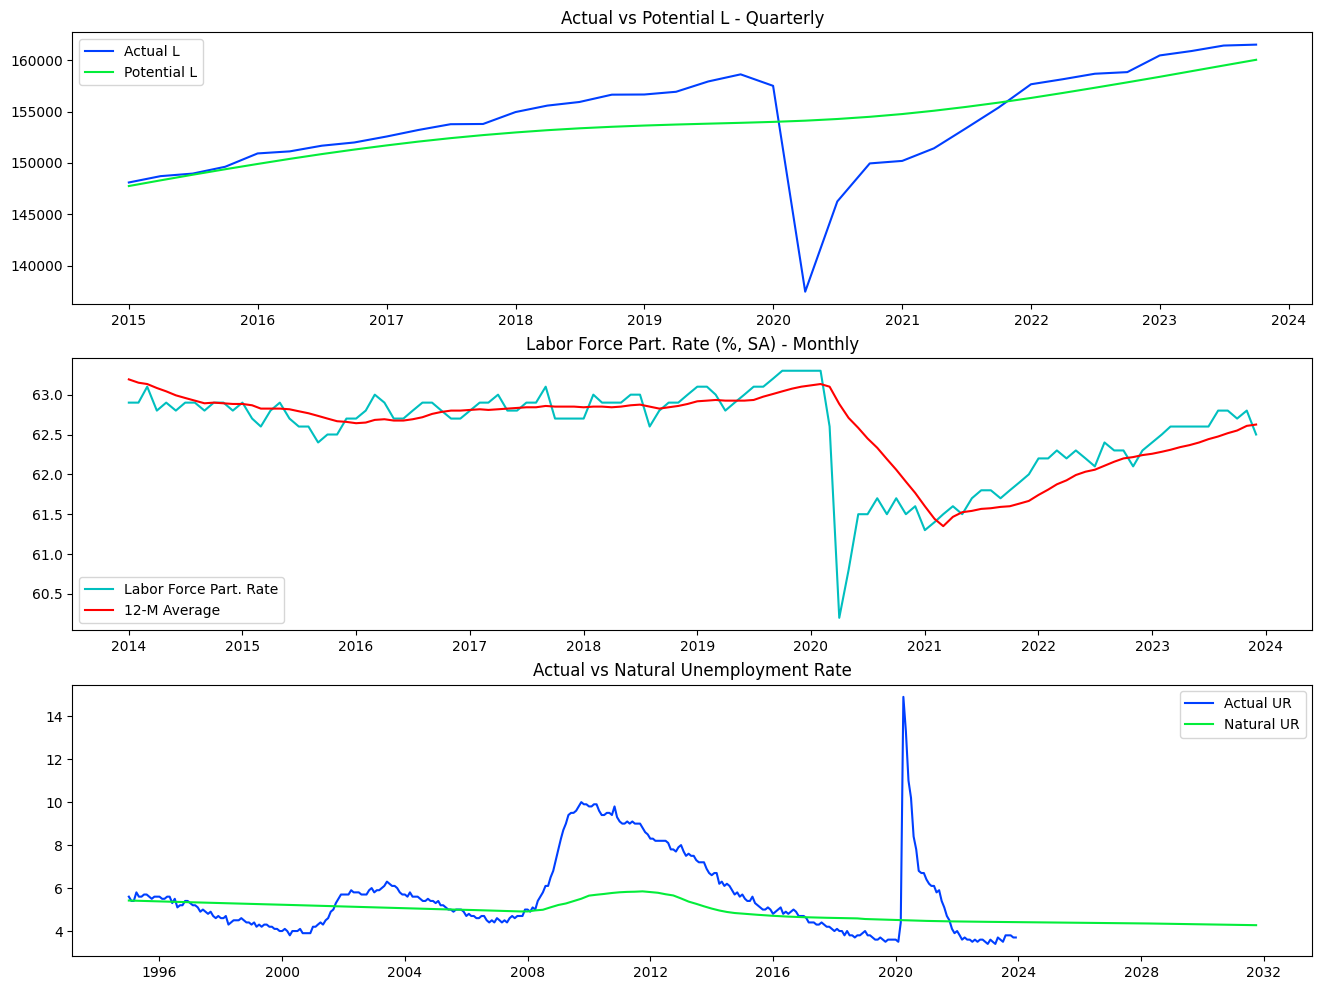

In [ ]:
#Plot the actual vs potential Labor level, the labor force part. rate
plt.figure(figsize=(16,12))

plt.subplot(311)
plt.plot(labor_supply['Employment (L)']["2015-01-01":])
plt.plot(np.exp(labor_decomp["trend"]["2015-01-01":]))
plt.title('Actual vs Potential L - Quarterly')
plt.legend(['Actual L', 'Potential L'])

plt.subplot(312)
plt.plot(labor_force_rate['Labor Force Part. Rate (%, SA)'][-120:], color='c')
plt.plot(labor_force_rate['12-M Avg'][-120:], color='r')
plt.title('Labor Force Part. Rate (%, SA) - Monthly')
plt.legend(['Labor Force Part. Rate', '12-M Average'])

plt.subplot(313)
plt.plot(unemp_rate["Unemp. Rate (SA)"][start:])
plt.plot(nat_rate['Natural Rate of Unemployment (Short-Term)'][start:])
plt.title('Actual vs Natural Unemployment Rate')
plt.legend(['Actual UR', 'Natural UR'])

plt.show()

In [ ]:
!pip install fredapi
import fredapi

In [ ]:
# Define fred in a previous cell or function
fred = fredapi.Fred(api_key='5cd0fc1aa30aa5c9e25afe00e741a61c')

# Use fred in the current cell
u6 = fred.get_series('U6RATE')

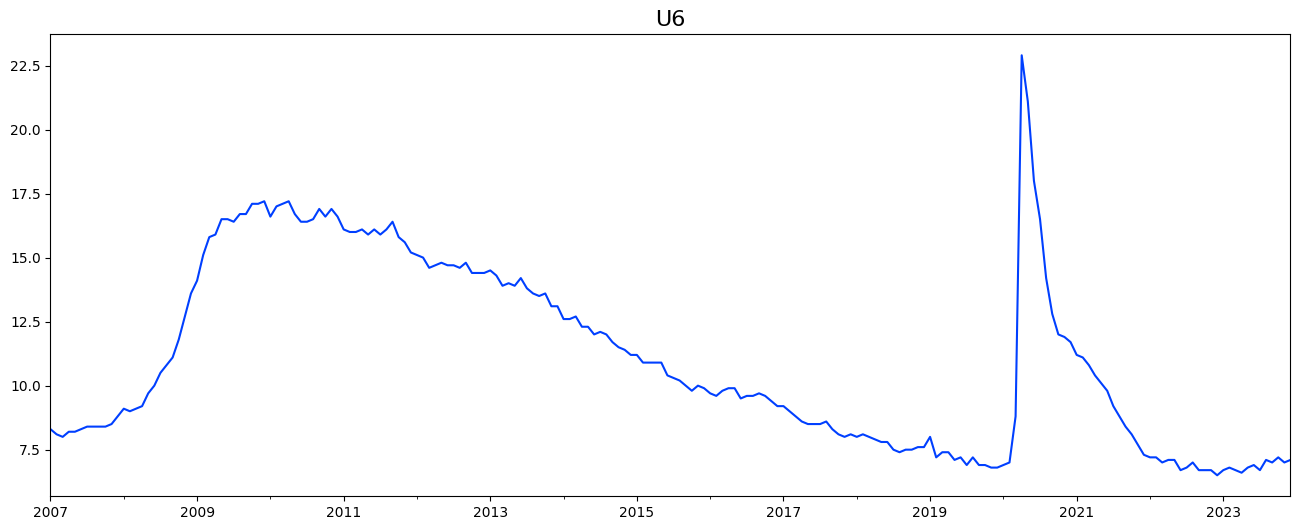

In [ ]:
plt.figure(figsize=(16,6))
u6.loc['2007-01-01':].plot()
plt.title('U6', fontsize=16)
plt.show()

In [ ]:
#Fetch initial jobless claims data
non_farm_pr = eco_cal_data_int(event='Nonfarm Payrolls')
non_farm_pr.tail()

Nonfarm Payrolls
date                        
2023-09-01               187
2023-10-06               336
2023-11-03               150
2023-12-08               199
2024-01-05               216

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf

In [ ]:
def eco_cal_data_int(event, start_date):
    """
    This function retrieves economic calendar data for a specific event and start date.

    Args:
        event: The economic event to retrieve data for.
        start_date: The start date for the data.

    Returns:
        A pandas DataFrame containing the economic calendar data.
    """

    return yf.download(
        f"^FVX_{event}",
        start=start_date,
        progress=False,
    )

In [ ]:
jobless_claims = eco_cal_data_int(event="Initial Jobless Claims", start_date="2010-01-01")
jobless_claims.tail()

ERROR:yfinance:
3 Failed downloads:
ERROR:yfinance:['^FVX_INITIAL', 'CLAIMS', 'JOBLESS']: Exception('%ticker%: No timezone found, symbol may be delisted')


Empty DataFrame
Columns: [(Adj Close, CLAIMS), (Adj Close, JOBLESS), (Adj Close, ^FVX_INITIAL), (Close, CLAIMS), (Close, JOBLESS), (Close, ^FVX_INITIAL), (High, CLAIMS), (High, JOBLESS), (High, ^FVX_INITIAL), (Low, CLAIMS), (Low, JOBLESS), (Low, ^FVX_INITIAL), (Open, CLAIMS), (Open, JOBLESS), (Open, ^FVX_INITIAL), (Volume, CLAIMS), (Volume, JOBLESS), (Volume, ^FVX_INITIAL)]
Index: []

In [ ]:
jobless_claims = eco_cal_data_int(event='Initial Jobless Claims', start_date='2010-01-01')
jobless_claims.tail()

TypeError: eco_cal_data_int() got an unexpected keyword argument 'start_date'

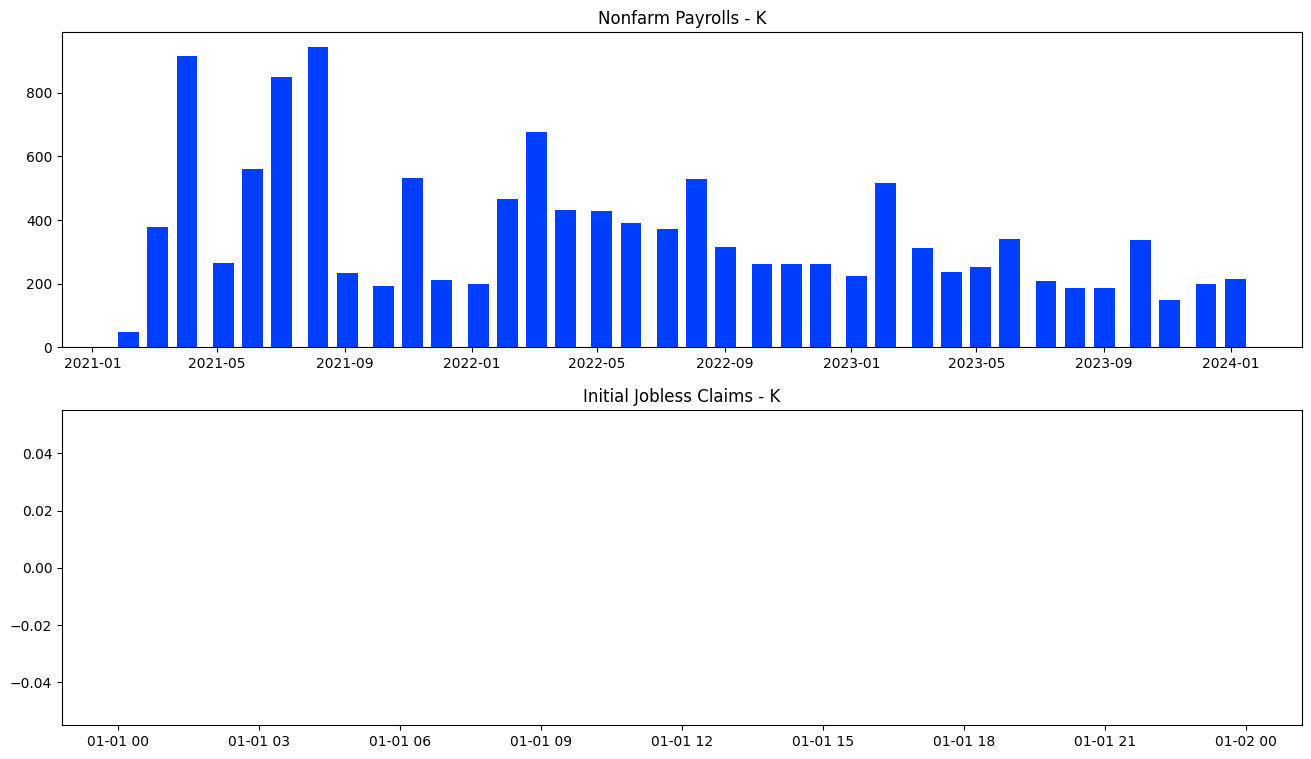

In [ ]:
plt.subplots(figsize=(16,9))

plt.subplot(211)
plt.bar(non_farm_pr.index[-36:], non_farm_pr['Nonfarm Payrolls'].iloc[-36:], width=20)
plt.title('Nonfarm Payrolls - K')

plt.subplot(212)
plt.plot(jobless_claims.iloc[-12:])
plt.title('Initial Jobless Claims - K')

plt.show()

# Section 2: Output Gap

In this section our goal is to understand if the economy is running a positive or negative output gap. In the first case we should expect a more tightening approach from policymakers, while in the second one a more dovish attitude.

In [ ]:
#Fetch annual data with projections for the output gap from IMF
output_gap = fetch_series('IMF/WEO:2021-10/USA.NGAP_NPGDP.pcent_potential_gdp')
output_gap = clean_data(output_gap, 'Output Gap')
output_gap['zero'] = 0
output_gap.tail(7)

Output Gap  zero
period                      
2020-01-01      -3.317     0
2021-01-01       0.558     0
2022-01-01       3.301     0
2023-01-01       3.014     0
2024-01-01       2.288     0
2025-01-01       1.631     0
2026-01-01       1.078     0

In [ ]:
#Fetch quarterly output gap data from FRED
output_gap_FRED = pd.DataFrame()
output_gap_FRED['GDP - Q'] = fred.get_series('GDPC1', frequency='q')
output_gap_FRED['Potential GDP - Q'] = fred.get_series('GDPPOT', frequency='q')
output_gap_FRED['Output Gap'] = (output_gap_FRED['GDP - Q'] - output_gap_FRED['Potential GDP - Q']) / output_gap_FRED['Potential GDP - Q'] * 100
output_gap_FRED.tail()

GDP - Q  Potential GDP - Q  Output Gap
2022-07-01  21851.134           20245.66    7.929966
2022-10-01  21989.981           20334.21    8.142785
2023-01-01  22112.329           20420.68    8.283999
2023-04-01  22225.350           20511.89    8.353496
2023-07-01  22490.692           20603.70    9.158510

In [ ]:
#Fetch data for quarterly real GDP
real_gdp = fetch_series('OECD/QNA/USA.B1_GS1.LNBARSA.Q')
real_gdp = clean_data(real_gdp, 'Real GDP')
real_gdp['Log Real GDP'] = np.log(real_gdp['Real GDP']).values
real_gdp.tail()

Real GDP  Log Real GDP
period                              
2022-07-01  21851134.0     16.899763
2022-10-01  21989981.0     16.906097
2023-01-01  22112329.0     16.911646
2023-04-01  22225350.0     16.916744
2023-07-01  22490692.0     16.928612

In [ ]:
#Estimating the potential GDP with HP fillter
cycle, trend = sm.tsa.filters.hpfilter(real_gdp['Log Real GDP'], 1600)
gdp_decomp = real_gdp[['Log Real GDP']]
gdp_decomp["cycle"] = cycle
gdp_decomp["trend"] = trend

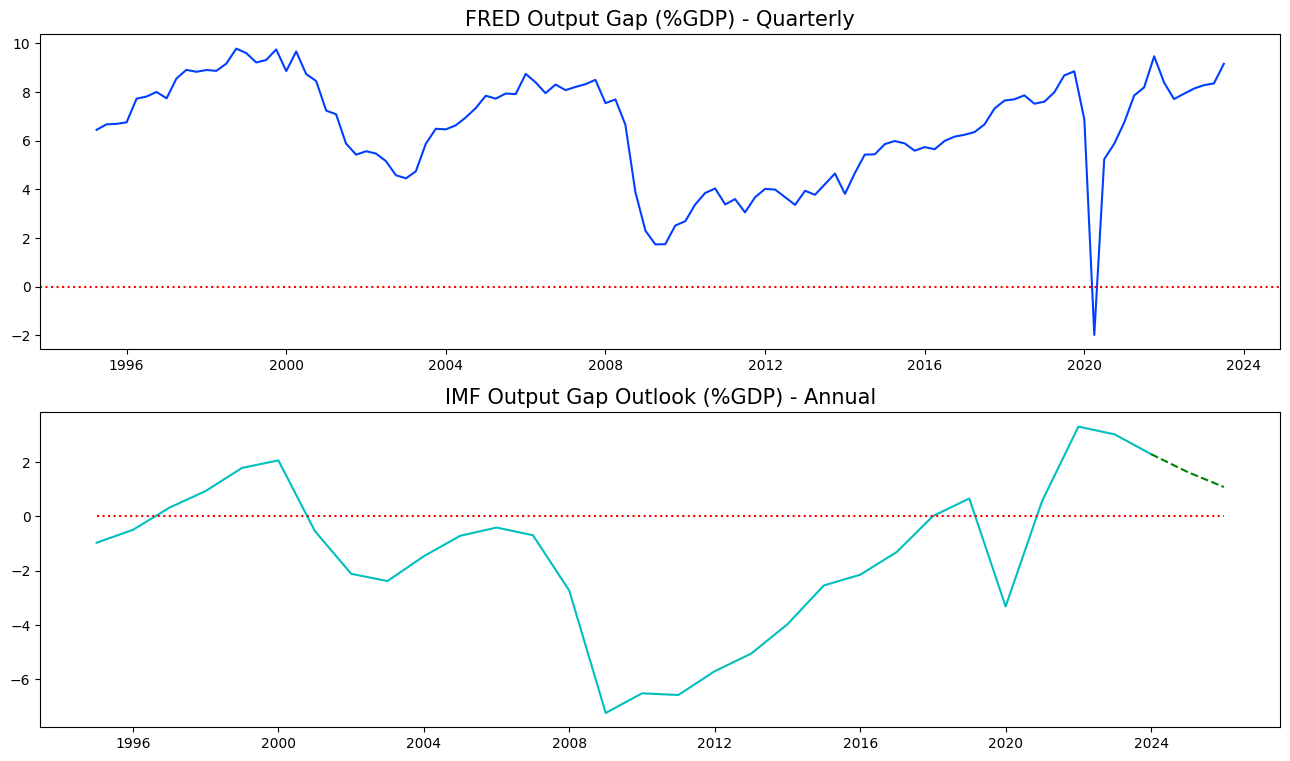

In [ ]:
#Plot current and projected output gap and actual vs potential GDP
plt.figure(figsize=(16,9))

plt.subplot(211)
plt.plot(output_gap_FRED['Output Gap']["1995-04-01":])
plt.axhline(y=0, color='red', linestyle=':')
plt.title('FRED Output Gap (%GDP) - Quarterly', size = 15)

plt.subplot(212)
plt.plot(output_gap['Output Gap'][:today], color='c')
plt.plot(output_gap['Output Gap'][today:], color='g', linestyle='--')
plt.plot(output_gap['zero'], color='r', linestyle=':')
plt.title('IMF Output Gap Outlook (%GDP) - Annual', size = 15)

plt.show()

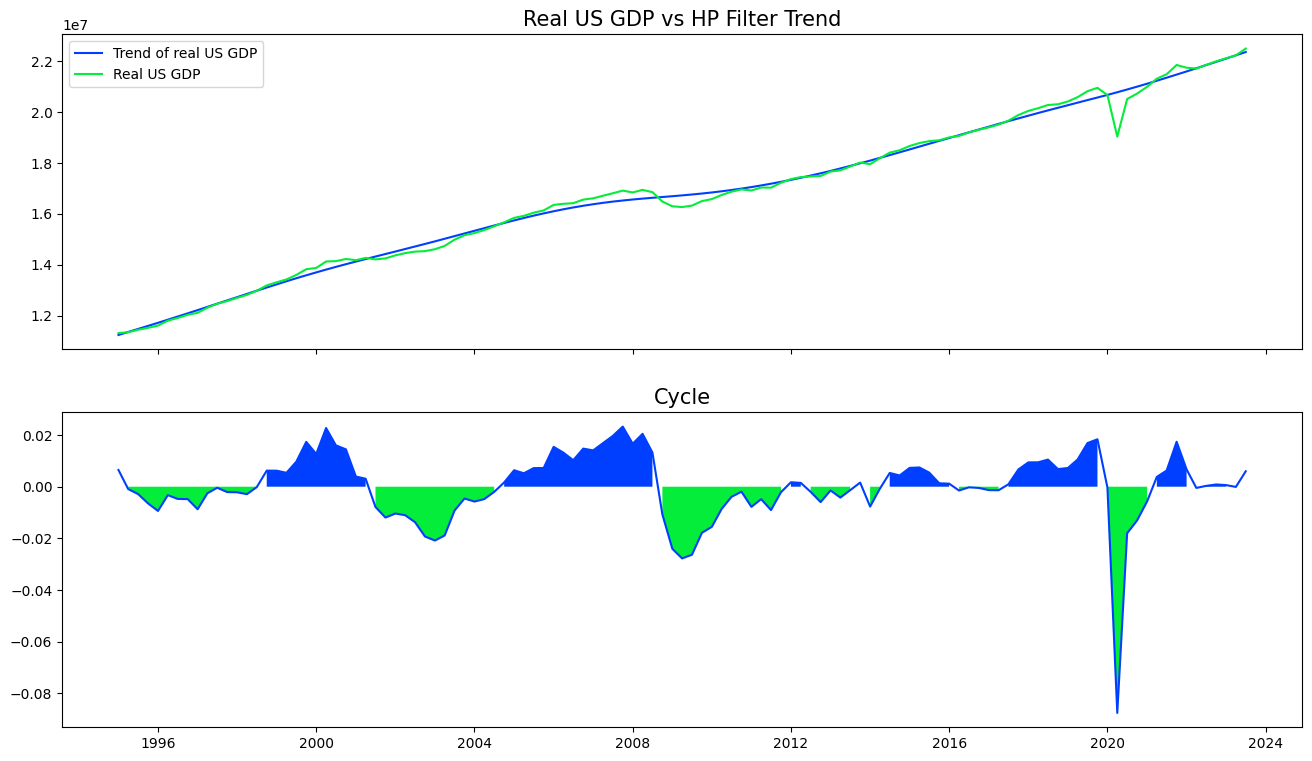

In [ ]:
#Plot output gap and cycles
fig,ax = plt.subplots(2,1,sharex = True, figsize = (16,9))

df_trend = pd.Series(index = gdp_decomp.index, data = np.exp(gdp_decomp['trend']))
df_cycle = pd.Series(index = gdp_decomp.index, data = gdp_decomp['cycle'])

zero = [0 for t in gdp_decomp['trend']]

ax[0].plot(df_trend);
ax[0].plot(real_gdp['Real GDP']);
ax[0].legend(['Trend of real US GDP','Real US GDP']);
ax[1].plot(df_cycle)
ax[1].fill_between(real_gdp.index,zero,df_cycle,where=df_cycle > 0);
ax[1].fill_between(real_gdp.index,zero,df_cycle,where=df_cycle < 0);

ax[0].set_title('Real US GDP vs HP Filter Trend',size = 15)
ax[1].set_title('Cycle',size = 15);

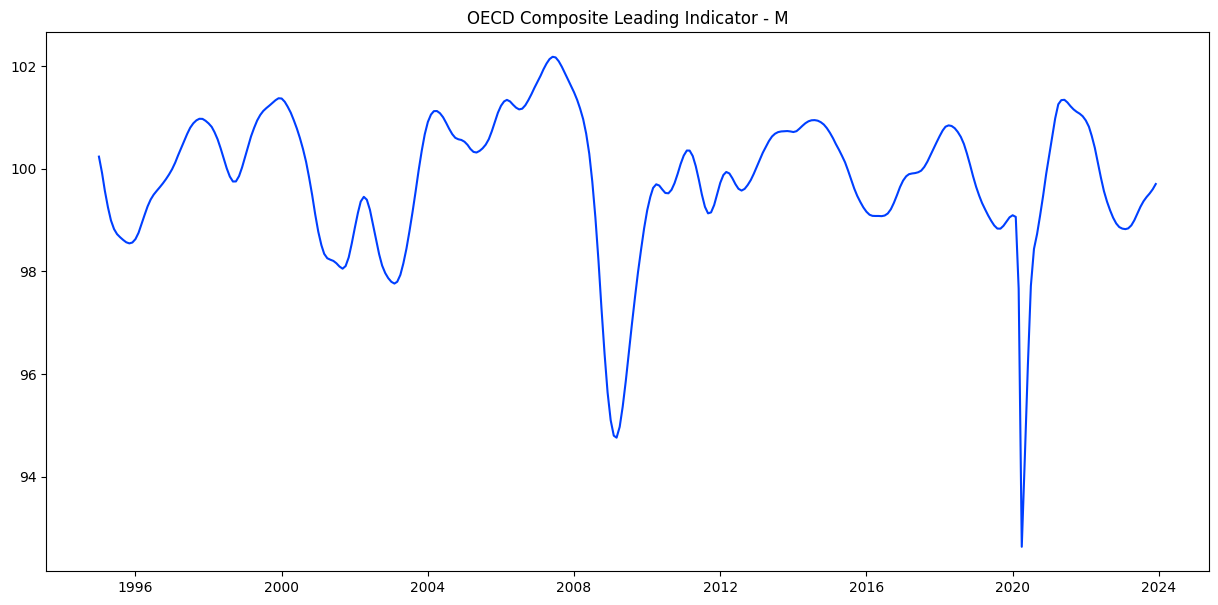

In [ ]:
#Download data for OECD Composite Leading Indicator
oecd_cli = fetch_series('OECD/MEI_CLI/LOLITOAA.USA.M')
oecd_cli = clean_data(oecd_cli, 'OECD CLI')

#Plot data for OECD Composite Leading Indicator
plt.figure(figsize=(15,7))
plt.plot(oecd_cli)
plt.title('OECD Composite Leading Indicator - M')
plt.show()

The composite leading indicator (CLI) is designed to provide early signals of turning points in business cycles showing fluctuation of the economic activity around its long term potential level. CLIs show short-term economic movements in qualitative rather than quantitative terms.

# Section 3: Aggregate Demand Analysis

In this section we are going to analyze the components of aggregate demand to understand from where the positive or negative growth is coming from. We will also look in more detail at the components of the private consumption.

In [ ]:
#Let's fetch Aggregate Demand components data and store them in a dataframe
agg_dem_list = ['OECD/QNA/USA.P31S14_S15.LNBARSA.Q',
                'OECD/QNA/USA.P3S13.LNBARSA.Q',
                'OECD/QNA/USA.P51.LNBARSA.Q',
                'OECD/QNA/USA.P52.LNBARSA.Q',
                'OECD/QNA/USA.P6.LNBARSA.Q',
                'OECD/QNA/USA.P7.LNBARSA.Q',
                'OECD/QNA/USA.RB1_GE.LNBARSA.Q']



agg_dem = pd.DataFrame()

for i in agg_dem_list:
    agg_dem = agg_dem.append(fetch_series(i)[['period', 'series_name', 'value']])


agg_dem = agg_dem.pivot(index='period', columns='series_name', values='value')
agg_dem['real_gdp'] = real_gdp['Real GDP']
agg_dem.tail()

series_name  United States – Changes in inventories – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                       
2022-07-01                                             70681.0                                                                                                               
2022-10-01                                            151902.0                                                                                                               
2023-01-01                                             27165.0                                                                                                               
2023-04-01                                             14928.0                                                                                                               
2023-07-01                                             77764.0                                                                                                               

series_name  United States – Exports of goods and services – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                              
2022-07-01                                           2506197.0                                                                                                                      
2022-10-01                                           2484052.0                                                                                                                      
2023-01-01                                           2525402.0                                                                                                                      
2023-04-01                                           2464668.0                                                                                                                      
2023-07-01                                           2497279.0                                                                                                                      

series_name  United States – General government final consumption expenditure – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                                                 
2022-07-01                                           2928397.0                                                                                                                                         
2022-10-01                                           2952506.0                                                                                                                                         
2023-01-01                                           2985486.0                                                                                                                                         
2023-04-01                                           2991987.0                                                                                                                                         
2023-07-01                                           3024152.0                                                                                                                                         

series_name  United States – Gross fixed capital formation – National currency, chained volume estimates, nation

In [ ]:
#Rename columns
col_names = ['Change in Inventories - Q', 'Exports - Q', 'Government Consumption - Q', 'Gross Fixed Capital Formation - Q', 'Imports - Q', 'Private Consumption - Q', 'Residual Item - Q', 'Real GDP']

agg_dem.columns = col_names
agg_dem.tail()

Change in Inventories - Q  Exports - Q  \
period                                               
2022-07-01                    70681.0    2506197.0   
2022-10-01                   151902.0    2484052.0   
2023-01-01                    27165.0    2525402.0   
2023-04-01                    14928.0    2464668.0   
2023-07-01                    77764.0    2497279.0   

            Government Consumption - Q  Gross Fixed Capital Formation - Q  \
period                                                                      
2022-07-01                   2928397.0                          4668502.0   
2022-10-01                   2952506.0                          4638498.0   
2023-01-01                   2985486.0                          4679054.0   
2023-04-01                   2991987.0                          4753975.0   
2023-07-01                   3024152.0                          4801141.0   

            Imports - Q  Private Consumption - Q  Residual Item - Q  \
period                                                                
2022-07-01    3487427.0               15127399.0            37385.0   
2022-10-01    3449621.0               15171391.0            41253.0   
2023-01-01    3460481.0               15312850.0            42853.0   
2023-04-01    3392861.0               15343553.0            49100.0   
2023-07-01    3427952.0               15461382.0            56926.0   

              Real GDP  
period                  
2022-07-01  21851134.0  
2022-10-01  21989981.0  
2023-01-01  22112329.0  
2023-04-01  22225350.0  
2023-07-01  22490692.0

In [ ]:
#Calculate Net Exports
agg_dem['Net Exports - Q'] = agg_dem['Exports - Q'] - agg_dem['Imports - Q']
agg_dem.tail()

Change in Inventories - Q  Exports - Q  \
period                                               
2022-07-01                    70681.0    2506197.0   
2022-10-01                   151902.0    2484052.0   
2023-01-01                    27165.0    2525402.0   
2023-04-01                    14928.0    2464668.0   
2023-07-01                    77764.0    2497279.0   

            Government Consumption - Q  Gross Fixed Capital Formation - Q  \
period                                                                      
2022-07-01                   2928397.0                          4668502.0   
2022-10-01                   2952506.0                          4638498.0   
2023-01-01                   2985486.0                          4679054.0   
2023-04-01                   2991987.0                          4753975.0   
2023-07-01                   3024152.0                          4801141.0   

            Imports - Q  Private Consumption - Q  Residual Item - Q  \
period                                                                
2022-07-01    3487427.0               15127399.0            37385.0   
2022-10-01    3449621.0               15171391.0            41253.0   
2023-01-01    3460481.0               15312850.0            42853.0   
2023-04-01    3392861.0               15343553.0            49100.0   
2023-07-01    3427952.0               15461382.0            56926.0   

              Real GDP  Net Exports - Q  
period                                   
2022-07-01  21851134.0        -981230.0  
2022-10-01  21989981.0        -965569.0  
2023-01-01  22112329.0        -935079.0  
2023-04-01  22225350.0        -928193.0  
2023-07-01  22490692.0        -930673.0

In [ ]:
#Calculate aggregate demand components as a percentage of GDP
agg_dem_pct = pd.DataFrame()
agg_dem_pct['Private Consumption - %GDP'] = agg_dem['Private Consumption - Q'] / agg_dem['Real GDP']
agg_dem_pct['Government Consumption - %GDP'] = agg_dem['Government Consumption - Q'] / agg_dem['Real GDP']
agg_dem_pct['Gross Fixed Capital Formation - Q - %GDP'] = agg_dem['Gross Fixed Capital Formation - Q'] / agg_dem['Real GDP']
agg_dem_pct['Change in Inventories - %GDP'] = agg_dem['Change in Inventories - Q'] / agg_dem['Real GDP']
agg_dem_pct['Net Exports - %GDP'] = agg_dem['Net Exports - Q'] / agg_dem['Real GDP']
agg_dem_pct['Residual Item - %GDP'] = agg_dem['Residual Item - Q'] / agg_dem['Real GDP']
agg_dem_pct.tail()

Private Consumption - %GDP  Government Consumption - %GDP  \
period                                                                  
2022-07-01                    0.692294                       0.134016   
2022-10-01                    0.689923                       0.134266   
2023-01-01                    0.692503                       0.135015   
2023-04-01                    0.690363                       0.134620   
2023-07-01                    0.687457                       0.134462   

            Gross Fixed Capital Formation - Q - %GDP  \
period                                                 
2022-07-01                                  0.213650   
2022-10-01                                  0.210937   
2023-01-01                                  0.211604   
2023-04-01                                  0.213899   
2023-07-01                                  0.213472   

            Change in Inventories - %GDP  Net Exports - %GDP  \
period                                                         
2022-07-01                      0.003235           -0.044905   
2022-10-01                      0.006908           -0.043909   
2023-01-01                      0.001229           -0.042288   
2023-04-01                      0.000672           -0.041763   
2023-07-01                      0.003458           -0.041380   

            Residual Item - %GDP  
period                            
2022-07-01              0.001711  
2022-10-01              0.001876  
2023-01-01              0.001938  
2023-04-01              0.002209  
2023-07-01              0.002531

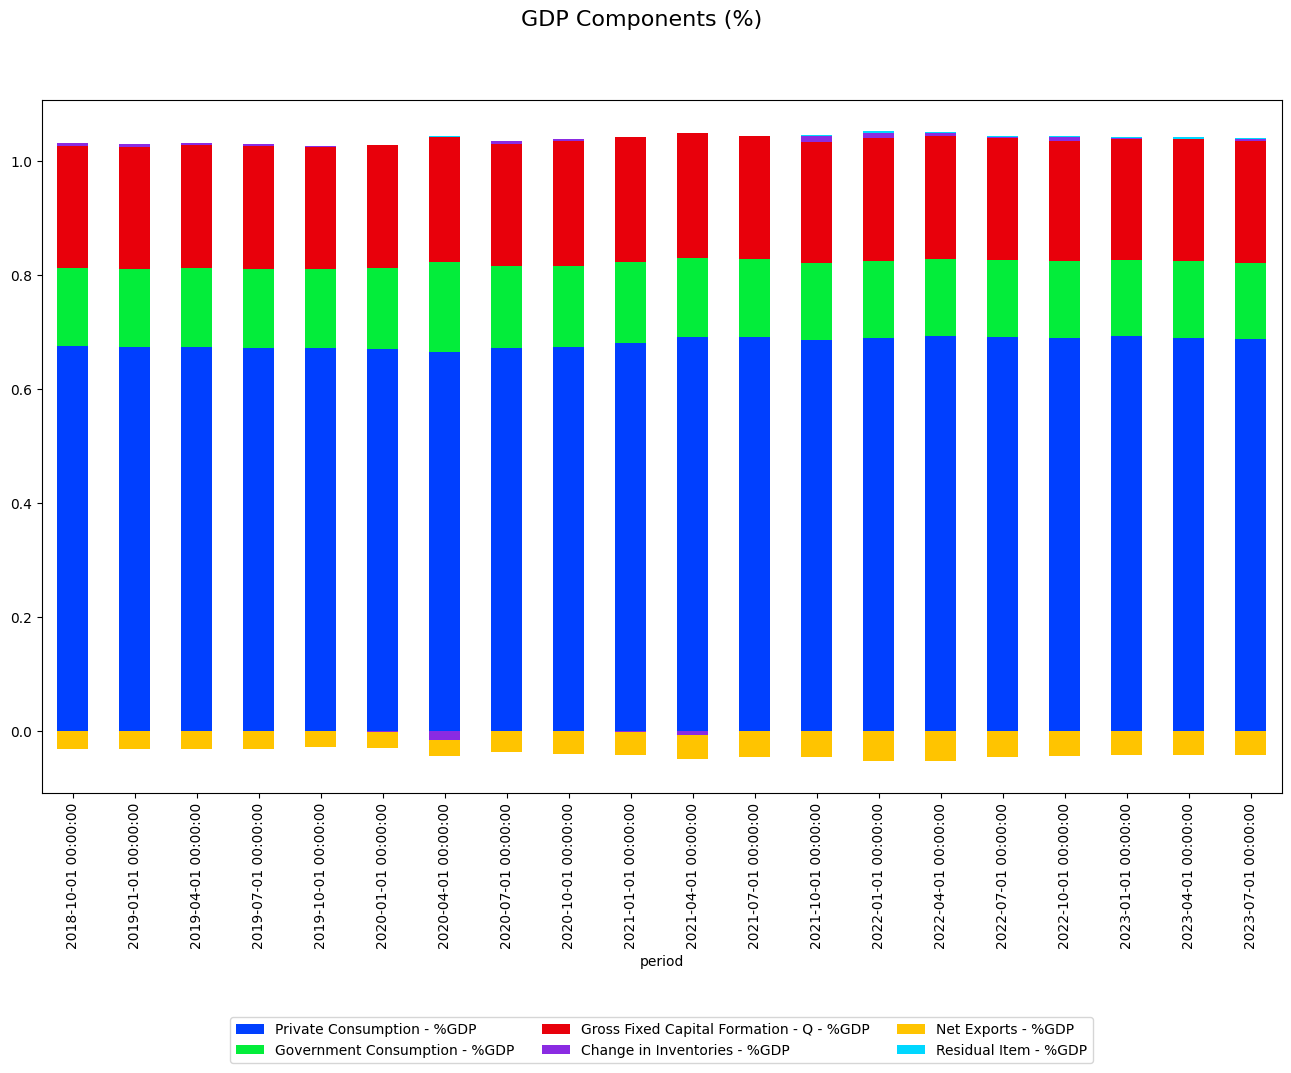

In [ ]:
#Plot the components of AD in a stacked barchart
ax = agg_dem_pct.iloc[-20:].plot.bar(stacked=True, figsize=(16,9))
ax = plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol= 3)
plt.suptitle('GDP Components (%)', size=16)
plt.show()

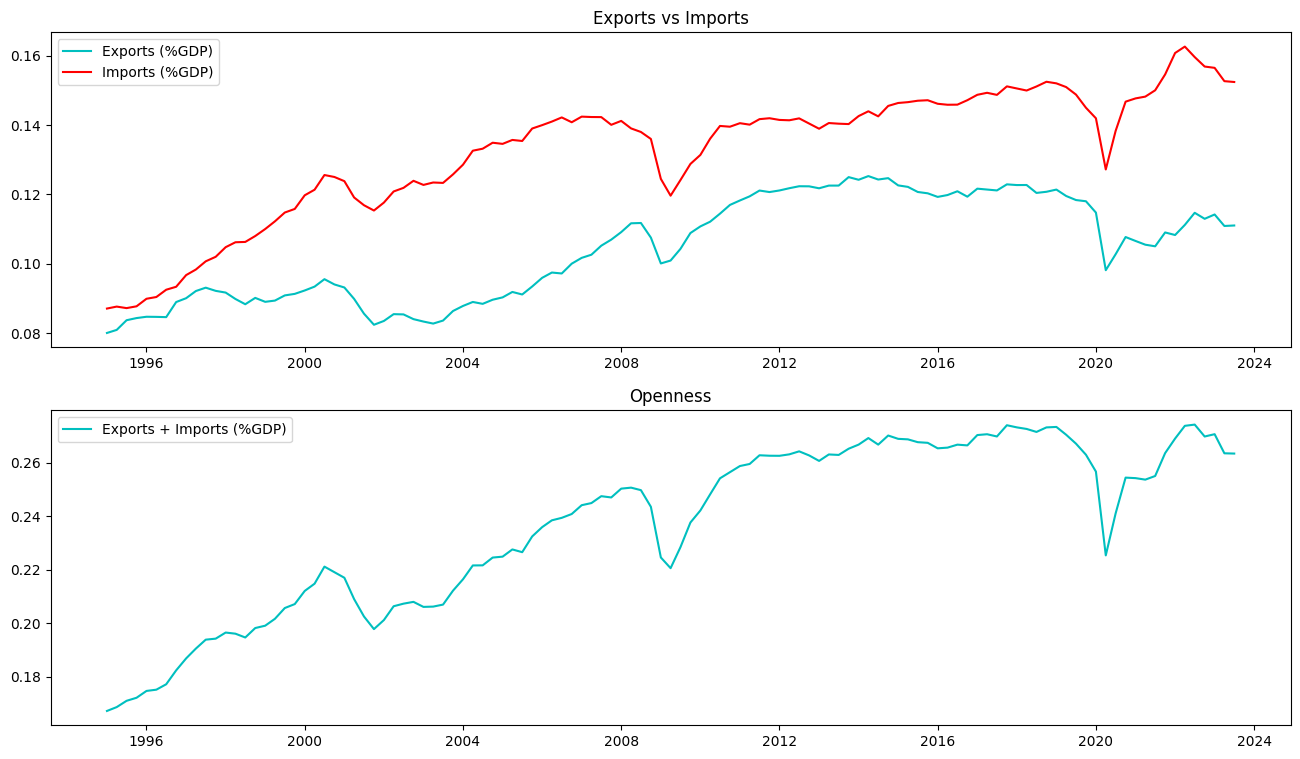

In [ ]:
#Plot the Exports and Imports time series and the "Openness" of the economy as the sum of the two previous items
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot((agg_dem['Exports - Q'] / agg_dem['Real GDP']), color='c')
plt.plot((agg_dem['Imports - Q'] / agg_dem['Real GDP']), color='r')
plt.title('Exports vs Imports')
plt.legend(['Exports (%GDP)', 'Imports (%GDP)'])
plt.subplot(212)
plt.plot((((agg_dem['Exports - Q'] / agg_dem['Real GDP']) + (agg_dem['Imports - Q'] / agg_dem['Real GDP']))), color='c')
plt.title('Openness')
plt.legend(['Exports + Imports (%GDP)'], loc='upper left')
plt.show()

In [ ]:
#Calculate how each component of AD contributed to GDP growth
growth_contr = pd.DataFrame()
growth_contr['GDP Growth (YoY)'] = agg_dem['Real GDP'].pct_change(4)
growth_contr['Priv. Cons. Contr.'] = agg_dem['Private Consumption - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Gov. Cons. Contr.'] = agg_dem['Government Consumption - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['GFCF Contr.'] = agg_dem['Gross Fixed Capital Formation - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Chg. Inv. Contr.'] = agg_dem['Change in Inventories - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Net Exp. Contr.'] = agg_dem['Net Exports - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr['Res. Item Contr.'] = agg_dem['Residual Item - Q'].diff(4) / agg_dem['Real GDP'].shift(4)
growth_contr = growth_contr.dropna()
growth_contr.head()

GDP Growth (YoY)  Priv. Cons. Contr.  Gov. Cons. Contr.  \
period                                                                
2003-01-01          0.016793            0.015105           0.002649   
2003-04-01          0.019551            0.019406           0.003197   
2003-07-01          0.032311            0.024321           0.002425   
2003-10-01          0.043004            0.025338           0.002635   
2004-01-01          0.043420            0.028365           0.003447   

            GFCF Contr.  Chg. Inv. Contr.  Net Exp. Contr.  Res. Item Contr.  
period                                                                        
2003-01-01     0.001808          0.003300        -0.005928         -0.000142  
2003-04-01     0.005713         -0.002890        -0.006104          0.000229  
2003-07-01     0.011529         -0.001593        -0.004486          0.000115  
2003-10-01     0.014916          0.000374        -0.001200          0.000942  
2004-01-01     0.012857          0.000978        -0.003101          0.000875

In [ ]:
#The following dataframe is identical to the above one, but with the "period" index set as a column instead of as the index. This is done simply to plot it below in a combined chart
df_to_plot = growth_contr.reset_index()
df_to_plot.tail()

period  GDP Growth (YoY)  Priv. Cons. Contr.  Gov. Cons. Contr.  \
78 2022-07-01          0.017132            0.012967          -0.000841   
79 2022-10-01          0.006517            0.008044           0.000331   
80 2023-01-01          0.017179            0.014611           0.002868   
81 2023-04-01          0.023825            0.012640           0.003653   
82 2023-07-01          0.029269            0.015284           0.004382   

    GFCF Contr.  Chg. Inv. Contr.  Net Exp. Contr.  Res. Item Contr.  
78     0.001812          0.002948        -0.000684          0.000930  
79    -0.000373         -0.002527         0.001376         -0.000335  
80    -0.001448         -0.007813         0.009475         -0.000514  
81     0.002435         -0.003582         0.008660          0.000018  
82     0.006070          0.000324         0.002314          0.000894

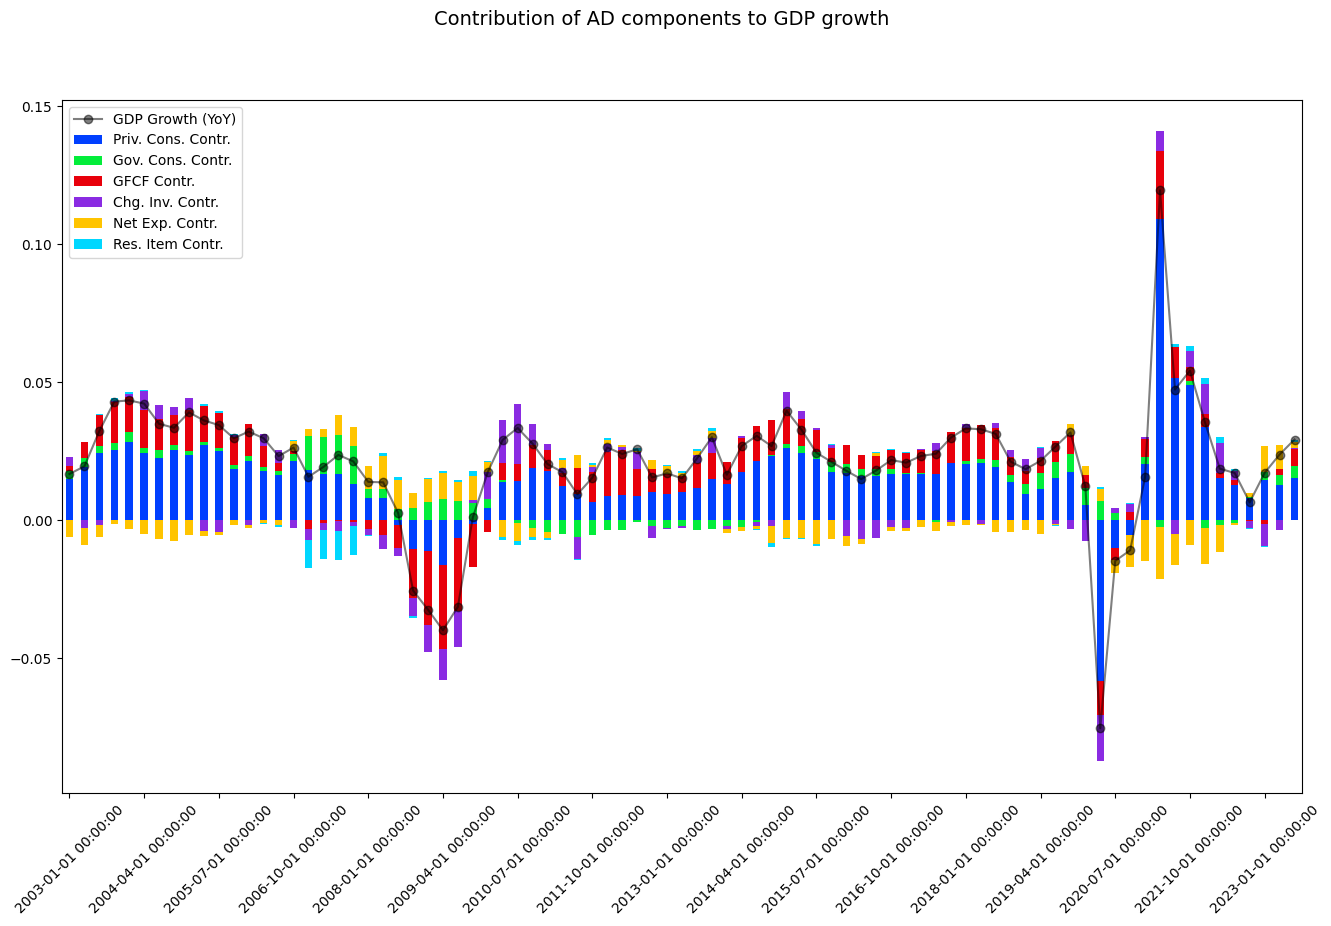

In [ ]:
#Plot the contribution of AD components in a stacked chart together with the evolution of GDP growth
fig, ax1 = plt.subplots(figsize = (16, 9))

df_to_plot[['Priv. Cons. Contr.',
              'Gov. Cons. Contr.',
              'GFCF Contr.',
              'Chg. Inv. Contr.',
              'Net Exp. Contr.',
              'Res. Item Contr.']].\
         plot(kind = 'bar', stacked = True, ax = ax1)

df_to_plot['GDP Growth (YoY)'].plot(linestyle='-', marker='o', color='black', alpha=0.5, ax = ax1, legend=True)

leg = plt.legend(loc='upper left')

ax1.set_xticklabels(labels = df_to_plot['period'],rotation = 45)
ax1.set_xticks(np.arange(0, len(df_to_plot)+1, 5))
plt.suptitle('Contribution of AD components to GDP growth', fontsize=14)
plt.show()

In [ ]:
#Fetch data for Private Consumption analysis and store them in a DataFrame
priv_cons_list = ['OECD/QNA/USA.P311B.LNBARSA.Q',
                'OECD/QNA/USA.P313B.LNBARSA.Q',
                'OECD/QNA/USA.P314B.LNBARSA.Q',
                'OECD/QNA/USA.RP31DC.LNBARSA.Q']



priv_cons_comp = pd.DataFrame()

for i in priv_cons_list:
    priv_cons_comp = priv_cons_comp.append(fetch_series(i)[['period', 'series_name', 'value']])


priv_cons_comp = priv_cons_comp.pivot(index='period', columns='series_name', values='value')
priv_cons_comp['real_gdp'] = real_gdp['Real GDP']
priv_cons_comp.tail()

series_name  United States – Durable goods – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                              
2022-07-01                                           1962321.0                                                                                                      
2022-10-01                                           1957466.0                                                                                                      
2023-01-01                                           2022529.0                                                                                                      
2023-04-01                                           2020872.0                                                                                                      
2023-07-01                                           2053896.0                                                                                                      

series_name  United States – Non-durable goods – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                  
2022-07-01                                           3319708.0                                                                                                          
2022-10-01                                           3323708.0                                                                                                          
2023-01-01                                           3327795.0                                                                                                          
2023-04-01                                           3335446.0                                                                                                          
2023-07-01                                           3367295.0                                                                                                          

series_name  United States – Residual item (RP31DC) – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                                       
2022-07-01                                            -32826.0                                                                                                               
2022-10-01                                            -32036.0                                                                                                               
2023-01-01                                            -36395.0                                                                                                               
2023-04-01                                            -35866.0                                                                                                               
2023-07-01                                            -38481.0                                                                                                               

series_name  United States – Services – National currency, chained volume estimates, national reference year, annual levels, seasonally adjusted – Quarterly  \
period                                                                                                                                                         
2022-07-01                                           9878196.0                                                           

In [ ]:
#Rename columns
col_names = ['Durable Goods - Q', 'Non-Durable Goods - Q', 'Other - Q', 'Services - Q', 'Real GDP']

priv_cons_comp.columns = col_names
priv_cons_comp.tail()

Durable Goods - Q  Non-Durable Goods - Q  Other - Q  Services - Q  \
period                                                                          
2022-07-01          1962321.0              3319708.0   -32826.0     9878196.0   
2022-10-01          1957466.0              3323708.0   -32036.0     9922253.0   
2023-01-01          2022529.0              3327795.0   -36395.0     9998921.0   
2023-04-01          2020872.0              3335446.0   -35866.0    10023101.0   
2023-07-01          2053896.0              3367295.0   -38481.0    10078672.0   

              Real GDP  
period                  
2022-07-01  21851134.0  
2022-10-01  21989981.0  
2023-01-01  22112329.0  
2023-04-01  22225350.0  
2023-07-01  22490692.0

In [ ]:
#Calculate the Y-o-Y growth of the components of Private Consumption
priv_cons_comp_gth = pd.DataFrame()
priv_cons_comp_gth['Durable Goods - %YoY'] = (priv_cons_comp['Durable Goods - Q'] / priv_cons_comp['Durable Goods - Q'].shift(4)) - 1
priv_cons_comp_gth['Non-Durable Goods - %YoY'] = (priv_cons_comp['Non-Durable Goods - Q'] / priv_cons_comp['Non-Durable Goods - Q'].shift(4)) - 1
priv_cons_comp_gth['Services - %YoY'] = (priv_cons_comp['Services - Q'] / priv_cons_comp['Services - Q'].shift(4)) - 1
priv_cons_comp_gth['Other - %YoY'] = (priv_cons_comp['Other - Q'] / priv_cons_comp['Other - Q'].shift(4)) - 1
priv_cons_comp_gth = priv_cons_comp_gth.dropna()
priv_cons_comp_gth.head()

Durable Goods - %YoY  Non-Durable Goods - %YoY  Services - %YoY  \
period                                                                        
2008-01-01             -0.002805                 -0.007542         0.021372   
2008-04-01             -0.020189                 -0.003904         0.023573   
2008-07-01             -0.064683                 -0.021517         0.015675   
2008-10-01             -0.139959                 -0.030062         0.012292   
2009-01-01             -0.109669                 -0.022849         0.001721   

            Other - %YoY  
period                    
2008-01-01      1.684682  
2008-04-01      4.362277  
2008-07-01     11.088889  
2008-10-01     18.039457  
2009-01-01      1.969084

In [ ]:
#Calculate the contribution to GDP growth of each component of Private Consumption
priv_cons_comp_contr = pd.DataFrame()
priv_cons_comp_contr['GDP Growth (YoY)'] = priv_cons_comp['Real GDP'].pct_change(4)
priv_cons_comp_contr['Dur. Goods Contr.'] = priv_cons_comp['Durable Goods - Q'].diff(4) / priv_cons_comp['Real GDP'].shift(4)
priv_cons_comp_contr['Non-Dur. Goods Contr.'] = priv_cons_comp['Non-Durable Goods - Q'].diff(4) / priv_cons_comp['Real GDP'].shift(4)
priv_cons_comp_contr['Services Contr.'] = priv_cons_comp['Services - Q'].diff(4) / priv_cons_comp['Real GDP'].shift(4)
priv_cons_comp_contr['Other Contr.'] = priv_cons_comp['Other - Q'].diff(4) / priv_cons_comp['Real GDP'].shift(4)
priv_cons_comp_contr = priv_cons_comp_contr.dropna()
priv_cons_comp_contr.head()

GDP Growth (YoY)  Dur. Goods Contr.  Non-Dur. Goods Contr.  \
period                                                                   
2008-01-01          0.013925          -0.000164              -0.001106   
2008-04-01          0.013760          -0.001184              -0.000568   
2008-07-01          0.002660          -0.003818              -0.003120   
2008-10-01         -0.025412          -0.008270              -0.004328   
2009-01-01         -0.032342          -0.006298              -0.003278   

            Services Contr.  Other Contr.  
period                                     
2008-01-01         0.010017     -0.000736  
2008-04-01         0.011012     -0.001187  
2008-07-01         0.007330     -0.002019  
2008-10-01         0.005741     -0.003379  
2009-01-01         0.000812     -0.002276

In [ ]:
#The following dataframe is identical to the above one, but with the "period" index set as a column instead of as the index. This is done simply to plot it below in a combined chart
df_to_plot_1 = priv_cons_comp_contr.reset_index()
df_to_plot_1.head()

period  GDP Growth (YoY)  Dur. Goods Contr.  Non-Dur. Goods Contr.  \
0 2008-01-01          0.013925          -0.000164              -0.001106   
1 2008-04-01          0.013760          -0.001184              -0.000568   
2 2008-07-01          0.002660          -0.003818              -0.003120   
3 2008-10-01         -0.025412          -0.008270              -0.004328   
4 2009-01-01         -0.032342          -0.006298              -0.003278   

   Services Contr.  Other Contr.  
0         0.010017     -0.000736  
1         0.011012     -0.001187  
2         0.007330     -0.002019  
3         0.005741     -0.003379  
4         0.000812     -0.002276

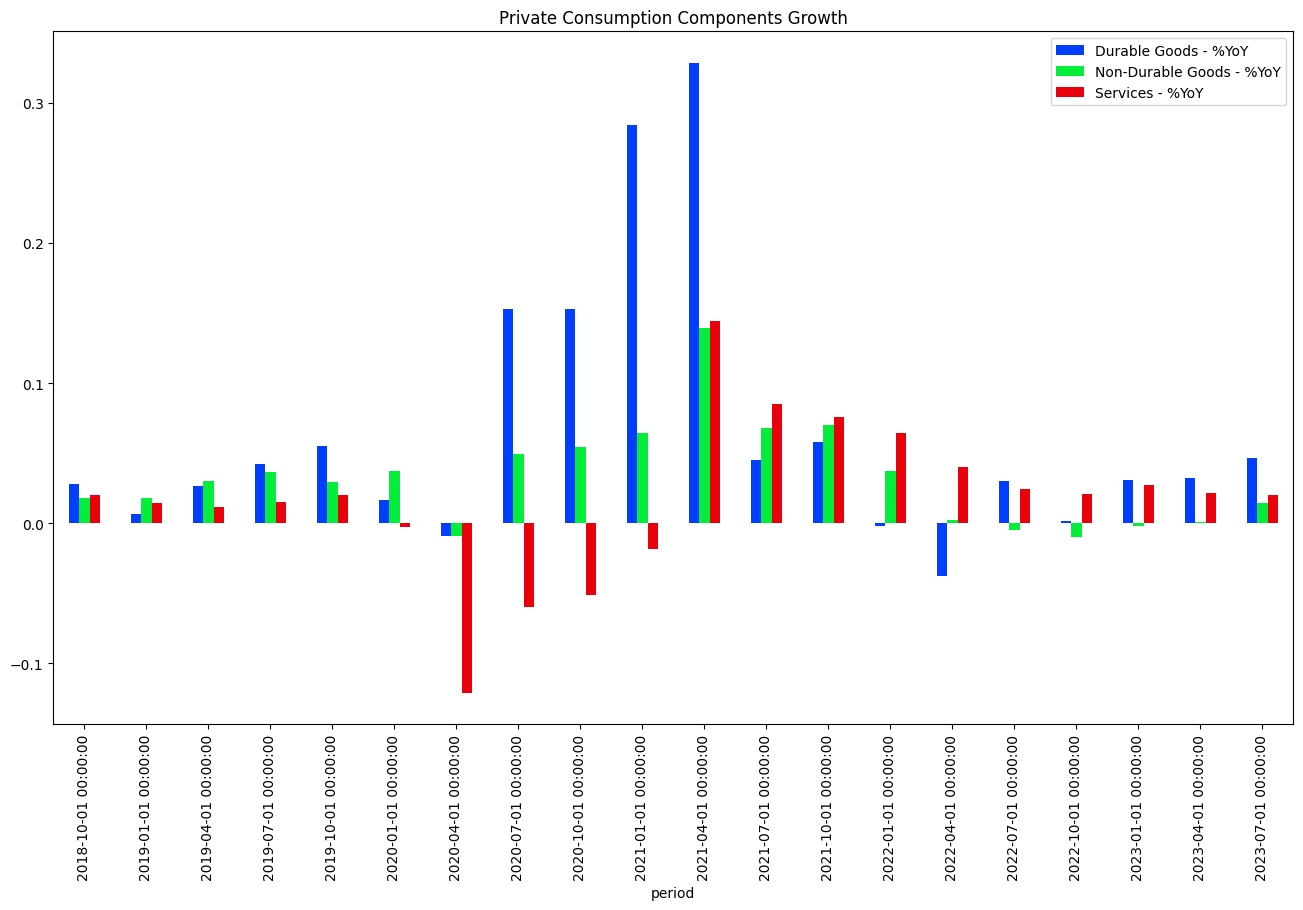

In [ ]:
#Plot the Y-o-Y growth of main Private Consumption components
priv_cons_comp_gth[['Durable Goods - %YoY',
                    'Non-Durable Goods - %YoY',
                    'Services - %YoY']].\
                    iloc[-20:].plot(kind = 'bar', figsize=(16,9))
plt.title('Private Consumption Components Growth')
plt.show()

In [ ]:
priv_cons_comp_gth.tail()

Durable Goods - %YoY  Non-Durable Goods - %YoY  Services - %YoY  \
period                                                                        
2022-07-01              0.030468                 -0.004598         0.024587   
2022-10-01              0.001282                 -0.009705         0.021025   
2023-01-01              0.030684                 -0.001681         0.027318   
2023-04-01              0.032232                  0.000621         0.021636   
2023-07-01              0.046667                  0.014335         0.020295   

            Other - %YoY  
period                    
2022-07-01      0.036829  
2022-10-01     -0.044728  
2023-01-01      0.085705  
2023-04-01      0.093009  
2023-07-01      0.172272

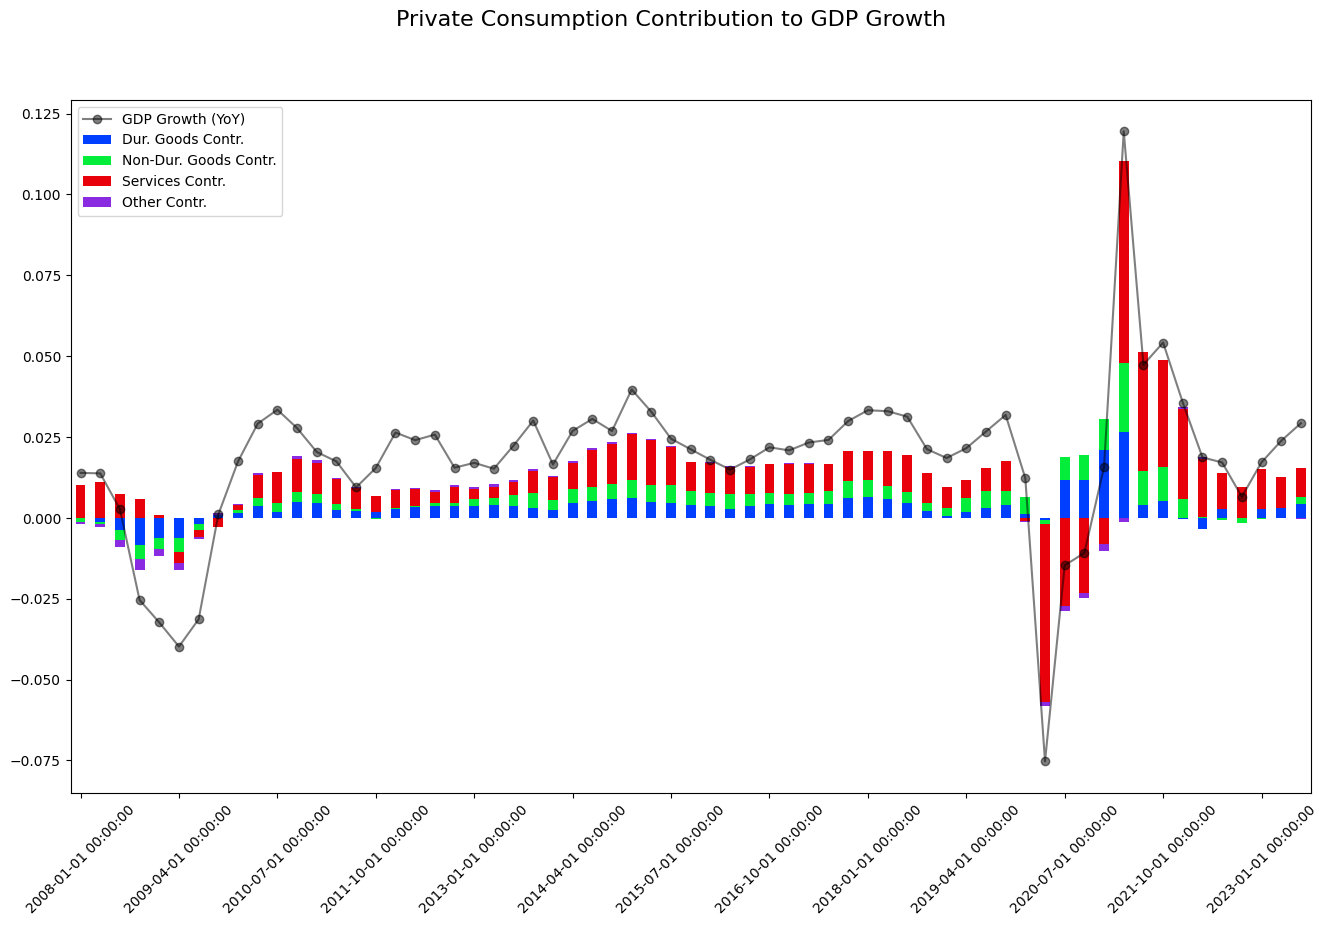

In [ ]:
#Plot the contribution of Private Consumption main components to GDP growth and output evolution
fig, ax1 = plt.subplots(figsize = (16, 9))

df_to_plot_1[['Dur. Goods Contr.',
              'Non-Dur. Goods Contr.',
              'Services Contr.',
              'Other Contr.']].\
         plot(kind = 'bar', stacked = True, ax = ax1)
df_to_plot_1['GDP Growth (YoY)'].plot(linestyle='-', marker='o', color='black', alpha=0.5, ax = ax1, legend=True)
leg = plt.legend(loc='upper left')
ax1.set_xticklabels(labels = df_to_plot_1['period'], rotation=45)
ax1.set_xticks(np.arange(0, len(df_to_plot_1)+1, 5))

plt.suptitle('Private Consumption Contribution to GDP Growth', size =16)
plt.show()

In [ ]:
priv_cons_comp_contr.tail()

GDP Growth (YoY)  Dur. Goods Contr.  Non-Dur. Goods Contr.  \
period                                                                   
2022-07-01          0.017132           0.002701              -0.000714   
2022-10-01          0.006517           0.000115              -0.001491   
2023-01-01          0.017179           0.002770              -0.000258   
2023-04-01          0.023825           0.002907               0.000095   
2023-07-01          0.029269           0.004191               0.002178   

            Services Contr.  Other Contr.  
period                                     
2022-07-01         0.011034     -0.000054  
2022-10-01         0.009352      0.000069  
2023-01-01         0.012231     -0.000132  
2023-04-01         0.009778     -0.000141  
2023-07-01         0.009175     -0.000259

In [ ]:
#Fetch Private Investments series for GFCF analysis
priv_inv = fetch_series('OECD/QNA/USA.P51S1LESSS13.LNBARSA.Q')
priv_inv = clean_data(priv_inv, 'Private Investments - Q')
priv_inv.head()

Private Investments - Q
period                             
2007-01-01                2786977.0
2007-04-01                2800103.0
2007-07-01                2784117.0
2007-10-01                2757412.0
2008-01-01                2714675.0

In [ ]:
#Fetch Government Investments series for GFCF analysis
gov_inv = fetch_series('OECD/QNA/USA.P51S13.LNBARSA.Q')
gov_inv = clean_data(gov_inv, 'Government Investments - Q')
gov_inv.head()

Government Investments - Q
period                                
2007-01-01                    676167.0
2007-04-01                    689161.0
2007-07-01                    691062.0
2007-10-01                    699409.0
2008-01-01                    697388.0

In [ ]:
#Merge Real GDP data with components of GFCF
gfcf_comp = pd.concat([real_gdp['Real GDP'], priv_inv, gov_inv], axis=1)
gfcf_comp = gfcf_comp.dropna()
gfcf_comp.head()

Real GDP  Private Investments - Q  Government Investments - Q
period                                                                     
2007-01-01  16611690.0                2786977.0                    676167.0
2007-04-01  16713314.0                2800103.0                    689161.0
2007-07-01  16809587.0                2784117.0                    691062.0
2007-10-01  16915191.0                2757412.0                    699409.0
2008-01-01  16843003.0                2714675.0                    697388.0

In [ ]:
#Calculate contribution of GFCF components to GDP growth
gfcf_comp_contr = pd.DataFrame()
gfcf_comp_contr['GDP Growth (YoY)'] = gfcf_comp['Real GDP'].pct_change(4)
gfcf_comp_contr['Private Investments Contr.'] = gfcf_comp['Private Investments - Q'].diff(4) / gfcf_comp['Real GDP'].shift(4)
gfcf_comp_contr['Government Investments Contr.'] = gfcf_comp['Government Investments - Q'].diff(4) / gfcf_comp['Real GDP'].shift(4)
gfcf_comp_contr = gfcf_comp_contr.dropna()
gfcf_comp_contr.head()

GDP Growth (YoY)  Private Investments Contr.  \
period                                                     
2008-01-01          0.013925                   -0.004352   
2008-04-01          0.013760                   -0.006442   
2008-07-01          0.002660                   -0.009503   
2008-10-01         -0.025412                   -0.018109   
2009-01-01         -0.032342                   -0.027220   

            Government Investments Contr.  
period                                     
2008-01-01                       0.001277  
2008-04-01                       0.001278  
2008-07-01                       0.001420  
2008-10-01                       0.000685  
2009-01-01                       0.000635

In [ ]:
#The following dataframe is identical to the above one, but with the "period" index set as a column instead of as the index. This is done simply to plot it below in a combined chart
df_to_plot_2 = gfcf_comp_contr.reset_index()
df_to_plot_2.head()

period  GDP Growth (YoY)  Private Investments Contr.  \
0 2008-01-01          0.013925                   -0.004352   
1 2008-04-01          0.013760                   -0.006442   
2 2008-07-01          0.002660                   -0.009503   
3 2008-10-01         -0.025412                   -0.018109   
4 2009-01-01         -0.032342                   -0.027220   

   Government Investments Contr.  
0                       0.001277  
1                       0.001278  
2                       0.001420  
3                       0.000685  
4                       0.000635

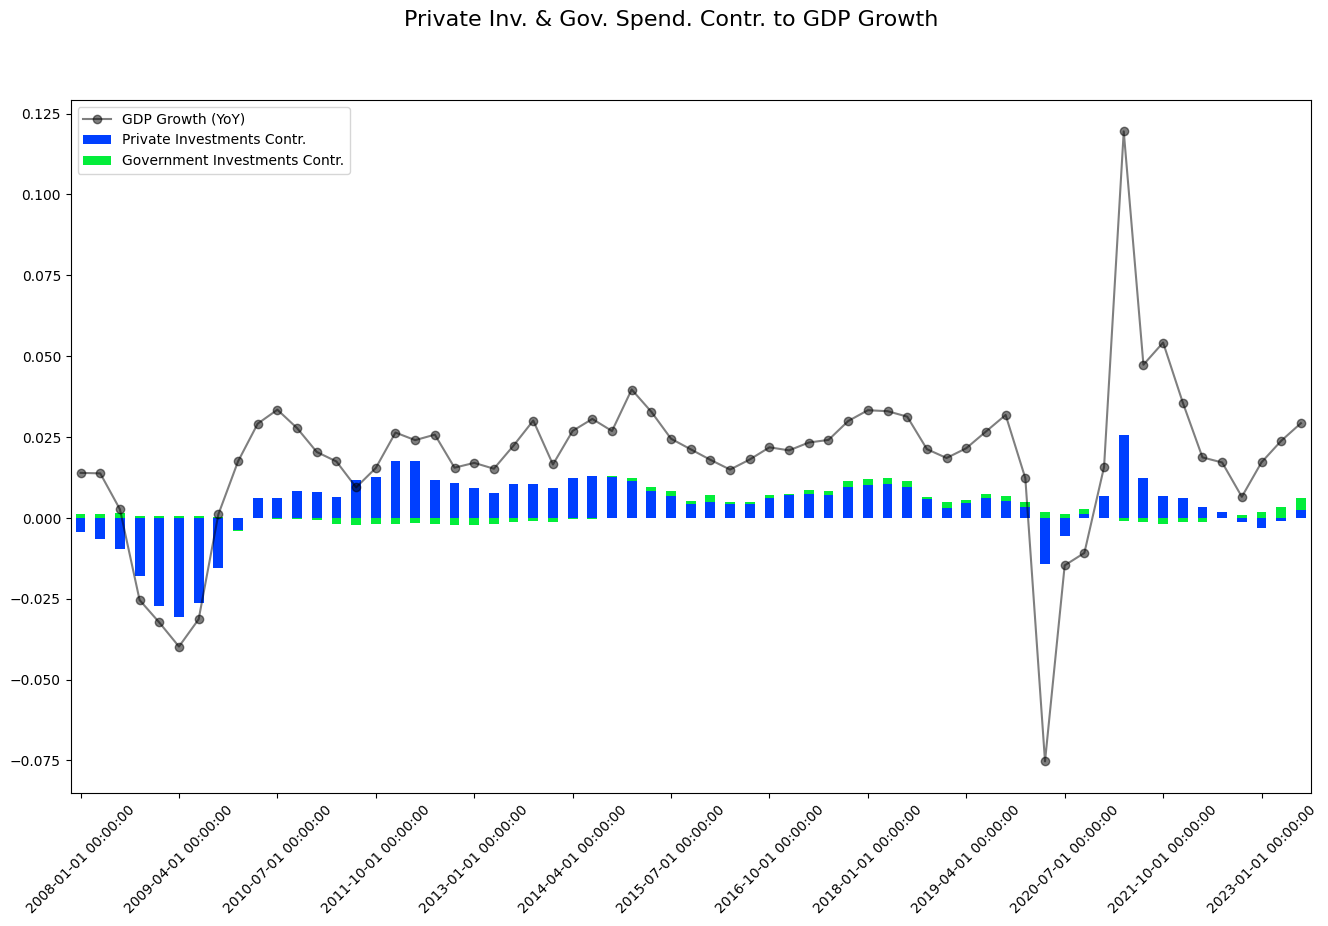

In [ ]:
#Plot the contribution of GFCF components to GDP growth and output evolution
fig, ax1 = plt.subplots(figsize = (16, 9))

df_to_plot_2[['Private Investments Contr.',
              'Government Investments Contr.']].\
         plot(kind = 'bar', stacked = True, ax = ax1)
df_to_plot_2['GDP Growth (YoY)'].plot(linestyle='-', marker='o', color='black', alpha=0.5, ax = ax1, legend=True)
leg = plt.legend(loc='upper left')
ax1.set_xticklabels(labels = df_to_plot_2['period'], rotation=45)
ax1.set_xticks(np.arange(0, len(df_to_plot_2)+1, 5))

plt.suptitle('Private Inv. & Gov. Spend. Contr. to GDP Growth', size=16)
plt.show()

In [ ]:
#Let's retrieve data on retail sales from the economic calendar
ret_sales_mom = eco_cal_data_pct(event='Retail Sales (MoM)')
core_ret_sales_mom = eco_cal_data_pct(event='Core Retail Sales (MoM)')

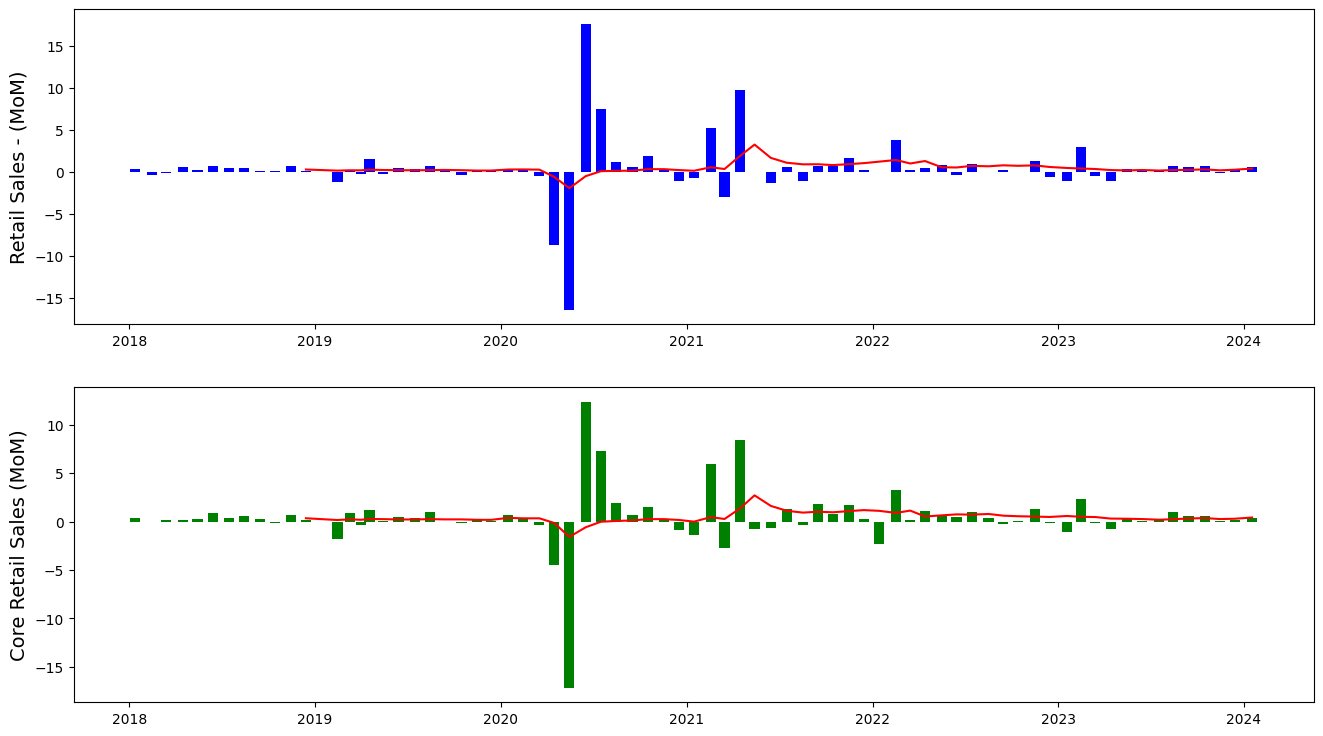

In [ ]:
#Let's plot retail sales data
fig, axs = plt.subplots(2, 1, figsize=(16, 9))
axs[0].bar(ret_sales_mom.index, ret_sales_mom['Retail Sales (MoM)'], width=20, color='b')
axs[0].plot(ret_sales_mom['Retail Sales (MoM)'].rolling(12).mean(), color='r')
axs[0].set_ylabel('Retail Sales - (MoM)', fontsize=14)
axs[1].bar(core_ret_sales_mom.index, core_ret_sales_mom['Core Retail Sales (MoM)'], width=20, color='g')
axs[1].plot(core_ret_sales_mom['Core Retail Sales (MoM)'].rolling(12).mean(), color='r')
axs[1].set_ylabel('Core Retail Sales (MoM)', fontsize=14)

plt.show()

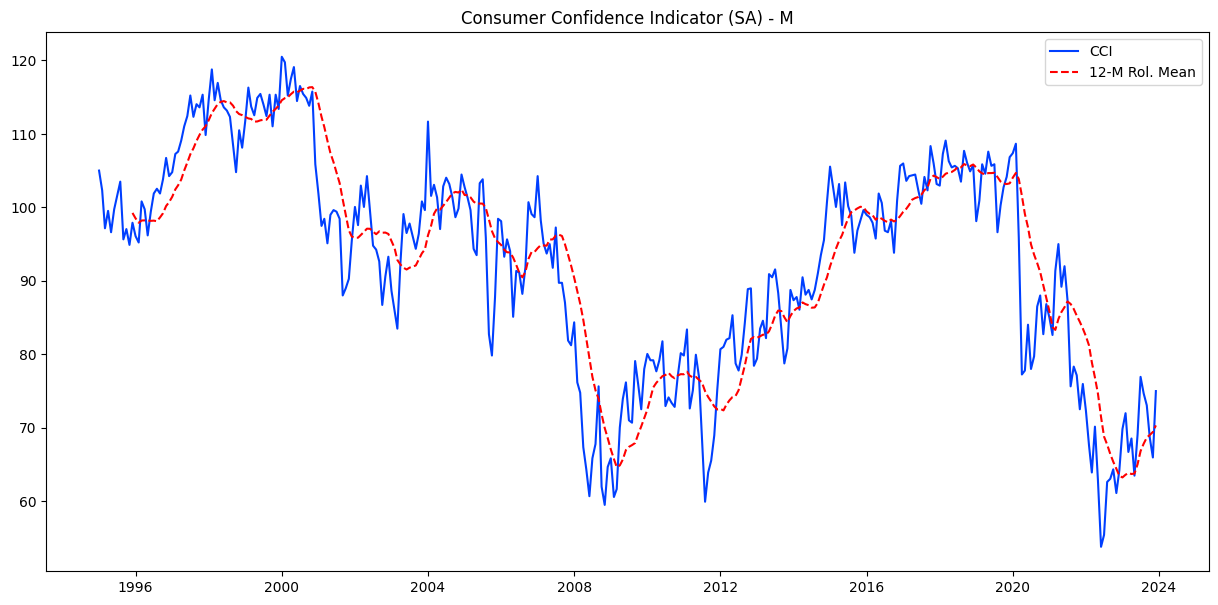

In [ ]:
#Fetch Consumer Confidence Indicator data
cci = fetch_series('OECD/KEI/CSCICP02.USA.ST.M')
cci = clean_data(cci, 'Consumer Confidence Indicator (SA) - M')

#Plot Consumer Confidence Indicator data
plt.figure(figsize=(15,7))
plt.plot(cci)
plt.plot(cci.rolling(12).mean(), color='r', linestyle='--')
plt.title('Consumer Confidence Indicator (SA) - M')
plt.legend(['CCI', '12-M Rol. Mean'])
plt.show()

In [ ]:
cci.tail()

Consumer Confidence Indicator (SA) - M
period                                            
2023-08-01                               74.670492
2023-09-01                               73.056577
2023-10-01                               68.645208
2023-11-01                               65.955348
2023-12-01                               74.993275

# Section 4: Inflation Analysis

In this section our goal is to assess actual and expected inflation pressures from different perspectives. In fact, after analyzing different measures of inflations (CPI vs GDP Deflator), we will have a look at 10-year forward expectations (based on the 5y, 5y Fwd Inflation Expectation indicator) and then going deeper on inflation components performances. Then we will have a look at headline versus less volatile core inflation and, finally, we will assess wages and salaries trends, as well as base metals movements.  

In [ ]:
#Fetch monthly inflation rate (YoY chg) series
cpi_yoy_m = fetch_series('IMF/CPI/M.US.PCPI_PC_CP_A_PT')
cpi_yoy_m = clean_data(cpi_yoy_m, 'Inflation Rate YoY - (M)')
cpi_yoy_m['Target'] = 2
cpi_yoy_m.tail()

Inflation Rate YoY - (M)  Target
period                                      
2023-08-01                  3.665112       2
2023-09-01                  3.699698       2
2023-10-01                  3.241145       2
2023-11-01                  3.137271       2
2023-12-01                  3.352123       2

In [ ]:
#Fetch monthly inflation rate (MoM chg) series
cpi_mom_m = fetch_series('IMF/CPI/M.US.PCPI_PC_PP_PT')
cpi_mom_m = clean_data(cpi_mom_m, 'Inflation Rate MoM - (M)')
cpi_mom_m['Rolling 12-M Avg'] = cpi_mom_m['Inflation Rate MoM - (M)'].rolling(12).mean()
cpi_mom_m.tail()

Inflation Rate MoM - (M)  Rolling 12-M Avg
period                                                
2023-08-01                  0.436716          0.300804
2023-09-01                  0.248513          0.303590
2023-10-01                 -0.038338          0.266591
2023-11-01                 -0.201514          0.258215
2023-12-01                 -0.099332          0.275521

In [ ]:
#Fetch GDP deflator time series to compare an inflation indicator with a broader basket of goods and services, but that doesn't take into account imported inflation
gdp_defl = fetch_series('OECD/MEI/USA.NAGIGP01.IXOBSA.Q')
gdp_defl = clean_data(gdp_defl, 'GDP Deflator')
gdp_defl['GDP Deflator YoY - (Q)'] = gdp_defl['GDP Deflator'] / gdp_defl['GDP Deflator'].shift(4) - 1
gdp_defl['GDP Deflator QoQ - (Q)'] = gdp_defl['GDP Deflator'].pct_change()
gdp_defl = gdp_defl.dropna()
gdp_defl.tail()

GDP Deflator  GDP Deflator YoY - (Q)  GDP Deflator QoQ - (Q)
period                                                                  
2022-07-01    122.243581                0.072509                0.010972
2022-10-01    123.405231                0.064200                0.009503
2023-01-01    124.605413                0.053203                0.009726
2023-04-01    125.124909                0.034801                0.004169
2023-07-01    126.148431                0.031943                0.008180

In [ ]:
#Fetch 5-Year, 5-Year Forward Inflation Expectation Rate to assess future path of inflation
five_y_fwd_i_exp = quandl.get("FRED/T5YIFR", authtoken=api_key)
five_y_fwd_i_exp = five_y_fwd_i_exp.rename(columns={'Value':'5-y, 5-y Fwd Infl. Exp.'})
five_y_fwd_i_exp.tail()

5-y, 5-y Fwd Infl. Exp.
Date                               
2022-07-12                     2.14
2022-07-13                     2.11
2022-07-14                     2.14
2022-07-15                     2.13
2022-07-18                     2.11

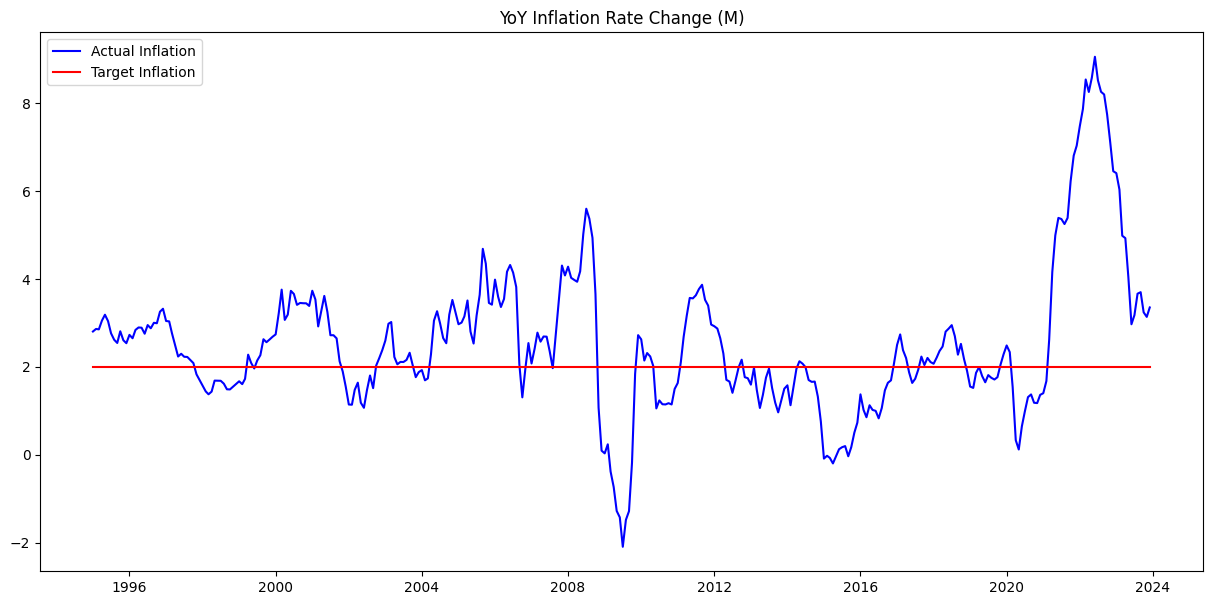

In [ ]:
#Plot YoY monthly inflation change
plt.figure(figsize=(15,7))
plt.plot(cpi_yoy_m['Inflation Rate YoY - (M)'], color='blue')
plt.plot(cpi_yoy_m['Target'], color='red')
plt.legend(['Actual Inflation', 'Target Inflation'])
plt.title('YoY Inflation Rate Change (M)')
plt.show()

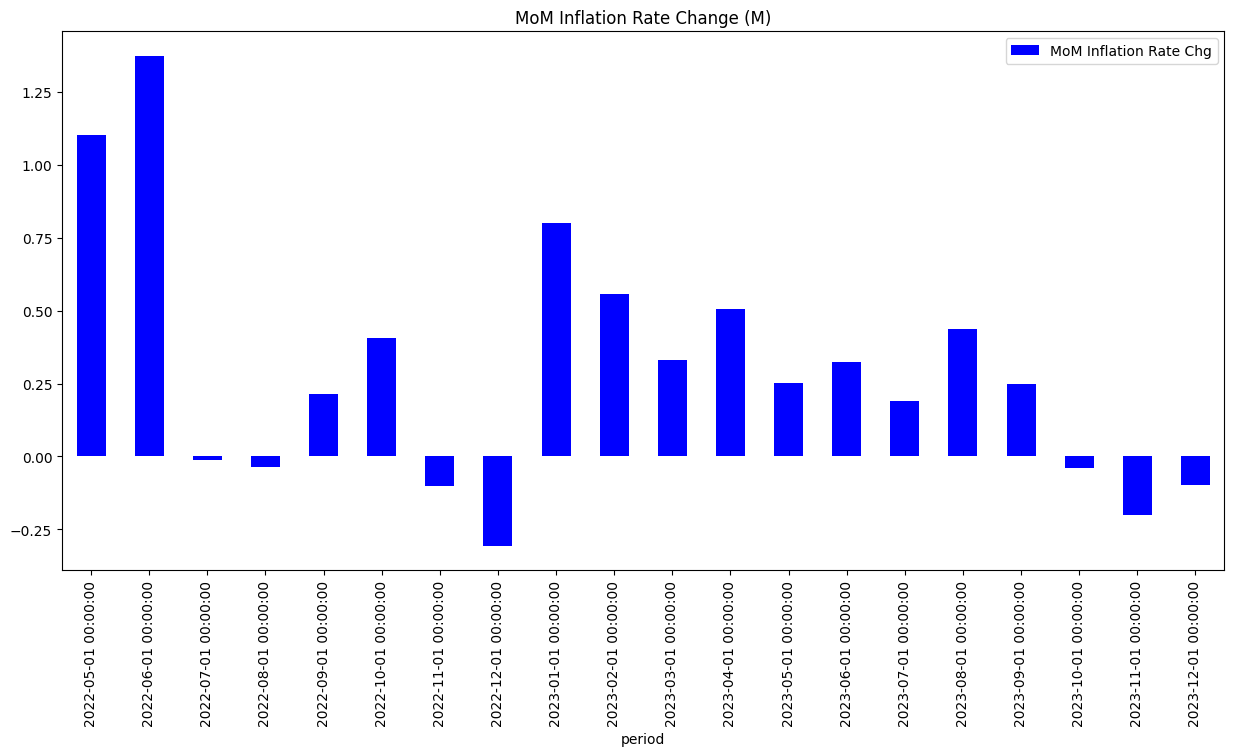

In [ ]:
#Plot MoM monthly inflation change
cpi_mom_m['Inflation Rate MoM - (M)'].iloc[-20:].plot(kind='bar', color='blue', figsize=(15,7))
plt.legend(['MoM Inflation Rate Chg'])
plt.title('MoM Inflation Rate Change (M)')
plt.show()

In [ ]:
#Loading the Global Supply Chain Pressure index data
gscpi = pd.read_excel('/content/2022_Barometer-Global-Supply-Chain-Pressures_data.xlsx',
                      sheet_name='GSCPI',
                      parse_dates=True,
                      index_col=0,
                      skiprows=4)
gscpi = gscpi.iloc[: , :-2]
gscpi.columns = ['GSCPI']

gscpi.head()

GSCPI
1997-09-30 -0.491379
1997-10-31 -0.176291
1997-11-30 -0.459300
1997-12-31 -0.831952
1998-01-31 -0.939995

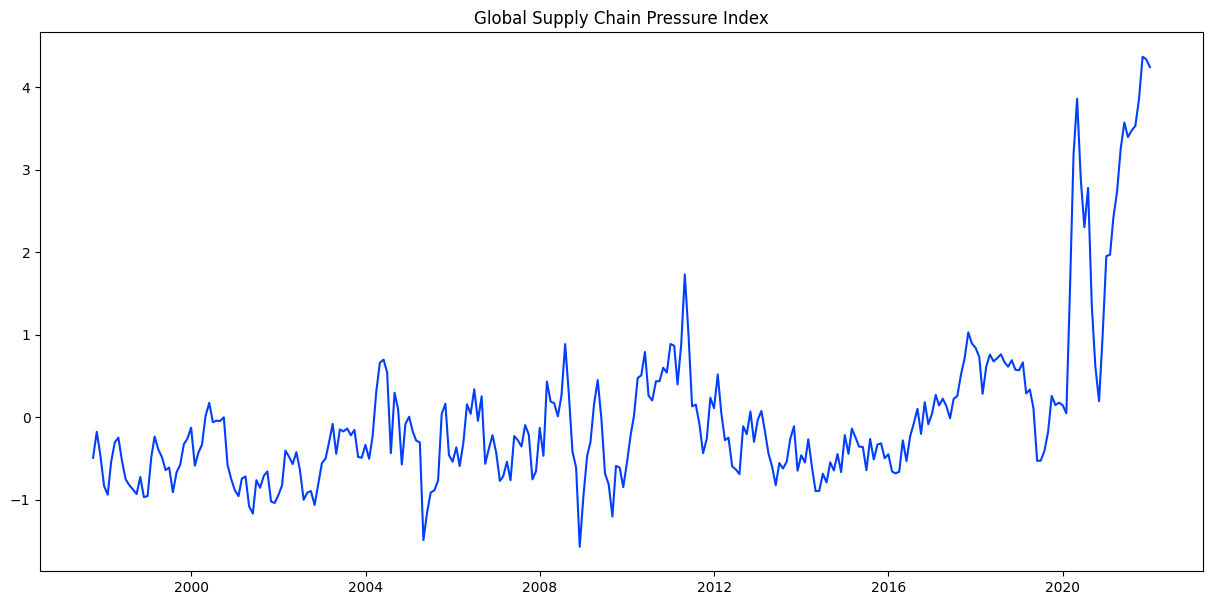

In [ ]:
#Plotting the Global Supply Chain Pressure index data
plt.figure(figsize=(15,7))
plt.plot(gscpi)
plt.title('Global Supply Chain Pressure Index')
plt.show()

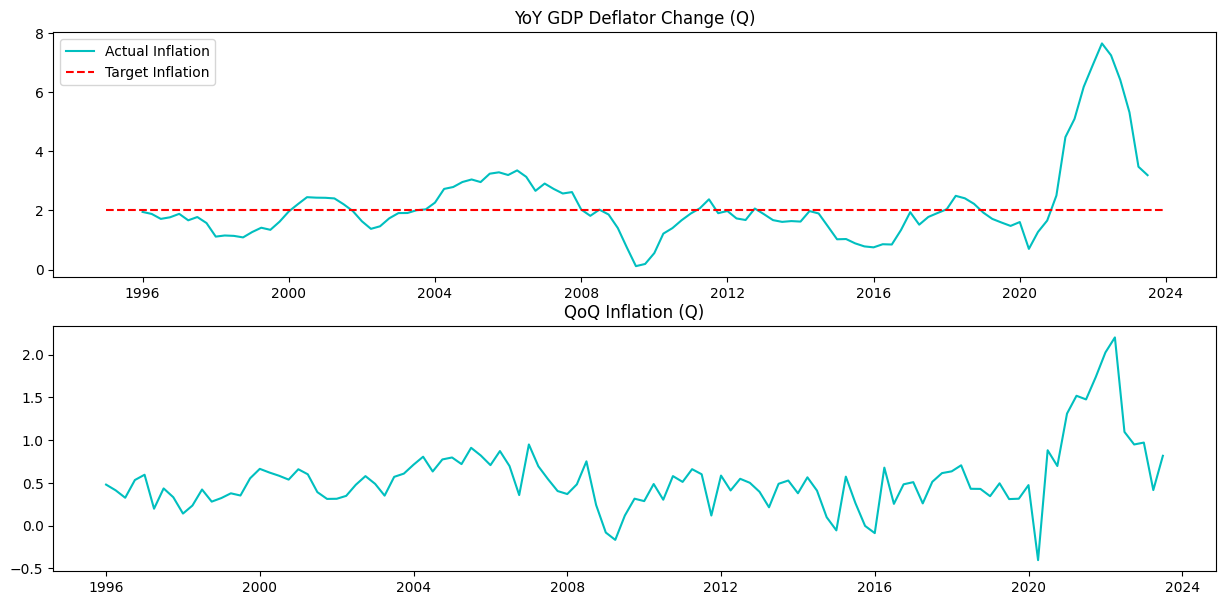

In [ ]:
#Plot quarterly inflation rate (GDP deflator) on a YoY and QoQ base
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.plot((gdp_defl['GDP Deflator YoY - (Q)'] * 100), color='c')
plt.plot(cpi_yoy_m['Target'], color='red', linestyle='--')
plt.title('YoY GDP Deflator Change (Q)')
plt.legend(['Actual Inflation', 'Target Inflation'])
plt.subplot(212)
plt.plot((gdp_defl['GDP Deflator QoQ - (Q)'] * 100), color='c')
plt.title('QoQ Inflation (Q)')
plt.show()

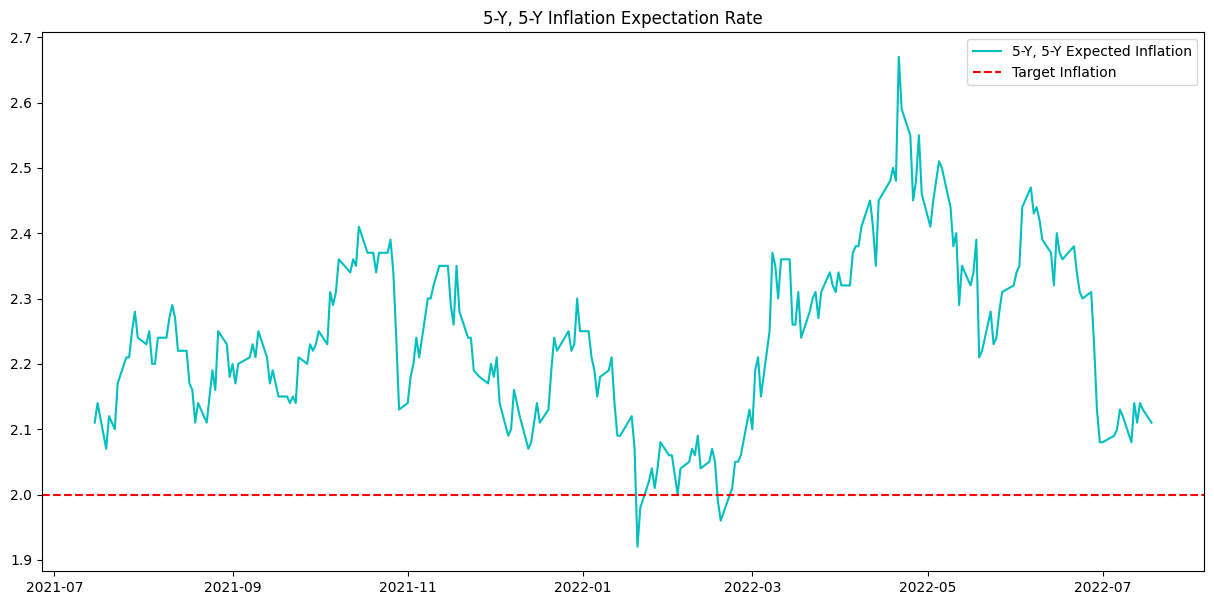

In [ ]:
#Plot the measure of expected inflation (on average) over the five-year period that begins five years from today
plt.figure(figsize=(15,7))
plt.plot(five_y_fwd_i_exp[-252:], color='c')
plt.axhline(y=2, color='red', linestyle='--')
plt.title('5-Y, 5-Y Inflation Expectation Rate')
plt.legend(['5-Y, 5-Y Expected Inflation', 'Target Inflation'])
plt.show()

In [ ]:
#Let's fetch CPI weights data and store them in a dataframe
w = ['IMF/CPI/M.US.PCPIA_WT_PT',
     'IMF/CPI/M.US.PCPIEC_WT_PT',
     'IMF/CPI/M.US.PCPIED_WT_PT',
     'IMF/CPI/M.US.PCPIFBT_WT_PT',
     'IMF/CPI/M.US.PCPIF_WT_PT',
     'IMF/CPI/M.US.PCPIHO_WT_PT',
     'IMF/CPI/M.US.PCPIH_WT_PT',
     'IMF/CPI/M.US.PCPIM_WT_PT',
     'IMF/CPI/M.US.PCPIO_WT_PT',
     'IMF/CPI/M.US.PCPIRE_WT_PT',
     'IMF/CPI/M.US.PCPIT_WT_PT',
     'IMF/CPI/M.US.PCPIR_WT_PT']



cpi_weights = pd.DataFrame()

for i in w:
    cpi_weights = cpi_weights.append(fetch_series(i)[['period', 'series_name', 'value']])


cpi_weights = cpi_weights.pivot(index='period', columns='series_name', values='value')
cpi_weights.head()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics, Weight, Percent  \
period                                                                                                
1998-01-01                                            1.516598                                        
1998-02-01                                            1.516598                                        
1998-03-01                                            1.516598                                        
1998-04-01                                            1.516598                                        
1998-05-01                                            1.516598                                        

series_name  Monthly – United States – Clothing and footwear, Weight, Percent  \
period                                                                          
1998-01-01                                            4.837151                  
1998-02-01                                            4.837151                  
1998-03-01                                            4.837151                  
1998-04-01                                            4.837151                  
1998-05-01                                            4.837151                  

series_name  Monthly – United States – Communication, Weight, Percent  \
period                                                                  
1998-01-01                                            2.635551          
1998-02-01                                            2.635551          
1998-03-01                                            2.635551          
1998-04-01                                            2.635551          
1998-05-01                                            2.635551          

series_name  Monthly – United States – Education, Weight, Percent  \
period                                                              
1998-01-01                                             2.34987      
1998-02-01                                             2.34987      
1998-03-01                                             2.34987      
1998-04-01                                             2.34987      
1998-05-01                                             2.34987      

series_name  Monthly – United States – Food and non-alcoholic beverages, Weight, Percent  \
period                                                                                     
1998-01-01                                            9.645973                             
1998-02-01                                            9.645973                             
1998-03-01                                            9.645973                             
1998-04-01                                            9.645973                             
1998-05-01                                            9.645973                             

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance, Weight, Percent  \
period                                                                                                                       
1998-01-01                                             4.04256                                                               
1998-02-01                                             4.04256                                                               
1998-03-01                                             4.04256                                                               
1998-04-01                                             4.04256                                                               
1998-05-01                                             4.04256                                                               

series_name  Monthly – United States – Health, Weight, Percent  \
period                                                           
1998-01-01                                            

In [ ]:
#Check that time series downloaded are correct
for col_name in cpi_weights.columns:
    print(col_name)

Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics, Weight, Percent
Monthly – United States – Clothing and footwear, Weight, Percent
Monthly – United States – Communication, Weight, Percent
Monthly – United States – Education, Weight, Percent
Monthly – United States – Food and non-alcoholic beverages, Weight, Percent
Monthly – United States – Furnishings, household equipment and routine household maintenance, Weight, Percent
Monthly – United States – Health, Weight, Percent
Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels, Weight, Percent
Monthly – United States – Miscellaneous goods and services, Weight, Percent
Monthly – United States – Recreation and culture, Weight, Percent
Monthly – United States – Restaurants and hotels, Weight, Percent
Monthly – United States – Transport, Weight, Percent


In [ ]:
#Let's fetch CPI weights data and store them in a dataframe
ix = ['IMF/CPI/M.US.PCPIA_IX',
     'IMF/CPI/M.US.PCPIEC_IX',
     'IMF/CPI/M.US.PCPIED_IX',
     'IMF/CPI/M.US.PCPIFBT_IX',
     'IMF/CPI/M.US.PCPIF_IX',
     'IMF/CPI/M.US.PCPIHO_IX',
     'IMF/CPI/M.US.PCPIH_IX',
     'IMF/CPI/M.US.PCPIM_IX',
     'IMF/CPI/M.US.PCPIO_IX',
     'IMF/CPI/M.US.PCPIRE_IX',
     'IMF/CPI/M.US.PCPIT_IX',
     'IMF/CPI/M.US.PCPIR_IX']



cpi_indices = pd.DataFrame()

for i in ix:
    cpi_indices = cpi_indices.append(fetch_series(i)[['period', 'series_name', 'value']])


cpi_indices = cpi_indices.pivot(index='period', columns='series_name', values='value')
cpi_indices.head()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
1955-01-01                                                 NaN                       
1955-02-01                                                 NaN                       
1955-03-01                                                 NaN                       
1955-04-01                                                 NaN                       
1955-05-01                                                 NaN                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
1955-01-01                                               NaN   
1955-02-01                                               NaN   
1955-03-01                                               NaN   
1955-04-01                                               NaN   
1955-05-01                                               NaN   

series_name  Monthly – United States – Communication  \
period                                                 
1955-01-01                                       NaN   
1955-02-01                                       NaN   
1955-03-01                                       NaN   
1955-04-01                                       NaN   
1955-05-01                                       NaN   

series_name  Monthly – United States – Education  \
period                                             
1955-01-01                                   NaN   
1955-02-01                                   NaN   
1955-03-01                                   NaN   
1955-04-01                                   NaN   
1955-05-01                                   NaN   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
1955-01-01                                           13.621482            
1955-02-01                                           13.667812            
1955-03-01                                           13.667812            
1955-04-01                                           13.714142            
1955-05-01                                           13.714142            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
1955-01-01                                                 NaN                                              
1955-02-01                                                 NaN                                              
1955-03-01                                                 NaN                                              
1955-04-01                                                 NaN                                              
1955-05-01                                                 NaN                                              

series_name  Monthly – United States – Health  \
period                                          
1955-01-01                                NaN   
1955-02-01                                NaN   
1955-03-01                                NaN   
1955-04-01                                NaN   
1955-05-01                                NaN   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
1955-01-01                                                 NaN                            
1955-02-01                                                 NaN                            
1955-03-01                                                 NaN                            
1955-04-01                                                 NaN                            
1955-05-01

In [ ]:
#Check that time series downloaded are correct
for col_name in cpi_indices.columns:
    print(col_name)

Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics
Monthly – United States – Clothing and footwear
Monthly – United States – Communication
Monthly – United States – Education
Monthly – United States – Food and non-alcoholic beverages
Monthly – United States – Furnishings, household equipment and routine household maintenance
Monthly – United States – Health
Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels
Monthly – United States – Miscellaneous goods and services
Monthly – United States – Recreation and culture
Monthly – United States – Restaurants and hotels
Monthly – United States – Transport


In [ ]:
#Rename columns in cpi_weights as in cpi_indices to allow elementwise multiplication later
cpi_weights.columns=cpi_indices.columns
cpi_weights.head()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
1998-01-01                                            1.516598                       
1998-02-01                                            1.516598                       
1998-03-01                                            1.516598                       
1998-04-01                                            1.516598                       
1998-05-01                                            1.516598                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
1998-01-01                                          4.837151   
1998-02-01                                          4.837151   
1998-03-01                                          4.837151   
1998-04-01                                          4.837151   
1998-05-01                                          4.837151   

series_name  Monthly – United States – Communication  \
period                                                 
1998-01-01                                  2.635551   
1998-02-01                                  2.635551   
1998-03-01                                  2.635551   
1998-04-01                                  2.635551   
1998-05-01                                  2.635551   

series_name  Monthly – United States – Education  \
period                                             
1998-01-01                               2.34987   
1998-02-01                               2.34987   
1998-03-01                               2.34987   
1998-04-01                               2.34987   
1998-05-01                               2.34987   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
1998-01-01                                            9.645973            
1998-02-01                                            9.645973            
1998-03-01                                            9.645973            
1998-04-01                                            9.645973            
1998-05-01                                            9.645973            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
1998-01-01                                             4.04256                                              
1998-02-01                                             4.04256                                              
1998-03-01                                             4.04256                                              
1998-04-01                                             4.04256                                              
1998-05-01                                             4.04256                                              

series_name  Monthly – United States – Health  \
period                                          
1998-01-01                           5.314087   
1998-02-01                           5.314087   
1998-03-01                           5.314087   
1998-04-01                           5.314087   
1998-05-01                           5.314087   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
1998-01-01                                            34.02705                            
1998-02-01                                            34.02705                            
1998-03-01                                            34.02705                            
1998-04-01                                            34.02705                            
1998-05-01

In [ ]:
#Check that new columns names in cpi_weights are correct
for col_name in cpi_weights.columns:
    print(col_name)

Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics
Monthly – United States – Clothing and footwear
Monthly – United States – Communication
Monthly – United States – Education
Monthly – United States – Food and non-alcoholic beverages
Monthly – United States – Furnishings, household equipment and routine household maintenance
Monthly – United States – Health
Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels
Monthly – United States – Miscellaneous goods and services
Monthly – United States – Recreation and culture
Monthly – United States – Restaurants and hotels
Monthly – United States – Transport


In [ ]:
#Let's align the two dataframes on the same timeline, since we have data starting from Dec-19 for cpi_indices
cpi_weights = cpi_weights.loc['2010-01-01':]
cpi_indices = cpi_indices.loc['2010-01-01':]

In [ ]:
weights = cpi_weights.iloc[-1:].values.flatten().tolist()

weights_labels = ['Alcoholic Beverages Tobacco, and Narcotics', 'Clothing and footwear', 'Communication', 'Education', 'Food and non-alcoholic beverages', 'Furnishings, household equipment and routine household maintenance', 'Health', 'Housing, Water, Electricity, Gas and Other Fuels', 'Miscellaneous goods and services', 'Recreation and culture', 'Restaurants and hotels', 'Transport']



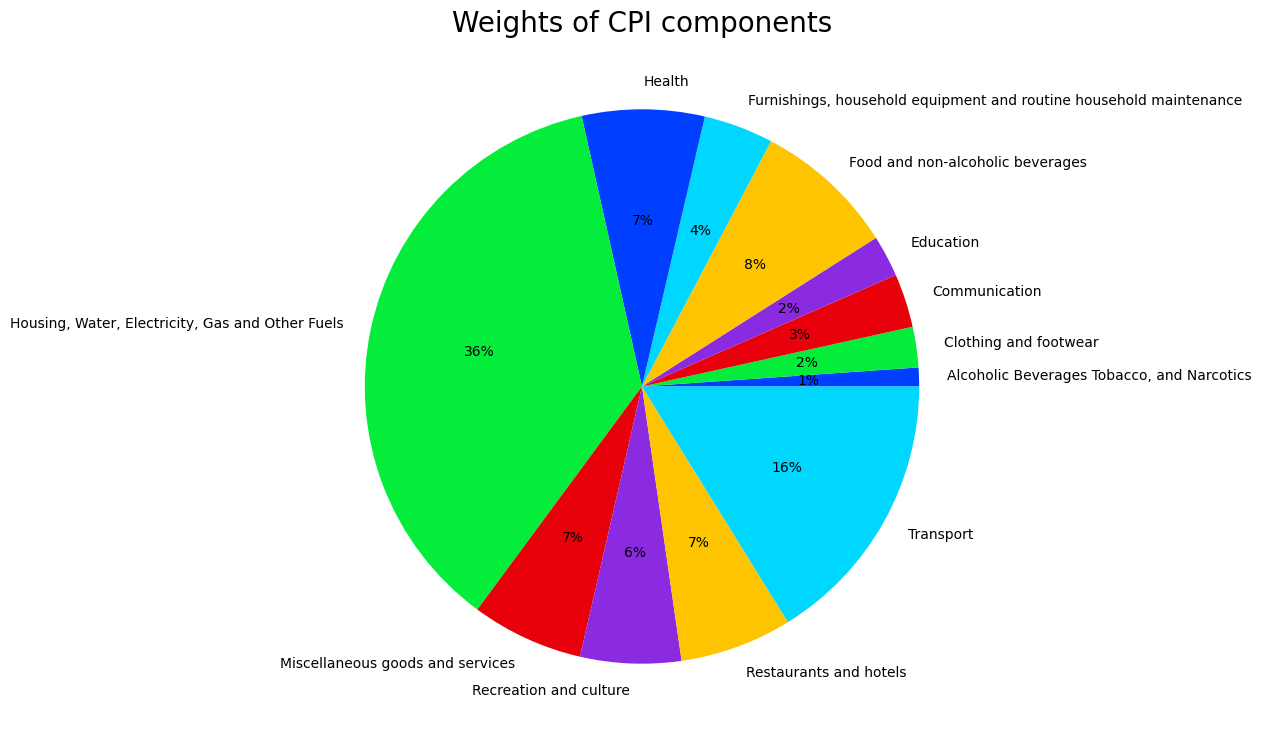

In [ ]:
#Let's plot a pie chart with weights for each CPI component
plt.figure(figsize=(16,9))
plt.pie(weights, labels=weights_labels, autopct='%.0f%%')
plt.title('Weights of CPI components', fontdict = {'fontsize' : 20})
plt.show()

In [ ]:
#Let's calculate annual CPI change by component
cpi_comp_chg_yoy = (cpi_indices / cpi_indices.shift(12)) - 1
cpi_comp_chg_yoy = cpi_comp_chg_yoy.dropna()
cpi_comp_chg_yoy.head()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
2011-01-01                                            0.032701                       
2011-02-01                                            0.035806                       
2011-03-01                                            0.035374                       
2011-04-01                                            0.033484                       
2011-05-01                                            0.023385                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
2011-01-01                                         -0.003891   
2011-02-01                                         -0.008273   
2011-03-01                                         -0.008557   
2011-04-01                                         -0.002687   
2011-05-01                                          0.004290   

series_name  Monthly – United States – Communication  \
period                                                 
2011-01-01                                 -0.008311   
2011-02-01                                 -0.007508   
2011-03-01                                 -0.007547   
2011-04-01                                 -0.008928   
2011-05-01                                 -0.010064   

series_name  Monthly – United States – Education  \
period                                             
2011-01-01                              0.041720   
2011-02-01                              0.041122   
2011-03-01                              0.039373   
2011-04-01                              0.037768   
2011-05-01                              0.039012   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
2011-01-01                                            0.021411            
2011-02-01                                            0.028463            
2011-03-01                                            0.036207            
2011-04-01                                            0.039381            
2011-05-01                                            0.044316            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
2011-01-01                                           -0.022869                                              
2011-02-01                                           -0.019691                                              
2011-03-01                                           -0.017824                                              
2011-04-01                                           -0.010248                                              
2011-05-01                                           -0.007365                                              

series_name  Monthly – United States – Health  \
period                                          
2011-01-01                           0.035318   
2011-02-01                           0.034917   
2011-03-01                           0.033347   
2011-04-01                           0.034301   
2011-05-01                           0.034847   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
2011-01-01                                            0.006533                            
2011-02-01                                            0.009314                            
2011-03-01                                            0.010273                            
2011-04-01                                            0.011728                            
2011-05-01

In [ ]:
#Let's calculate monthly CPI change by component
cpi_comp_chg_mom = (cpi_indices / cpi_indices.shift(1)) - 1
cpi_comp_chg_mom = cpi_comp_chg_mom.dropna()
cpi_comp_chg_mom.tail()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
2023-08-01                                            0.003935                       
2023-09-01                                            0.003003                       
2023-10-01                                            0.011020                       
2023-11-01                                            0.003650                       
2023-12-01                                           -0.000693                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
2023-08-01                                          0.019284   
2023-09-01                                          0.017170   
2023-10-01                                         -0.001430   
2023-11-01                                         -0.032339   
2023-12-01                                         -0.019897   

series_name  Monthly – United States – Communication  \
period                                                 
2023-08-01                                 -0.000552   
2023-09-01                                 -0.002527   
2023-10-01                                 -0.002022   
2023-11-01                                 -0.003765   
2023-12-01                                  0.001595   

series_name  Monthly – United States – Education  \
period                                             
2023-08-01                              0.007061   
2023-09-01                              0.008180   
2023-10-01                             -0.000742   
2023-11-01                             -0.000835   
2023-12-01                              0.000658   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
2023-08-01                                            0.000809            
2023-09-01                                            0.000608            
2023-10-01                                            0.002947            
2023-11-01                                           -0.005287            
2023-12-01                                           -0.000671            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
2023-08-01                                           -0.002094                                              
2023-09-01                                            0.002379                                              
2023-10-01                                            0.001229                                              
2023-11-01                                           -0.010262                                              
2023-12-01                                           -0.002224                                              

series_name  Monthly – United States – Health  \
period                                          
2023-08-01                           0.005364   
2023-09-01                           0.005382   
2023-10-01                           0.000685   
2023-11-01                           0.003141   
2023-12-01                           0.003550   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
2023-08-01                                            0.004514                            
2023-09-01                                            0.005464                            
2023-10-01                                            0.003422                            
2023-11-01                                            0.005333                            
2023-12-01

In [ ]:
#Fetch CPI Index data
cpi = fetch_series('IMF/CPI/M.US.PCPI_IX')
cpi = clean_data(cpi, 'CPI - All Items (M)')
cpi = cpi.loc['2010-01-01':]
cpi['CPI - YoY Chg. (M)'] = (cpi['CPI - All Items (M)'] / cpi['CPI - All Items (M)'].shift(12)) - 1
cpi.tail()

CPI - All Items (M)  CPI - YoY Chg. (M)
period                                             
2023-08-01           140.801768            0.036651
2023-09-01           141.151679            0.036997
2023-10-01           141.097565            0.032411
2023-11-01           140.813233            0.031373
2023-12-01           140.673361            0.033521

In [ ]:
#Calculate absolute contribution to inflation
cpi_abs_contr = cpi_comp_chg_yoy * (cpi_weights / 100) * \
                (cpi_indices.shift(12).divide(cpi['CPI - All Items (M)'].shift(12), axis='index'))
cpi_abs_contr = cpi_abs_contr.dropna()
cpi_abs_contr.tail()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
2023-08-01                                            0.000451                       
2023-09-01                                            0.000483                       
2023-10-01                                            0.000560                       
2023-11-01                                            0.000524                       
2023-12-01                                            0.000509                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
2023-08-01                                          0.000554   
2023-09-01                                          0.000514   
2023-10-01                                          0.000535   
2023-11-01                                          0.000260   
2023-12-01                                          0.000198   

series_name  Monthly – United States – Communication  \
period                                                 
2023-08-01                                  0.000117   
2023-09-01                                  0.000128   
2023-10-01                                  0.000118   
2023-11-01                                 -0.000261   
2023-12-01                                 -0.000279   

series_name  Monthly – United States – Education  \
period                                             
2023-08-01                              0.000674   
2023-09-01                              0.000434   
2023-10-01                              0.000394   
2023-11-01                              0.000307   
2023-12-01                              0.000288   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
2023-08-01                                            0.002413            
2023-09-01                                            0.001989            
2023-10-01                                            0.001718            
2023-11-01                                            0.001345            
2023-12-01                                            0.000984            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
2023-08-01                                            0.000389                                              
2023-09-01                                            0.000282                                              
2023-10-01                                            0.000305                                              
2023-11-01                                            0.000134                                              
2023-12-01                                           -0.000007                                              

series_name  Monthly – United States – Health  \
period                                          
2023-08-01                           0.001834   
2023-09-01                           0.001986   
2023-10-01                           0.002008   
2023-11-01                           0.002353   
2023-12-01                           0.002314   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
2023-08-01                                            0.024334                            
2023-09-01                                            0.023451                            
2023-10-01                                            0.022883                            
2023-11-01                                            0.023172                            
2023-12-01

In [ ]:
#Calculate relative contribution to inflation
cpi_rel_contr = cpi_abs_contr.divide(cpi['CPI - YoY Chg. (M)'], axis='index')
cpi_rel_contr = cpi_rel_contr.dropna()
cpi_rel_contr.tail()

series_name  Monthly – United States – Alcoholic Beverages, Tobacco, and Narcotics  \
period                                                                               
2023-08-01                                            0.012305                       
2023-09-01                                            0.013068                       
2023-10-01                                            0.017274                       
2023-11-01                                            0.016688                       
2023-12-01                                            0.015173                       

series_name  Monthly – United States – Clothing and footwear  \
period                                                         
2023-08-01                                          0.015106   
2023-09-01                                          0.013881   
2023-10-01                                          0.016514   
2023-11-01                                          0.008279   
2023-12-01                                          0.005901   

series_name  Monthly – United States – Communication  \
period                                                 
2023-08-01                                  0.003200   
2023-09-01                                  0.003454   
2023-10-01                                  0.003652   
2023-11-01                                 -0.008319   
2023-12-01                                 -0.008330   

series_name  Monthly – United States – Education  \
period                                             
2023-08-01                              0.018379   
2023-09-01                              0.011743   
2023-10-01                              0.012158   
2023-11-01                              0.009780   
2023-12-01                              0.008588   

series_name  Monthly – United States – Food and non-alcoholic beverages  \
period                                                                    
2023-08-01                                            0.065835            
2023-09-01                                            0.053764            
2023-10-01                                            0.052999            
2023-11-01                                            0.042866            
2023-12-01                                            0.029366            

series_name  Monthly – United States – Furnishings, household equipment and routine household maintenance  \
period                                                                                                      
2023-08-01                                            0.010625                                              
2023-09-01                                            0.007615                                              
2023-10-01                                            0.009406                                              
2023-11-01                                            0.004271                                              
2023-12-01                                           -0.000210                                              

series_name  Monthly – United States – Health  \
period                                          
2023-08-01                           0.050034   
2023-09-01                           0.053682   
2023-10-01                           0.061947   
2023-11-01                           0.074995   
2023-12-01                           0.069034   

series_name  Monthly – United States – Housing, Water, Electricity, Gas and Other Fuels  \
period                                                                                    
2023-08-01                                            0.663945                            
2023-09-01                                            0.633852                            
2023-10-01                                            0.706030                            
2023-11-01                                            0.738588                            
2023-12-01

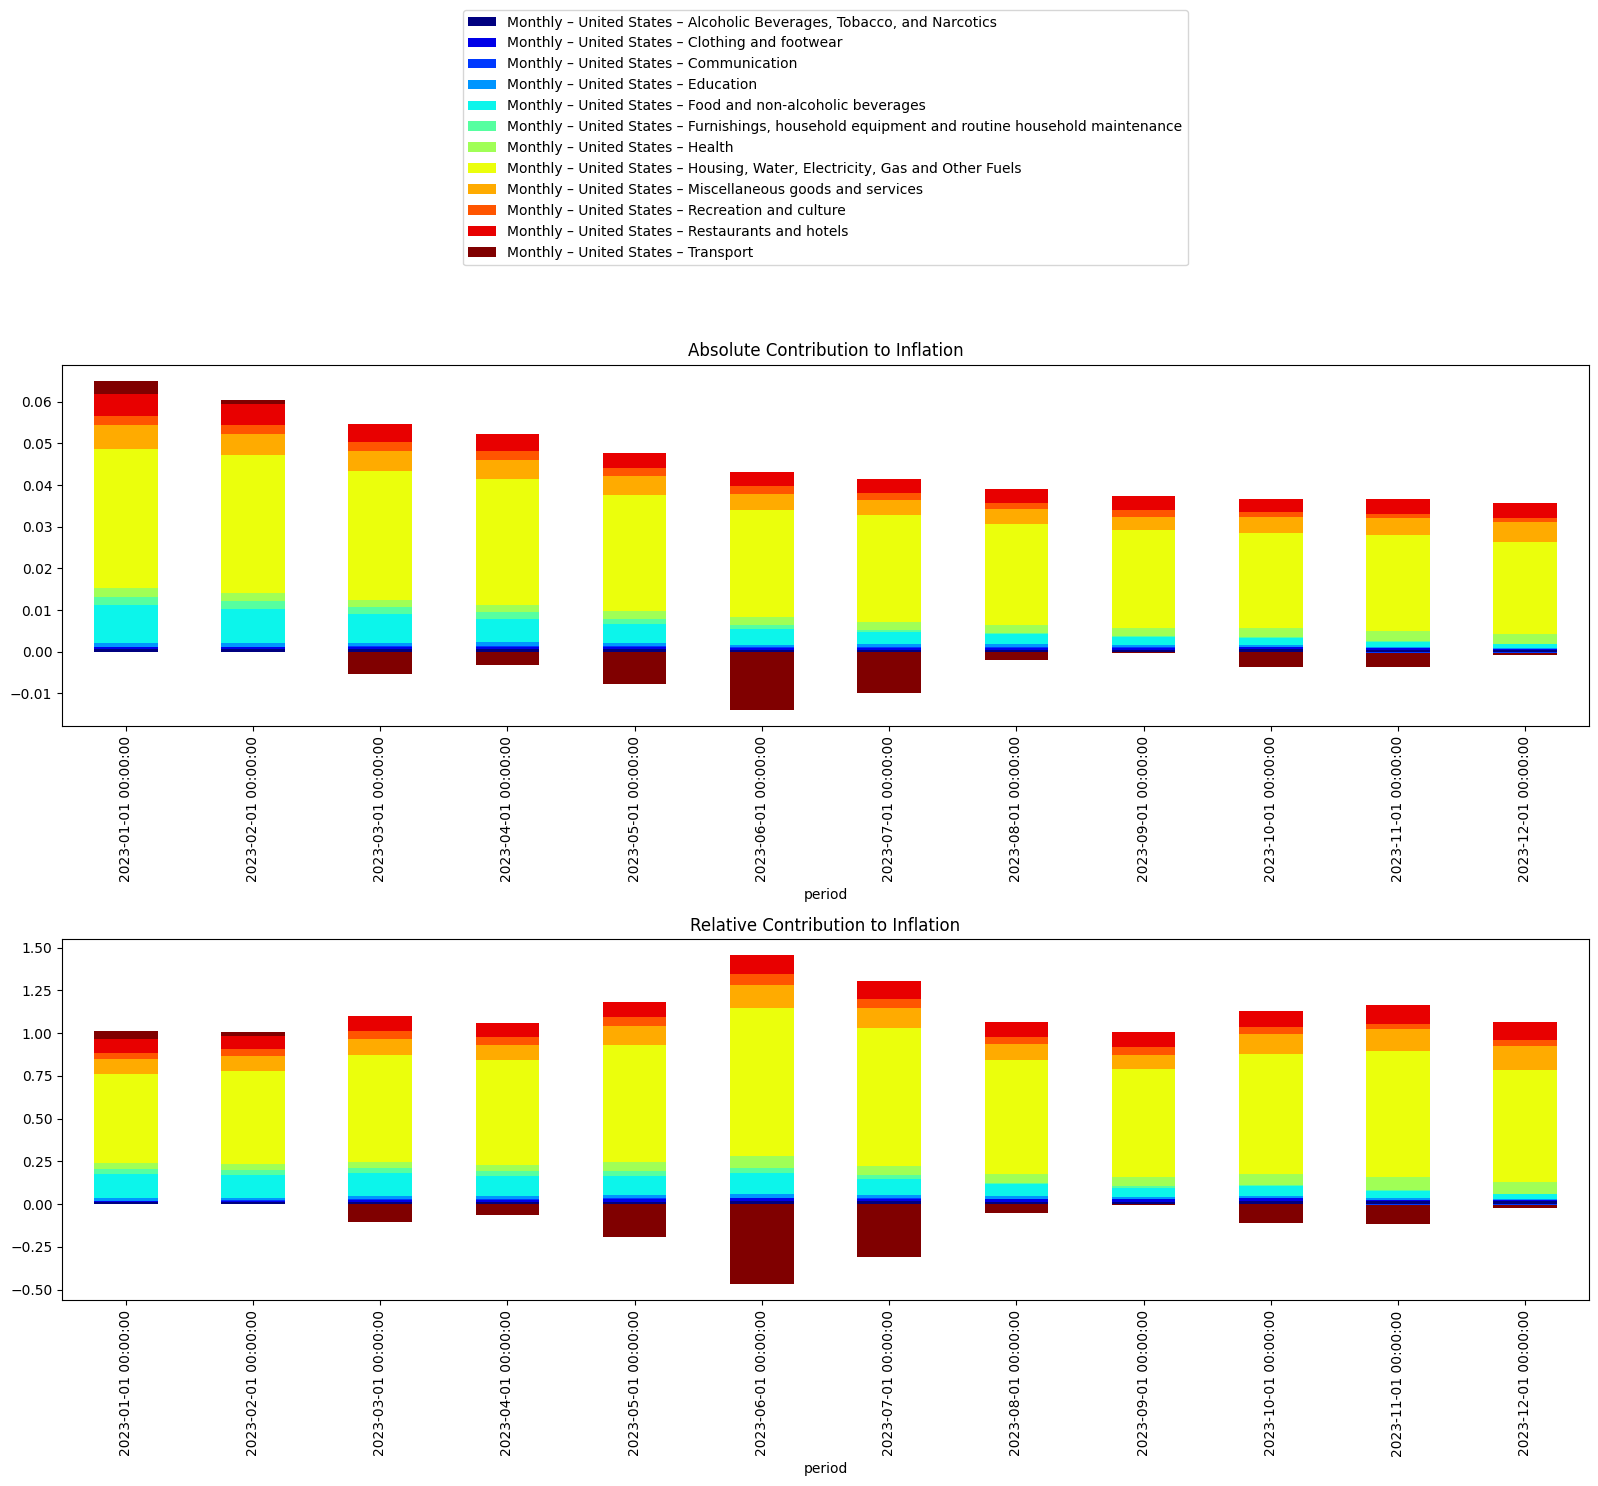

In [ ]:
#Chart absolute and relative contribution charts
colors = plt.cm.jet(np.linspace(0, 1, 12))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,13))

ax = cpi_abs_contr.iloc[-12:].plot(ax=axes[0], kind='bar', color=colors, stacked=True, legend=True, title='Absolute Contribution to Inflation')

ax1 = cpi_rel_contr.iloc[-12:].plot(ax=axes[1], kind='bar', color=colors, stacked=True, legend=False, title='Relative Contribution to Inflation')

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 2))

fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

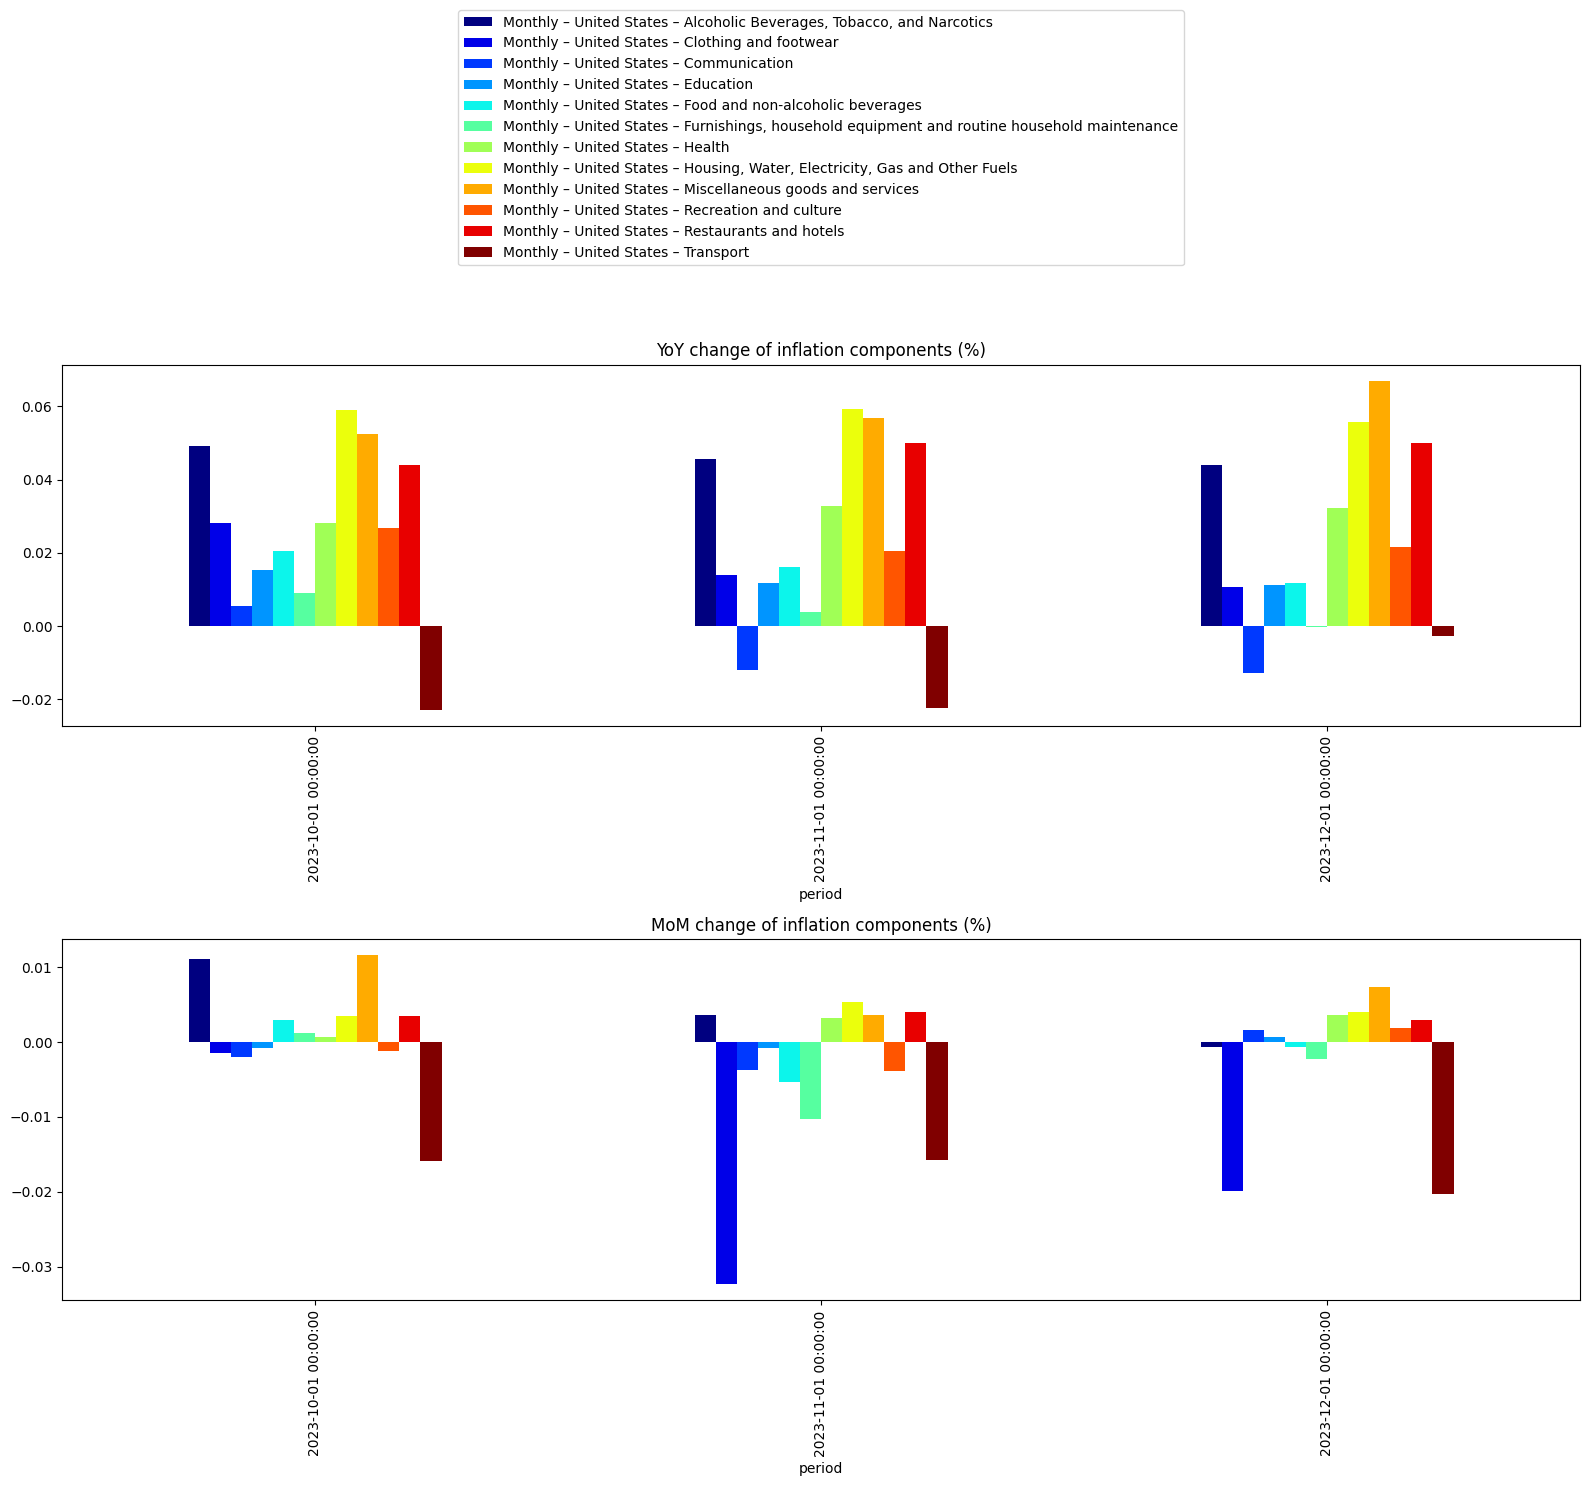

In [ ]:
#Chart each CPI component change from previous year
num_colors = 12

colors = plt.cm.jet(np.linspace(0, 1, 12))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,13))

ax = cpi_comp_chg_yoy.iloc[-3:].plot(ax=axes[0], kind='bar', color=colors, stacked=False, legend=True, title='YoY change of inflation components (%)')

ax1 = cpi_comp_chg_mom.iloc[-3:].plot(ax=axes[1], kind='bar', color=colors, stacked=False, legend=False, title='MoM change of inflation components (%)')

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 2))

fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

In [ ]:
#Fetch quarterly headline and core inflation data
core_inflation = fetch_series('OECD/EO/USA.PCORE_YTYPCT.Q')
core_inflation = clean_data(core_inflation, 'Core Inflation (Q)')
headline_inflation = fetch_series('OECD/EO/USA.CPI_YTYPCT.Q')
headline_inflation = clean_data(headline_inflation, 'Headline Inflation (Q)')

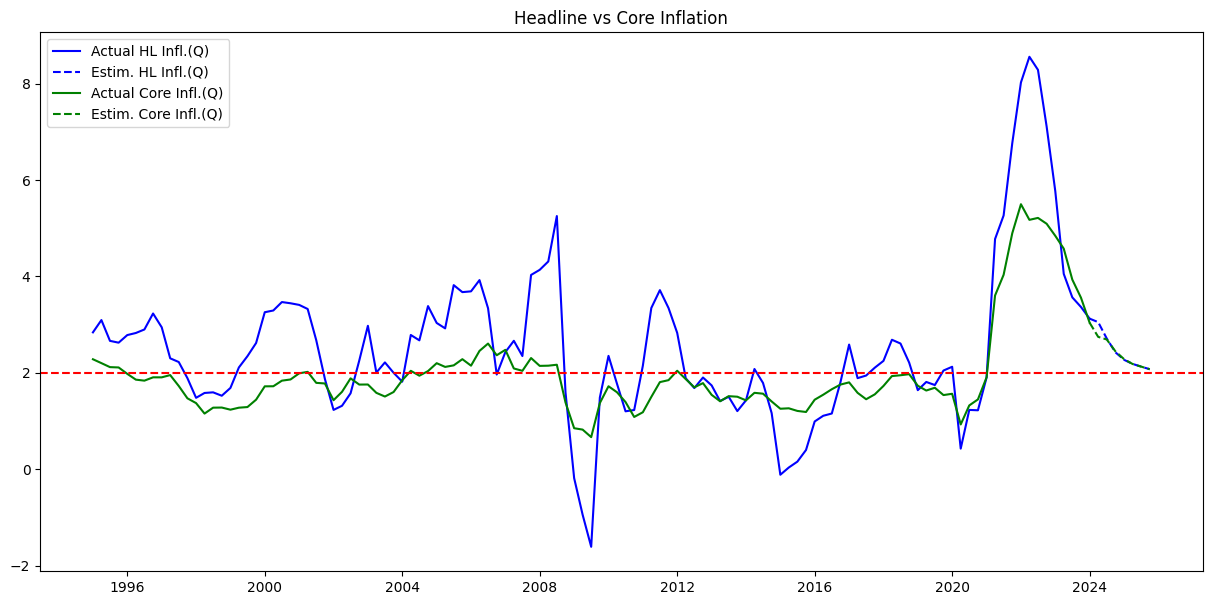

In [ ]:
#Plot data for headline vs core inflation
plt.figure(figsize=(15,7))
plt.plot(headline_inflation.loc[:current_quarter], color='b')
plt.plot(headline_inflation.loc[current_quarter:], color='b', linestyle='--')
plt.plot(core_inflation.loc[:current_quarter], color='g')
plt.plot(core_inflation.loc[current_quarter:], color='g', linestyle='--')
plt.axhline(y=2, color='red', linestyle='--')
plt.legend(['Actual HL Infl.(Q)', 'Estim. HL Infl.(Q)', 'Actual Core Infl.(Q)', 'Estim. Core Infl.(Q)'], loc='upper left')
plt.title('Headline vs Core Inflation')
plt.show()

In [ ]:
#Download average hourly earnings for all employees - U.S.
avg_h_e = fetch_series('BLS/ce/CES0500000003')
avg_h_e = clean_data(avg_h_e, 'Average Hourly Earnings - $')
avg_h_e.tail()

Average Hourly Earnings - $
period                                 
2023-07-01                        33.73
2023-08-01                        33.82
2023-09-01                        33.91
2023-10-01                        33.98
2023-11-01                        34.10

In [ ]:
#Calculate U.S. Average Hourly Earnings YoY data
avg_h_e['Average Hourly Earnings - YoY'] = avg_h_e['Average Hourly Earnings - $'].pct_change(12)
avg_h_e.tail()

Average Hourly Earnings - $  Average Hourly Earnings - YoY
period                                                                
2023-07-01                        33.73                       0.043303
2023-08-01                        33.82                       0.042862
2023-09-01                        33.91                       0.042422
2023-10-01                        33.98                       0.040416
2023-11-01                        34.10                       0.039634

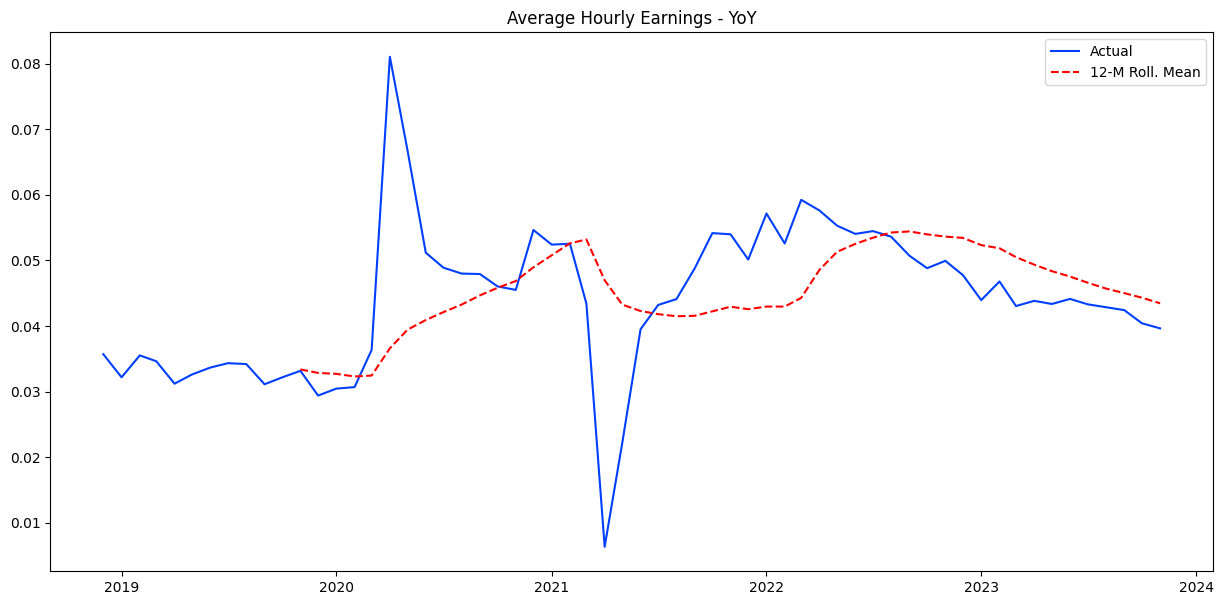

In [ ]:
#Plot Average Hourly Earnings YoY data
plt.figure(figsize=(15,7))
plt.plot(avg_h_e['Average Hourly Earnings - YoY'].iloc[-60:])
plt.plot(avg_h_e['Average Hourly Earnings - YoY'].iloc[-60:].rolling(12).mean(), color='r', linestyle='--')
plt.legend(['Actual', '12-M Roll. Mean'])
plt.title('Average Hourly Earnings - YoY')
plt.show()

In [ ]:
#Fetch House Price Index data
hpi = fetch_series('FHFA/HPI/traditional_purchase-only_monthly_usa-or-census-division_USA_sa')
hpi = clean_data(hpi, 'House Price Index - M')
hpi['12-M Avg.'] = hpi['House Price Index - M'].rolling(12).mean()

The FHFA HPI is a broad measure of the movement of single-family house prices. The FHFA HPI is a weighted, repeat-sales index, meaning that it measures average price changes in repeat sales or refinancings on the same properties. This information is obtained by reviewing repeat mortgage transactions on single-family properties whose mortgages have been purchased or securitized by Fannie Mae or Freddie Mac since January 1975. The FHFA HPI serves as a timely, accurate indicator of house price trends at various geographic levels. Because of the breadth of the sample, it provides more information than is available in other house price indexes. It also provides housing economists with an improved analytical tool that is useful for estimating changes in the rates of mortgage defaults, prepayments and housing affordability in specific geographic areas.

In [ ]:
#Fetch S&P/Case-Shiller 20-City Composite Home Price Index data
case_shiller_20 = fred.get_series('SPCS20RSA')

The S&P/Case-Shiller 20-City Composite Home Price Index is a monthly index that tracks changes in the price of residential real estate in 20 major metropolitan regions in the U.S.

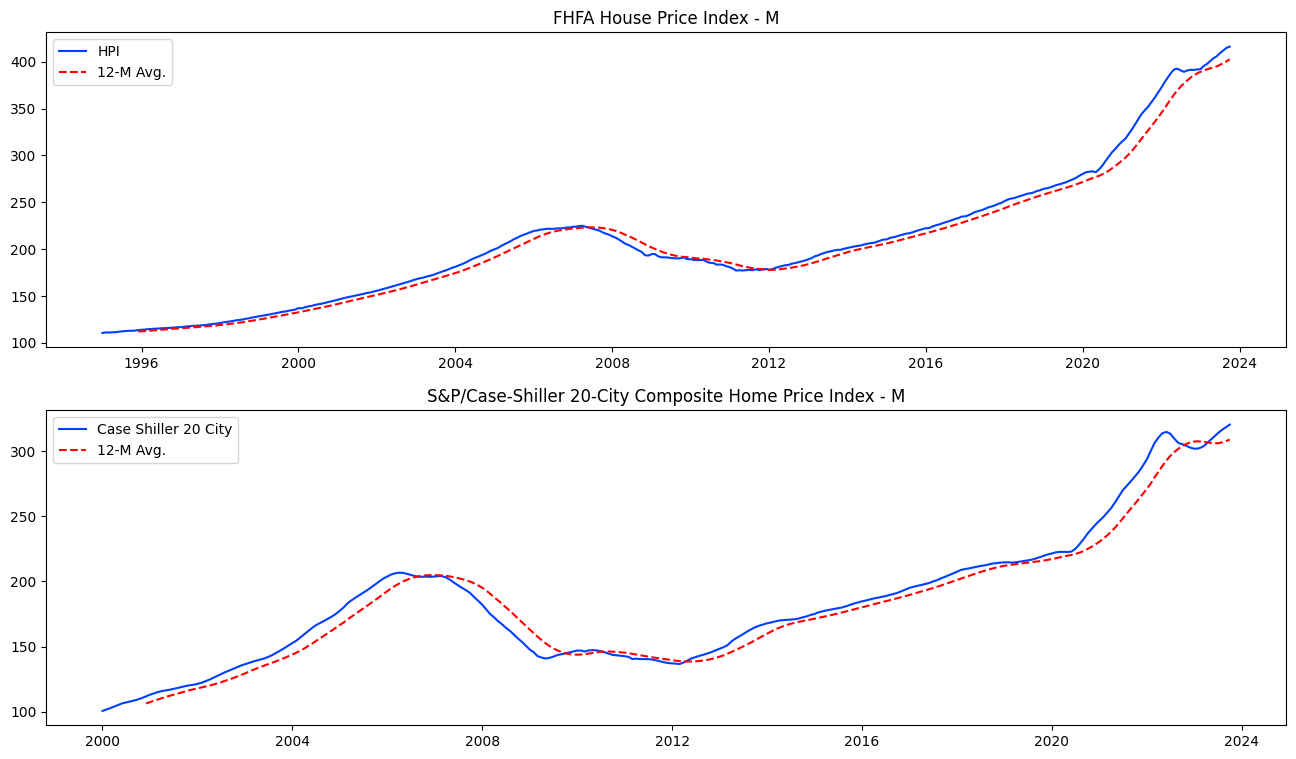

In [ ]:
#Plot housing data
plt.subplots(figsize=(16,9))
plt.subplot(211)
plt.plot(hpi['House Price Index - M'])
plt.plot(hpi['12-M Avg.'], color='r', linestyle='--')
plt.legend(['HPI', '12-M Avg.'])
plt.title('FHFA House Price Index - M')

plt.subplot(212)
plt.plot(case_shiller_20)
plt.plot(case_shiller_20.rolling(12).mean(), color='r', linestyle='--')
plt.legend(['Case Shiller 20 City', '12-M Avg.'])
plt.title('S&P/Case-Shiller 20-City Composite Home Price Index - M')

plt.show()

In [ ]:
mortgage = pd.DataFrame(fred.get_series('MORTGAGE30US'), columns=['30-Y Mtg. Rate'])
mortgage.tail()

30-Y Mtg. Rate
2023-12-14            6.95
2023-12-21            6.67
2023-12-28            6.61
2024-01-04            6.62
2024-01-11            6.66

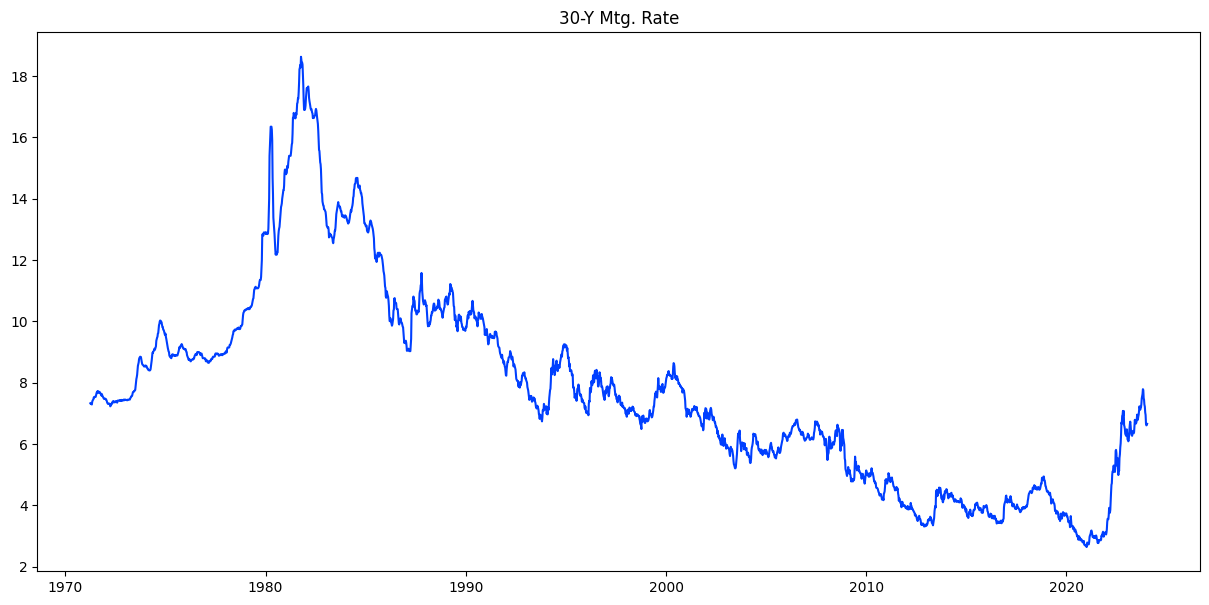

In [ ]:
#Plot 30-year US mortgage rate
plt.figure(figsize=(15,7))
plt.plot(mortgage)
plt.title('30-Y Mtg. Rate')
plt.show()

In [ ]:
#Fetch monthly base metals prices in $
base_metals = fetch_series('RBA/I2/GRCPBMUSD')
base_metals = clean_data(base_metals, 'Base Metals - $')
base_metals['Avg - Rol. 3M'] = base_metals['Base Metals - $'].rolling(3).mean()
base_metals['Avg - Rol. 12M'] = base_metals['Base Metals - $'].rolling(12).mean()
base_metals.tail()

Base Metals - $  Avg - Rol. 3M  Avg - Rol. 12M
period                                                    
2023-11-30        80.431139      79.932271       83.074634
2023-12-31        80.418756      79.892478       82.586259
2024-01-31              NaN            NaN             NaN
2024-02-29              NaN            NaN             NaN
2024-03-31              NaN            NaN             NaN

In [ ]:
#Download lumber futures data as a leading indicator of inflationary pressures in the housing market
lumber = yf.download('LBS=F', period='5y', interval = "1mo")['Adj Close']


[*********************100%%**********************]  1 of 1 completed


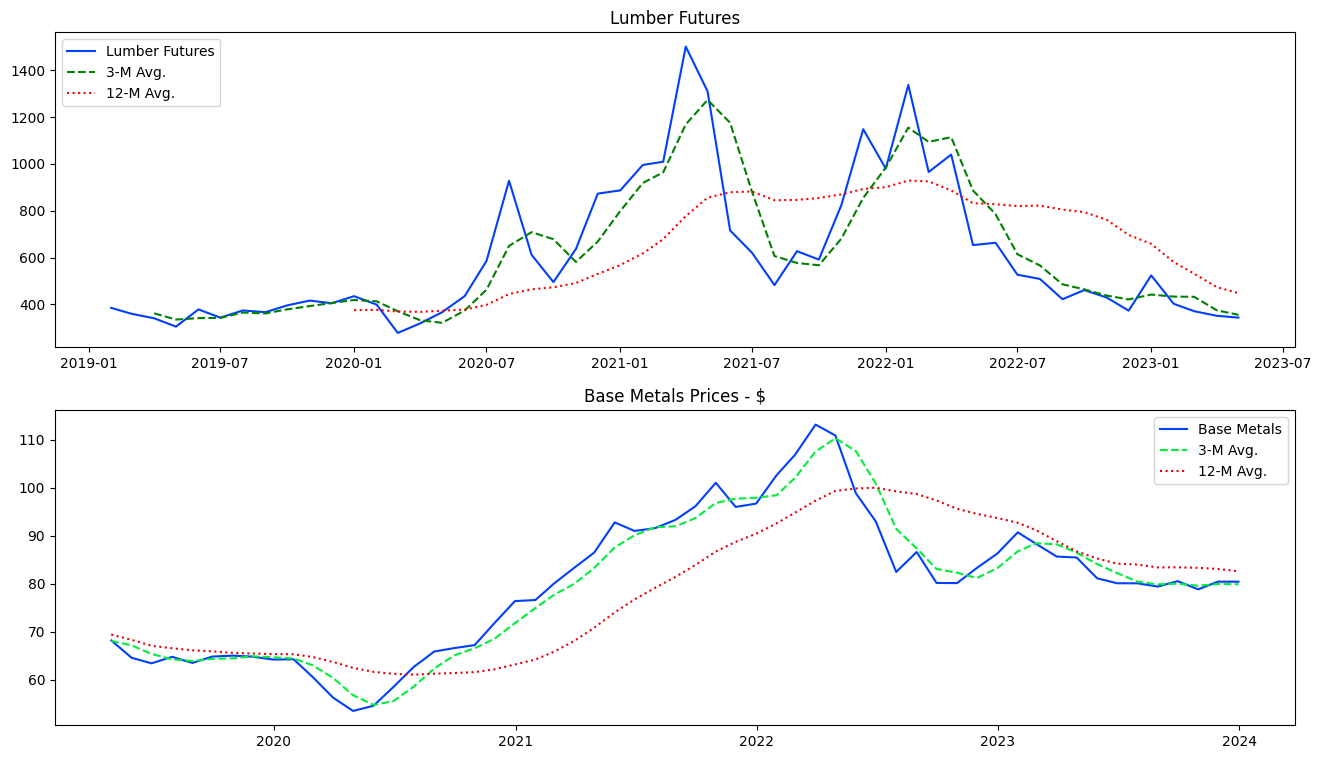

In [ ]:
#Plot lumber futures prices
plt.subplots(figsize=(16,9))
plt.subplot(211)
plt.plot(lumber)
plt.plot(lumber.rolling(3).mean(), linestyle='--', color='g')
plt.plot(lumber.rolling(12).mean(), linestyle=':', color='r')
plt.legend(['Lumber Futures', '3-M Avg.', '12-M Avg.'], loc='upper left')
plt.title('Lumber Futures')

plt.subplot(212)
plt.plot(base_metals['Base Metals - $'].iloc[-60:], linestyle='-')
plt.plot(base_metals['Avg - Rol. 3M'].iloc[-60:], linestyle='--')
plt.plot(base_metals['Avg - Rol. 12M'].iloc[-60:], linestyle=':')
plt.title('Base Metals Prices - $')
plt.legend(['Base Metals', '3-M Avg.', '12-M Avg.'])
plt.show()

# Section 5: Monetary Policy Analysis  

In this section we are about to analyze how the monetary policy is and how it should presumably evolve over time. For this purpose we will look at the Forward-looking Taylor rule formula, as well as the Real Monetary Condition Index, which suit well where the CB is focused on inflation goals. The limitation of these tools lies in the calibration of the parameters used in the formulas, which may differ used from the CB. We will also try to assess the chance of a rate hike by 0.25% and will have a look at the economic projections made by the FED and its famous "dot plot".

In [ ]:
#Let's download and organize data for the Forward-looking version of the Taylor Rule
cb_policy_rate = fetch_series('IMF/IFS/Q.US.FPOLM_PA')
cb_policy_rate = clean_data(cb_policy_rate, 'Policy Rate')

infl_rate = fetch_series('IMF/CPI/Q.US.PCPI_PC_CP_A_PT')
infl_rate = clean_data(infl_rate, 'CPI YoY% - Q')

exp_infl = pd.DataFrame()
exp_infl['Exp. Infl. - Q'] = fred.get_series('MICH', frequency='q')

taylor_rule = pd.concat([gdp_decomp["Log Real GDP"], gdp_decomp['trend'], cb_policy_rate, infl_rate, exp_infl], axis=1)
taylor_rule = taylor_rule.dropna()
taylor_rule.tail()

Log Real GDP      trend  Policy Rate  CPI YoY% - Q  Exp. Infl. - Q
2022-07-01     16.899763  16.899438        3.125      8.329476             4.9
2022-10-01     16.906097  16.905223        4.375      7.101672             4.8
2023-01-01     16.911646  16.911020        4.875      5.804770             3.9
2023-04-01     16.916744  16.916825        5.125      3.974292             4.1
2023-07-01     16.928612  16.922633        5.375      3.514290             3.4

Fwd-looking Taylor Rule --> i(t) = g1 * i(t-1) + (1 - g1 * {i_n(t) + g2 * (exp_infl(t+n) - target_infl) + g3 * output gap} + epsilon

In [ ]:
#Let's calculate the Forward-looking version of the Taylor Rule

taylor_rule['Real Policy Rate'] = taylor_rule['Policy Rate'] - taylor_rule['Exp. Infl. - Q']
cycle, trend = sm.tsa.filters.hpfilter(taylor_rule['Real Policy Rate'], 1600)
taylor_rule['Real Neutral Rate'] = trend
taylor_rule['Nominal Neutral Rate'] = taylor_rule['Real Neutral Rate'] + taylor_rule['Exp. Infl. - Q']
taylor_rule['Inflation Target'] = 2
taylor_rule['Exp. - Target Infl'] = taylor_rule['Exp. Infl. - Q'] - taylor_rule['Inflation Target']
taylor_rule['Output Gap Estim.'] = taylor_rule['Log Real GDP'] - taylor_rule['trend']
taylor_rule['g1'] = 0.75
taylor_rule['g2'] = 0.5
taylor_rule['g3'] = 0.5
taylor_rule['Target Rate'] = (taylor_rule['g1'] * taylor_rule['Policy Rate'].shift(1)) + ((1 - taylor_rule['g1']) * (taylor_rule['Nominal Neutral Rate'] + (taylor_rule['g2'] * taylor_rule['Exp. - Target Infl'] + (taylor_rule['g3'] * taylor_rule['Output Gap Estim.']))))
taylor_rule['Rate Difference'] = taylor_rule['Policy Rate'] - taylor_rule['Target Rate']

In [ ]:
taylor_rule.tail()

Log Real GDP      trend  Policy Rate  CPI YoY% - Q  \
2022-07-01     16.899763  16.899438        3.125      8.329476   
2022-10-01     16.906097  16.905223        4.375      7.101672   
2023-01-01     16.911646  16.911020        4.875      5.804770   
2023-04-01     16.916744  16.916825        5.125      3.974292   
2023-07-01     16.928612  16.922633        5.375      3.514290   

            Exp. Infl. - Q  Real Policy Rate  Real Neutral Rate  \
2022-07-01             4.9            -1.775          -1.530607   
2022-10-01             4.8            -0.425          -1.381398   
2023-01-01             3.9             0.975          -1.222829   
2023-04-01             4.1             1.025          -1.059371   
2023-07-01             3.4             1.975          -0.894120   

            Nominal Neutral Rate  Inflation Target  Exp. - Target Infl  \
2022-07-01              3.369393                 2                 2.9   
2022-10-01              3.418602                 2                 2.8   
2023-01-01              2.677171                 2                 1.9   
2023-04-01              3.040629                 2                 2.1   
2023-07-01              2.505880                 2                 1.4   

            Output Gap Estim.    g1   g2   g3  Target Rate  Rate Difference  
2022-07-01           0.000325  0.75  0.5  0.5     2.423639         0.701361  
2022-10-01           0.000874  0.75  0.5  0.5     3.548510         0.826490  
2023-01-01           0.000626  0.75  0.5  0.5     4.188121         0.686879  
2023-04-01          -0.000081  0.75  0.5  0.5     4.678897         0.446103  
2023-07-01           0.005979  0.75  0.5  0.5     4.645967         0.729033

In [ ]:
def taylor_rule_vis(g1, g2, g3):

    target_rate = g1 * taylor_rule['Policy Rate'].iloc[-2] +\
    ((1 - g1) * ((taylor_rule['Nominal Neutral Rate'].iloc[-1]) +\
    (g2 * taylor_rule['Exp. - Target Infl'].iloc[-1]) +\
    (g3 * taylor_rule['Output Gap Estim.'].iloc[-1])))

    policy_rate = taylor_rule['Policy Rate'].iloc[-1]

    neutral_rate = taylor_rule['Nominal Neutral Rate'].iloc[-1]

    plt.subplots(figsize=(16,14))

    plt.subplot(331)
    plt.bar(x=str(taylor_rule.index.max()), height=policy_rate, width=0.1, color='b')
    plt.title('Policy Rate')
    plt.ylim(-3, 3)

    plt.subplot(332)
    plt.bar(x=str(taylor_rule.index.max()), height=target_rate, width=0.1, color='r')
    plt.title('Target Rate')
    plt.ylim(-3, 3)

    plt.subplot(333)
    plt.bar(x=str(taylor_rule.index.max()), height=neutral_rate, width=0.1, color='g')
    plt.title('Neutral Rate')
    plt.ylim(-3, 3)


<p style="color:red;">N.B.: Sum of g2 and g3 cannot be greater than 1</p>

interactive(children=(FloatSlider(value=0.55, description='g1', max=0.95, min=0.25, step=0.05), FloatSlider(va…

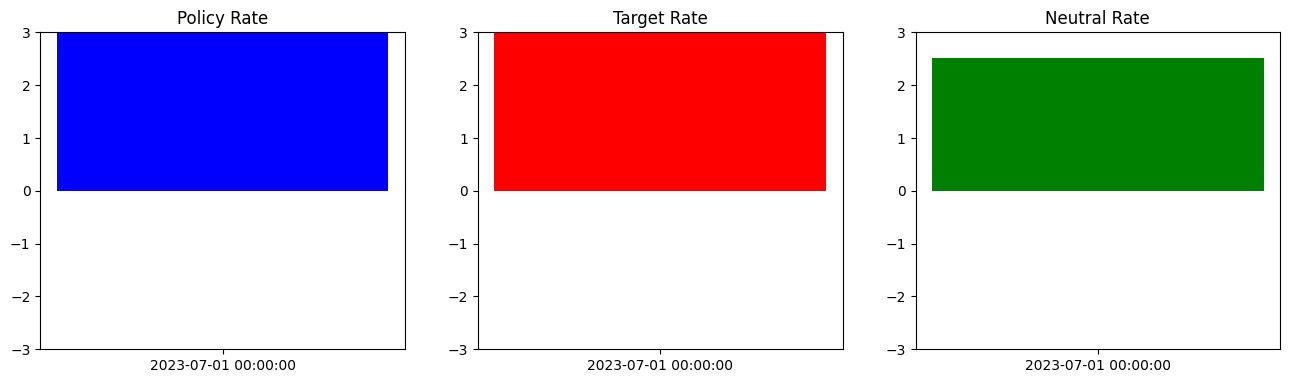

In [ ]:
widgets.interact(taylor_rule_vis, g1=(0.25, 0.95, 0.05), g2=(0.25, 0.95, 0.05), g3=(0.25, 0.95, 0.05));

In [ ]:
#Fetch and organize data for the RMCI calculation
cpi_dom = fetch_series('IMF/CPI/Q.US.PCPI_IX')
cpi_dom = clean_data(cpi_dom, 'Domestic CPI')

usd_eur = fetch_series('BIS/xru_current/Q.XM.EUR.A')
usd_eur = clean_data(usd_eur, 'USD/EUR')

cpi_for = cpi_dom.mul(usd_eur.values)
cpi_for = cpi_for.rename(columns={'Domestic CPI':'Foreign CPI'})

comm_rate = fred.get_series('RIFSPPNA2P2D90NB', frequency='q')
comm_rate = comm_rate.loc['2003-01-01':]
comm_rate = comm_rate.dropna()

rmci = pd.concat([cpi_dom, cpi_for, taylor_rule['Exp. Infl. - Q']], axis=1)
rmci = rmci.loc['2003-01-01':]

rmci['Commercial Rate'] = comm_rate
rmci = rmci.dropna()
rmci.tail()

Domestic CPI  Foreign CPI  Exp. Infl. - Q  Commercial Rate
2022-07-01    135.937105   135.039784             4.9             3.20
2022-10-01    136.436213   133.842015             4.8             4.74
2023-01-01    137.861844   128.496889             3.9             5.14
2023-04-01    139.505615   128.154601             4.1             5.47
2023-07-01    140.714329   129.314920             3.4             5.61

In [ ]:
#Calculate the RMCI
a = 0.7 #Let's assume the value of alpha is 0.7

rmci['Real Comm. Rate'] = rmci['Commercial Rate'] - rmci['Exp. Infl. - Q']

cycle, trend = sm.tsa.filters.hpfilter(rmci['Real Comm. Rate'], 1600)

rmci['Real Int. Rate Trend'] = trend
rmci['Real Int. Rate Gap'] = rmci['Real Comm. Rate'] - rmci['Real Int. Rate Trend']
rmci['FC/LC'] = 1 / usd_eur
rmci['Real Exch. Rate'] = (np.log(rmci['FC/LC']).values + np.log(rmci['Domestic CPI']).values - np.log(rmci['Foreign CPI'].values))*100

cycle_1, trend_1 = sm.tsa.filters.hpfilter(rmci['Real Exch. Rate'], 1600)

rmci['Real Exch. Rate Trend'] = trend_1
rmci['Real Exch. Rate Gap'] = rmci['Real Exch. Rate'] - rmci['Real Exch. Rate Trend']
rmci['RMCI'] = (a * rmci['Real Int. Rate Gap']) + ((1 - a) * rmci['Real Exch. Rate Gap'])

rmci.tail()

Domestic CPI  Foreign CPI  Exp. Infl. - Q  Commercial Rate  \
2022-07-01    135.937105   135.039784             4.9             3.20   
2022-10-01    136.436213   133.842015             4.8             4.74   
2023-01-01    137.861844   128.496889             3.9             5.14   
2023-04-01    139.505615   128.154601             4.1             5.47   
2023-07-01    140.714329   129.314920             3.4             5.61   

            Real Comm. Rate  Real Int. Rate Trend  Real Int. Rate Gap  \
2022-07-01            -1.70             -1.279105           -0.420895   
2022-10-01            -0.06             -1.148293            1.088293   
2023-01-01             1.24             -1.007802            2.247802   
2023-04-01             1.37             -0.862259            2.232259   
2023-07-01             2.21             -0.714888            2.924888   

               FC/LC  Real Exch. Rate  Real Exch. Rate Trend  \
2022-07-01  1.006645         1.324577              18.379539   
2022-10-01  1.019383         3.839418              17.464871   
2023-01-01  1.072881        14.069472              16.554346   
2023-04-01  1.088573        16.973499              15.647344   
2023-07-01  1.088152        16.896225              14.741688   

            Real Exch. Rate Gap      RMCI  
2022-07-01           -17.054963 -5.411115  
2022-10-01           -13.625453 -3.325831  
2023-01-01            -2.484874  0.827999  
2023-04-01             1.326155  1.960428  
2023-07-01             2.154537  2.693783

In [ ]:
#Let's create a function for RMCI simulation
def rmci_vis(a):

    rmci_df = pd.DataFrame(index=rmci.index)
    rmci_df['RMCI'] = (a * rmci['Real Int. Rate Gap']) + ((1 - a) * rmci['Real Exch. Rate Gap'])

    plt.figure(figsize=(15,7))
    plt.plot(rmci_df, color='b', marker='s')
    plt.title('RMCI')

For Emerging Countries the level of alpha ranges from 0.3 to 0.7, while for Developed Economies it is higher.

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0), Output()), _dom_classes=('widget-inter…

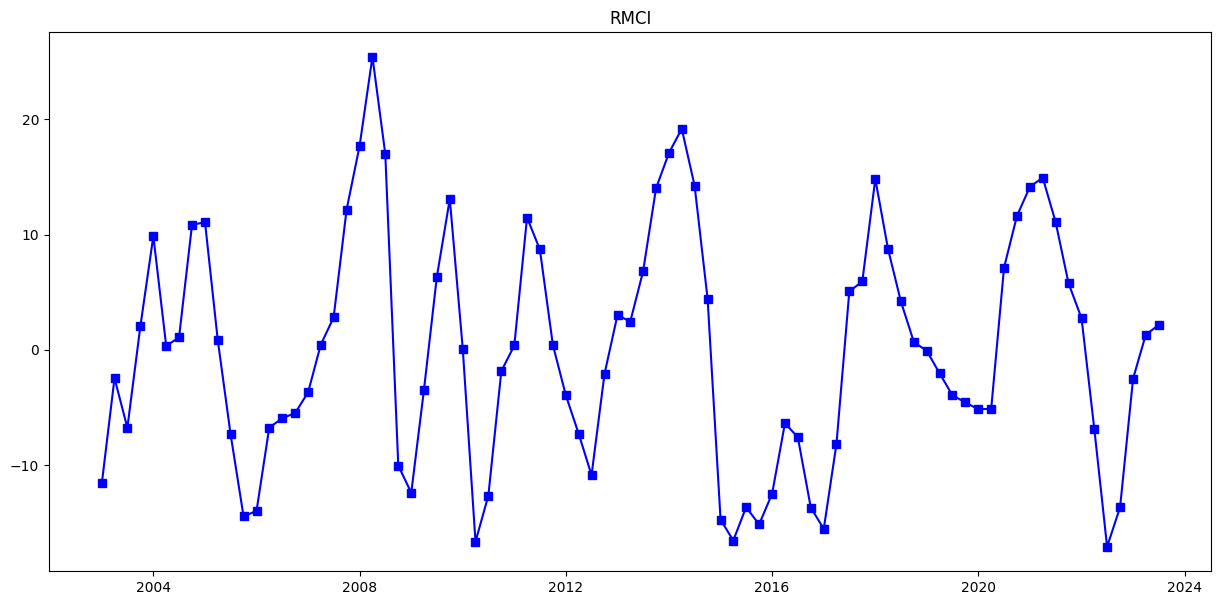

In [ ]:
widgets.interact(rmci_vis, a=(0, 1, 0.1));

A positive index points to tight monetary conditions, constraining domestic demand and therefore inflation. A negative index points to accomodative conditions, boosting demand and therefore inflation.

<p style="color:red;">N.B.: The ff_futures ticker needs to be changed according to the forecast horizon!!</p>

In [ ]:
#Download Fed Funds rate futures data
ff_futures = yf.download('ZQH22.CBT', period='1y')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ZQH22.CBT']: Exception('%ticker%: No data found, symbol may be delisted')


In [ ]:
ff_futures.tail()

Series([], Name: Adj Close, dtype: float64)

In [ ]:
#Fetch Fed Funds target rate data
ff_target_ul = fred.get_series('DFEDTARU', observation_start='2021-01-01')
ff_target_ll = fred.get_series('DFEDTARL', observation_start='2021-01-01')

In [ ]:
#Calculate percent probability of a rate hike by the FED
fed_prob = pd.concat([ff_futures, ff_target_ul, ff_target_ll], axis=1)
fed_prob = fed_prob.dropna()
fed_prob.rename(columns={fed_prob.columns[0]: "ff_futures", fed_prob.columns[1]: "ff_target_ul", fed_prob.columns[2]: "ff_target_ll"}, inplace = True)
fed_prob['ff_target_mid'] = (fed_prob['ff_target_ul'] + fed_prob['ff_target_ll']) / 2
fed_prob['ff_implied'] = 100 - fed_prob['ff_futures']
fed_prob['ff_increase'] = fed_prob['ff_target_mid'] + 0.25
fed_prob['Probability of a rate hike'] = (fed_prob['ff_implied'] - fed_prob['ff_target_mid']) / (fed_prob['ff_increase'] - fed_prob['ff_target_mid'])
fed_prob.tail()

Empty DataFrame
Columns: [ff_futures, ff_target_ul, ff_target_ll, ff_target_mid, ff_implied, ff_increase, Probability of a rate hike]
Index: []

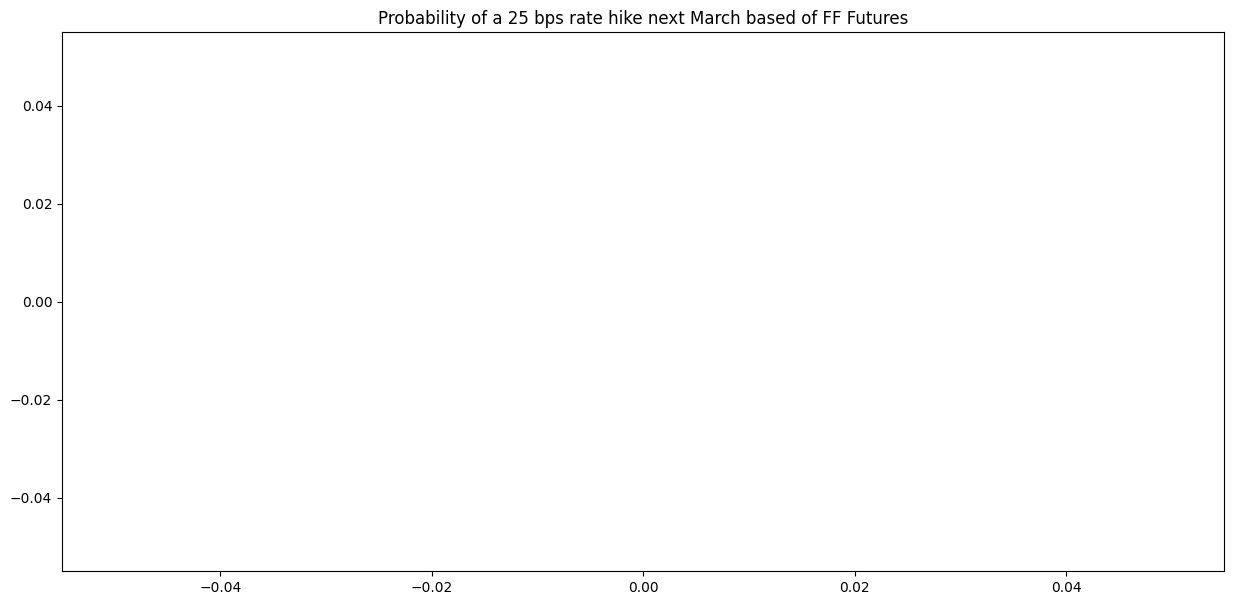

In [ ]:
#Plot probability of a rate hike
plt.figure(figsize=(15,7))
plt.plot(fed_prob['Probability of a rate hike'].iloc[-40:])
plt.title('Probability of a 25 bps rate hike next March based of FF Futures')
plt.show()

In [ ]:
#Download vintage dates for FED dot plot
from __future__ import print_function
vintage_dates = fred.get_series_vintage_dates('FEDTARMD')
dates = []
for dt in vintage_dates[-2:]:
    dates.append(dt.strftime('%Y-%m-%d'))
    print(dt.strftime('%Y-%m-%d'))

2023-09-20
2023-12-13


In [ ]:
#Download median estimates of last two FOMC meetings for the Change in Real GDP median
fomc_gdp_previous = fred.get_series('GDPC1MD', realtime_end=dates[0])
fomc_gdp_last = fred.get_series('GDPC1MD', realtime_end=dates[1])
fomc_gdp = pd.concat([fomc_gdp_previous, fomc_gdp_last], axis=1)
fomc_gdp = fomc_gdp.dropna()
fomc_gdp.rename(columns={fomc_gdp.columns[0]: "Previous", fomc_gdp.columns[1]: "Last"}, inplace = True)
fomc_gdp

Previous  Last
2023-01-01       2.1   2.6
2024-01-01       1.5   1.4
2025-01-01       1.8   1.8
2026-01-01       1.8   1.9

In [ ]:
#Download median estimates of last two FOMC meetings for the Unemployment rate median
fomc_uer_previous = fred.get_series('UNRATEMD', realtime_end=dates[0])
fomc_uer_last = fred.get_series('UNRATEMD', realtime_end=dates[1])
fomc_uer = pd.concat([fomc_uer_previous, fomc_uer_last], axis=1)
fomc_uer = fomc_uer.dropna()
fomc_uer.rename(columns={fomc_uer.columns[0]: "Previous", fomc_uer.columns[1]: "Last"}, inplace = True)
fomc_uer

Previous  Last
2023-01-01       3.8   3.8
2024-01-01       4.1   4.1
2025-01-01       4.1   4.1
2026-01-01       4.0   4.1

In [ ]:
#Download median estimates of last two FOMC meetings for the PCE deflator rate median
fomc_pce_previous = fred.get_series('PCECTPIMD', realtime_end=dates[0])
fomc_pce_last = fred.get_series('PCECTPIMD', realtime_end=dates[1])
fomc_pce = pd.concat([fomc_pce_previous, fomc_pce_last], axis=1)
fomc_pce = fomc_pce.dropna()
fomc_pce.rename(columns={fomc_pce.columns[0]: "Previous", fomc_pce.columns[1]: "Last"}, inplace = True)
fomc_pce

Previous  Last
2023-01-01       3.3   2.8
2024-01-01       2.5   2.4
2025-01-01       2.2   2.1
2026-01-01       2.0   2.0

In [ ]:
#Download median estimates of last two FOMC meetings for the Core PCE deflator rate median
fomc_core_pce_previous = fred.get_series('JCXFEMD', realtime_end=dates[0])
fomc_core_pce_last = fred.get_series('JCXFEMD', realtime_end=dates[1])
fomc_core_pce = pd.concat([fomc_core_pce_previous, fomc_core_pce_last], axis=1)
fomc_core_pce = fomc_core_pce.dropna()
fomc_core_pce.rename(columns={fomc_core_pce.columns[0]: "Previous", fomc_core_pce.columns[1]: "Last"}, inplace = True)
fomc_core_pce

Previous  Last
2023-01-01       3.7   3.2
2024-01-01       2.6   2.4
2025-01-01       2.3   2.2
2026-01-01       2.0   2.0

In [ ]:
#Download median estimates of last two FOMC meetings for the Fed Funds rate median
fomc_ffr_previous = fred.get_series('FEDTARMD', realtime_end=dates[0])
fomc_ffr_last = fred.get_series('FEDTARMD', realtime_end=dates[1])
fomc_ffr = pd.concat([fomc_ffr_previous, fomc_ffr_last], axis=1)
fomc_ffr = fomc_ffr.dropna()
fomc_ffr.rename(columns={fomc_ffr.columns[0]: "Previous", fomc_ffr.columns[1]: "Last"}, inplace = True)
fomc_ffr

Previous  Last
2023-01-01       5.6   5.4
2024-01-01       5.1   4.6
2025-01-01       3.9   3.6
2026-01-01       2.9   2.9

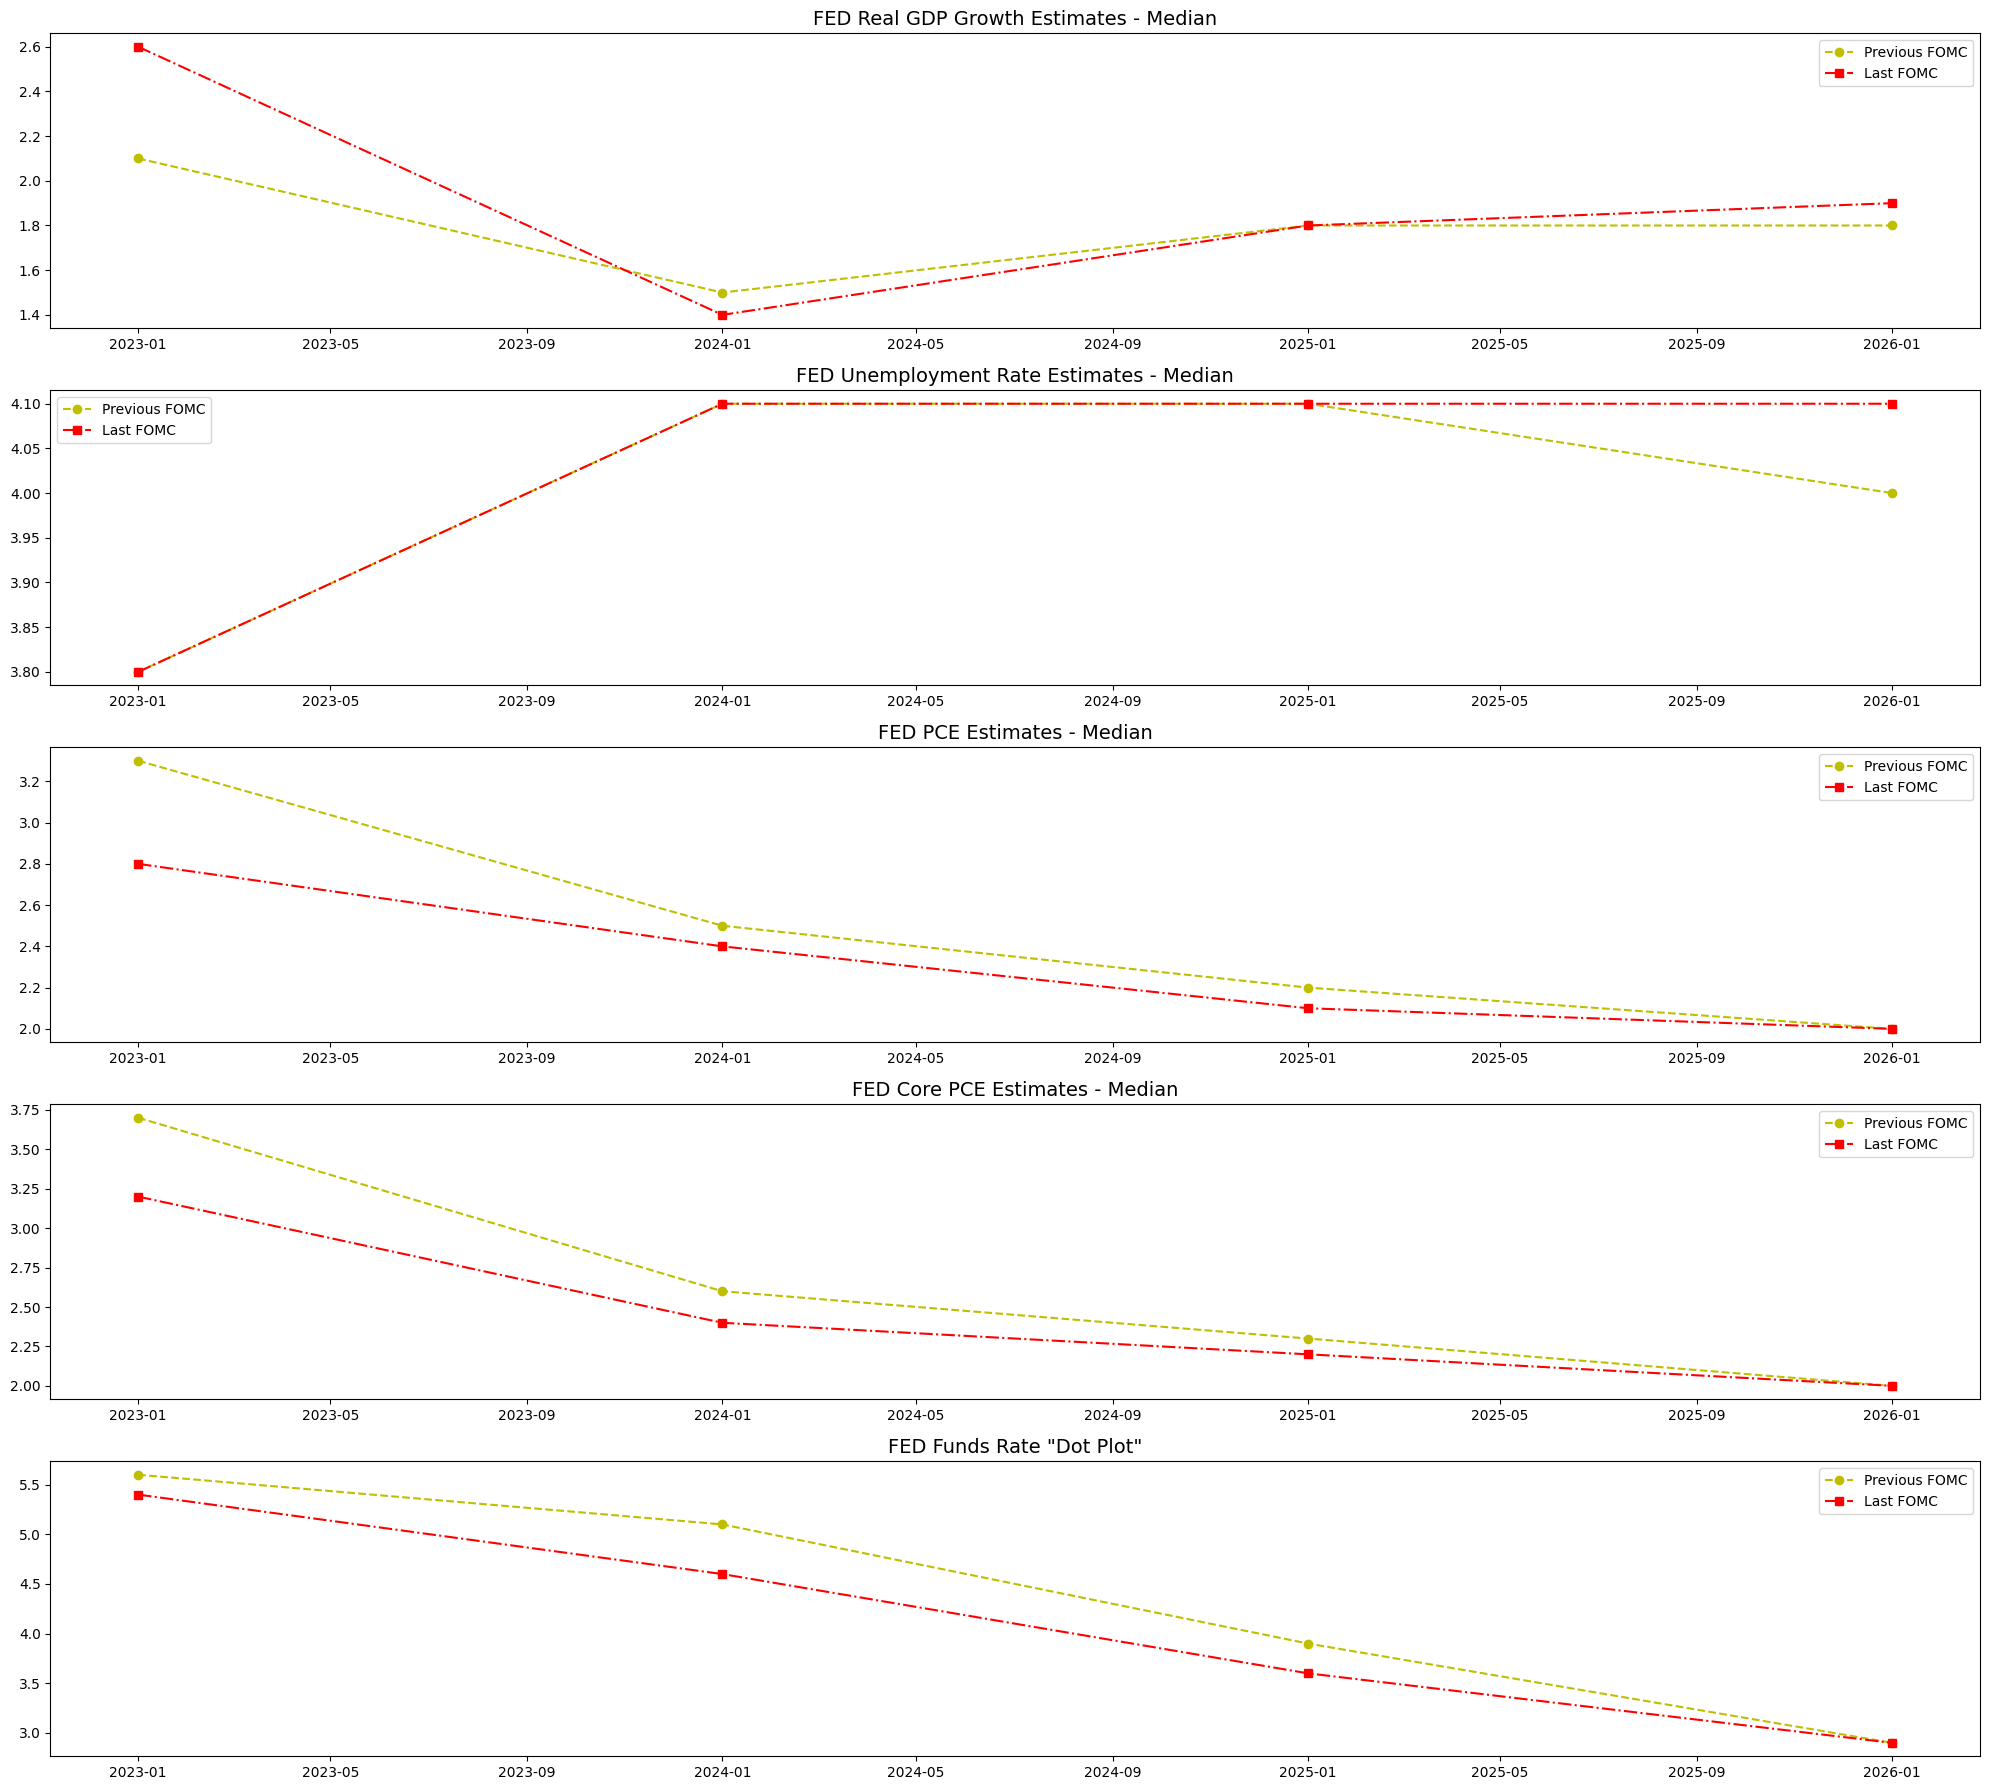

In [ ]:
#Plot median estimates of rates from the last two FOMC meetings
plt.figure(figsize=(20,18))
plt.subplot(511)
plt.plot(fomc_gdp['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_gdp['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED Real GDP Growth Estimates - Median', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.subplot(512)
plt.plot(fomc_uer['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_uer['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED Unemployment Rate Estimates - Median', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.subplot(513)
plt.plot(fomc_pce['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_pce['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED PCE Estimates - Median', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.subplot(514)
plt.plot(fomc_core_pce['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_core_pce['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED Core PCE Estimates - Median', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.subplot(515)
plt.plot(fomc_ffr['Previous'], linestyle='--', marker='o', color='y')
plt.plot(fomc_ffr['Last'], linestyle='dashdot', marker='s', color='r')
plt.title('FED Funds Rate "Dot Plot"', fontsize=14)
plt.legend(['Previous FOMC', 'Last FOMC'])

plt.tight_layout()
plt.show()

# Section 6: Macrofinancial Linkages

In this section we'll look at main ratios of financial soundness and their recommended thresholds under Basel III. Furthermore, we'll evaluate the chance of default in the banking system using the z-score.

In [ ]:
#Capital adequacy
tier_1_rwa = fred.get_series('BOGZ1FL010000016Q')
tier_1_ta = fred.get_series('BOGZ1FL010000026Q')
cap_adeq = pd.concat([tier_1_rwa, tier_1_ta], axis=1)
cap_adeq.rename(columns={cap_adeq.columns[0]: "Tier 1 / RWA", cap_adeq.columns[1]: "Tier 1 / Tot. Assets"}, inplace = True)
cap_adeq['Leverage'] = 1 / (cap_adeq['Tier 1 / Tot. Assets'] / 100)
cap_adeq.head()

Tier 1 / RWA  Tier 1 / Tot. Assets   Leverage
2009-10-01          11.4                   8.4  11.904762
2010-01-01          11.8                   8.3  12.048193
2010-04-01          12.1                   8.5  11.764706
2010-07-01          12.3                   8.6  11.627907
2010-10-01          12.3                   8.6  11.627907

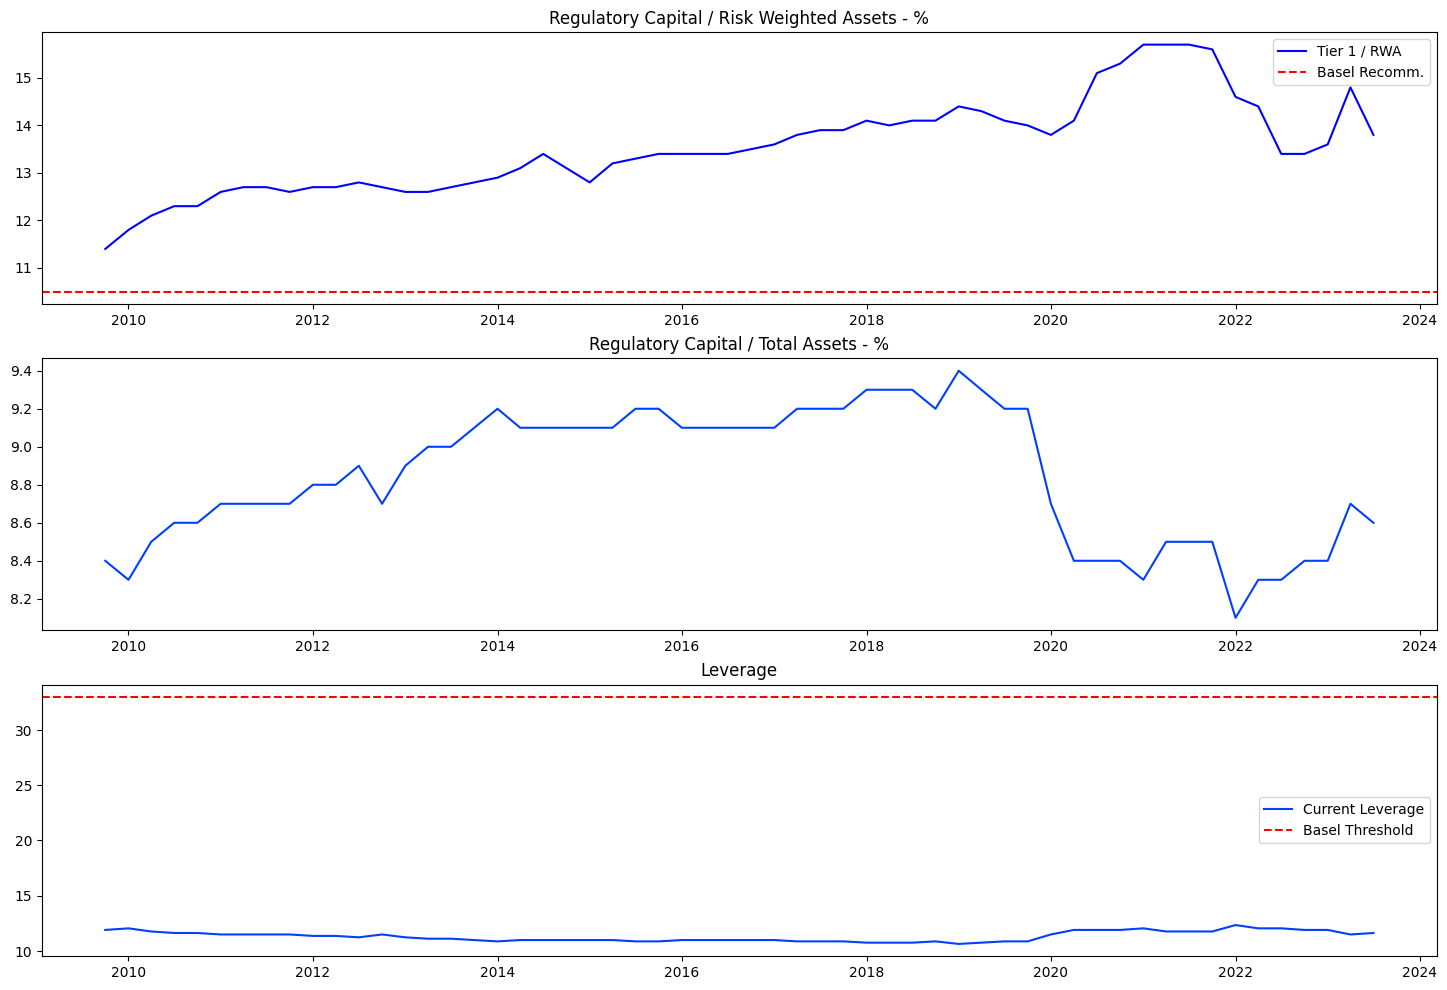

In [ ]:
#Plot capital adequacy analysis
plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(cap_adeq['Tier 1 / RWA'], color='blue')
plt.axhline(y=10.5, color='red', linestyle='--')
plt.title('Regulatory Capital / Risk Weighted Assets - %')
plt.legend(['Tier 1 / RWA', 'Basel Recomm.'])

plt.subplot(312)
plt.plot(cap_adeq['Tier 1 / Tot. Assets'])
plt.title('Regulatory Capital / Total Assets - %')

plt.subplot(313)
plt.plot(cap_adeq['Leverage'])
plt.axhline(y=33, color='red', linestyle='--')
plt.title('Leverage')
plt.legend(['Current Leverage', 'Basel Threshold'], loc='best')

plt.show()

In [ ]:
#Asset quality
npl_to_tot = fred.get_series('BOGZ1FL010000046Q')
npl_net_to_capital = fred.get_series('BOGZ1FL010000036Q')
asset_quality = pd.concat([npl_to_tot, npl_net_to_capital], axis=1)
asset_quality.rename(columns={asset_quality.columns[0]: "NPL / Total Loans - (Before Prov.)", asset_quality.columns[1]: "NPL / Capital - (After Prov.)"}, inplace = True)
asset_quality.tail()

NPL / Total Loans - (Before Prov.)  NPL / Capital - (After Prov.)
2022-07-01                                 0.7                           -4.7
2022-10-01                                 0.7                           -4.9
2023-01-01                                 0.7                           -5.1
2023-04-01                                 0.7                           -5.1
2023-07-01                                 0.8                           -5.1

<function matplotlib.pyplot.show(close=None, block=None)>

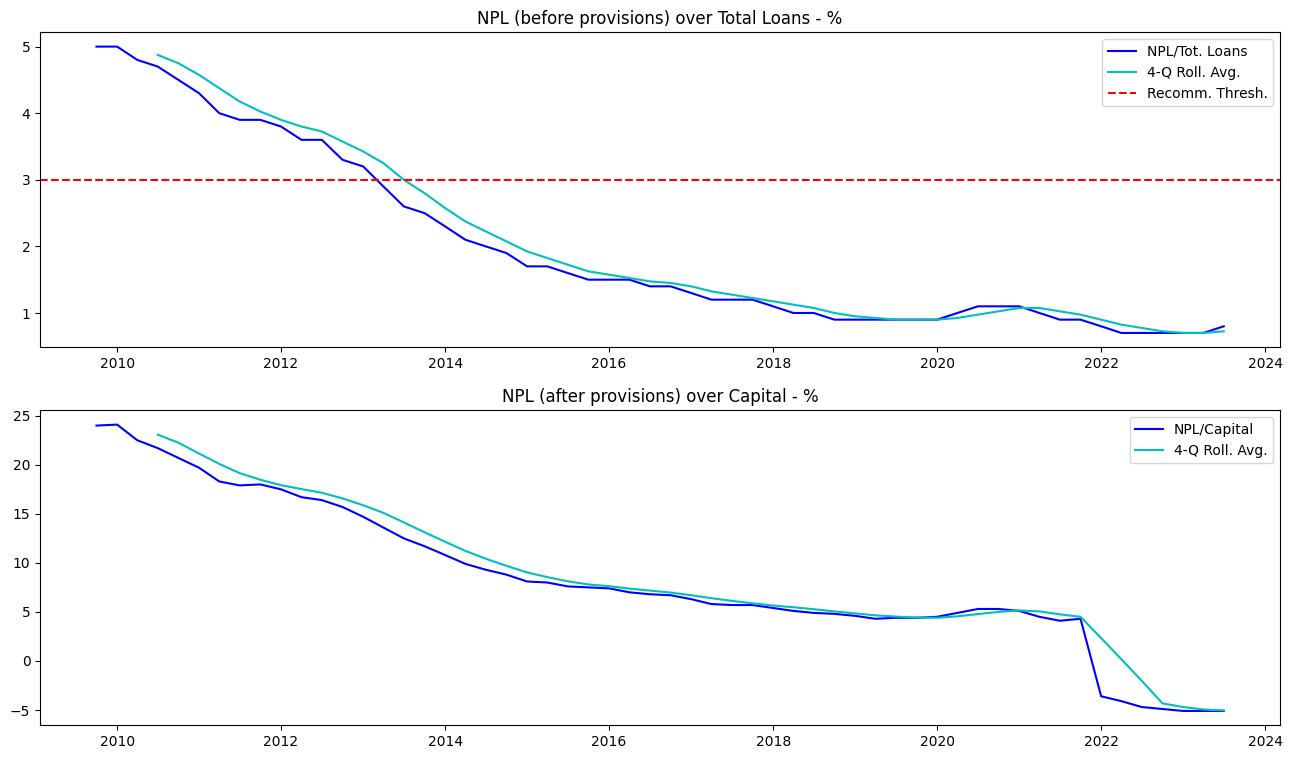

In [ ]:
#Plot asset quality analysis
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(asset_quality['NPL / Total Loans - (Before Prov.)'], color='blue')
plt.plot(asset_quality['NPL / Total Loans - (Before Prov.)'].rolling(4).mean(), color='c')
plt.axhline(y=3, color='red', linestyle='--')
plt.title('NPL (before provisions) over Total Loans - %')
plt.legend(['NPL/Tot. Loans', '4-Q Roll. Avg.', 'Recomm. Thresh.'])

plt.subplot(212)
plt.plot(asset_quality['NPL / Capital - (After Prov.)'], color='blue')
plt.plot(asset_quality['NPL / Capital - (After Prov.)'].rolling(4).mean(), color='c')
plt.title('NPL (after provisions) over Capital - %')
plt.legend(['NPL/Capital', '4-Q Roll. Avg.'])

plt.show

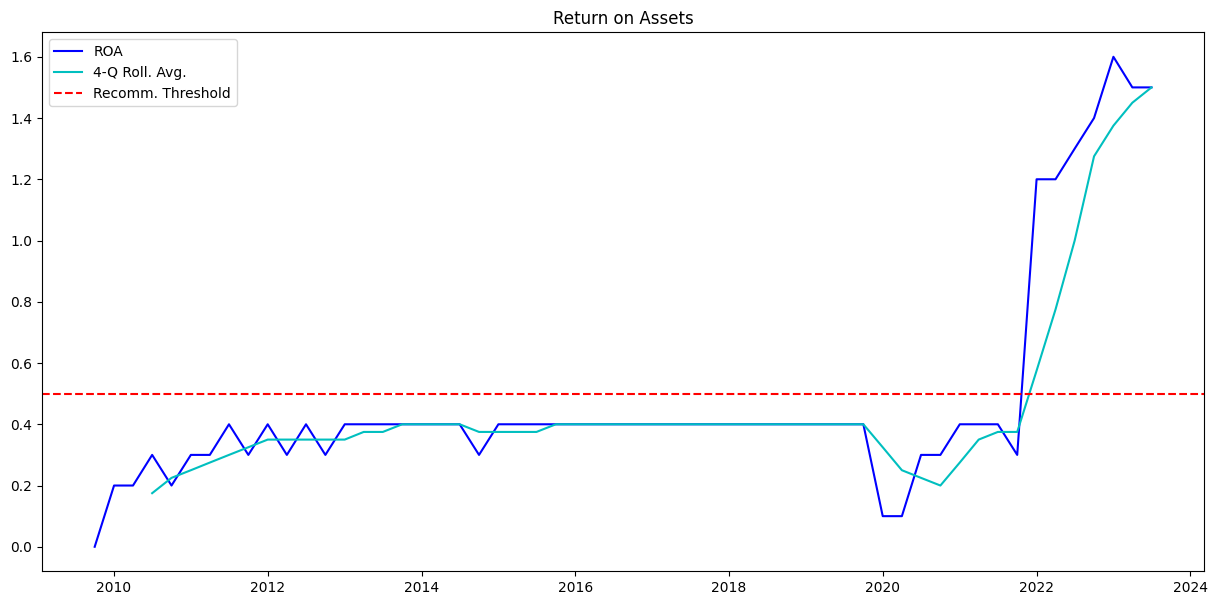

In [ ]:
#Profitability analysis
roa = fred.get_series('BOGZ1FL010000056Q')

plt.figure(figsize=(15,7))
plt.plot(roa, color='blue')
plt.plot(roa.rolling(4).mean(), color='c')
plt.axhline(y=0.5, color='red', linestyle='--')
plt.title('Return on Assets')
plt.legend(['ROA', '4-Q Roll. Avg.', 'Recomm. Threshold'])

plt.show()

In [ ]:
#Liquidity analysis
liq_assets_to_sht_liab = fetch_series('IMF/FSI/Q.US.FSLS_PT')
liq_assets_to_sht_liab = clean_data(liq_assets_to_sht_liab, 'Liquid Assets / Sht Liab.')

liq_asset_ratio = fetch_series('IMF/FSI/Q.US.FSLT_PT')
liq_asset_ratio = clean_data(liq_asset_ratio, 'Liquid Asset Ratio')

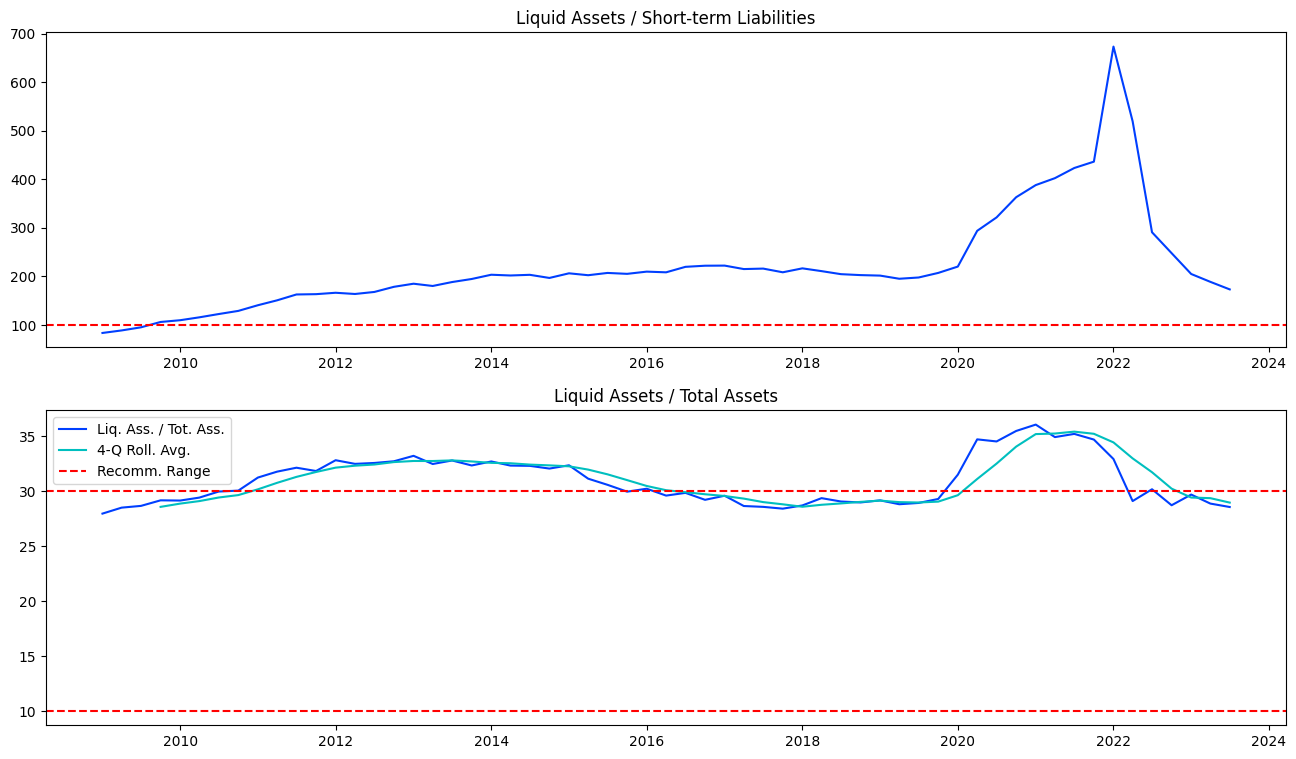

In [ ]:
#Plot liquidity analysis
plt.figure(figsize=(16,9))
plt.subplot(211)
plt.plot(liq_assets_to_sht_liab)
plt.axhline(y=100, color='red', linestyle='--')
plt.title('Liquid Assets / Short-term Liabilities')

plt.subplot(212)
plt.plot(liq_asset_ratio)
plt.plot(liq_asset_ratio.rolling(4).mean(), color='c')
plt.axhline(y=10, color='red', linestyle='--')
plt.axhline(y=30, color='red', linestyle='--')
plt.title('Liquid Assets / Total Assets')
plt.legend(['Liq. Ass. / Tot. Ass.', '4-Q Roll. Avg.', 'Recomm. Range'])

plt.show()

<p style="color:red;">N.B.: For other countries, perform the Net Open Position analysis too (unit 6.4)</p>

In [ ]:
#Let's calculate the z-score
roa_std = (roa / 100).std()
z_score =  ((cap_adeq['Tier 1 / Tot. Assets'][-1] / 100)) + (roa[-1] /100 ) / roa_std
print('It takes about ' + str(z_score) + ' std(roa) to bankrupt the banks')

It takes about 4.237602667720327 std(roa) to bankrupt the banks


In [ ]:
p_value = scipy.stats.norm.sf(abs(z_score))
print('If ROA follows a normal distribution, probability of bank capital being exhausted is: ' + str(int(p_value)))

If ROA follows a normal distribution, probability of bank capital being exhausted is: 0


# Section 7: Fiscal Policy Analysis

In this section we look at how discretionary fiscal policy measures compare to the business cycle. Specifically, we want to understand if the fiscal policy is pro or counter-cyclical in relation to the business cycle. We will analyze the fiscal impulse (the first difference of the fiscal stance, that is a measure of fiscal policy net of automatic stabilizers) and the relative position of primary balance vs cyclically adjusted primary balance to assess whether the economy is above or below potential.  

In [ ]:
#Download data for overall and primary balance (in % of GDP)
overall_balance = fetch_series('IMF/FM/A.US.GGXCNL_G01_GDP_PT')
overall_balance = clean_data(overall_balance, 'Overall Balance (% GDP)')

primary_balance = fetch_series('IMF/FM/A.US.GGXONLB_G01_GDP_PT')
primary_balance = clean_data(primary_balance, 'Primary Balance (% GDP)')

cab = fetch_series('IMF/FM/A.US.GGCB_G01_PGDP_PT')
cab = clean_data(cab, 'Cyclically Adjusted Balance (% Pot. GDP)')

capb = fetch_series('IMF/FM/A.US.GGCBP_G01_PGDP_PT')
capb = clean_data(capb, 'Cyclically Adjusted Primary Balance (% Pot. GDP)')

str_bal = fetch_series('IMF/WEO:2021-10/USA.GGSB_NPGDP.pcent_potential_gdp')
str_bal = clean_data(str_bal, 'Structural Balance (% Pot. GDP)')

fiscal_monitor = pd.concat([overall_balance, primary_balance, cab, capb, str_bal], axis=1)

fiscal_monitor['Interest Spending'] = fiscal_monitor['Primary Balance (% GDP)'] - fiscal_monitor['Overall Balance (% GDP)']

fiscal_monitor['Fiscal Stance'] = -capb

fiscal_monitor['Fiscal Impulse'] = fiscal_monitor['Fiscal Stance'] - fiscal_monitor['Fiscal Stance'].shift(1)

fiscal_monitor = fiscal_monitor.dropna()

In [ ]:
fiscal_monitor.tail()

Overall Balance (% GDP)  Primary Balance (% GDP)  \
period                                                         
2022-01-01                -3.706133                -1.287192   
2023-01-01                -8.238706                -5.508774   
2024-01-01                -7.376836                -4.337951   
2025-01-01                -7.448264                -4.192363   
2026-01-01                -7.008216                -3.528591   

            Cyclically Adjusted Balance (% Pot. GDP)  \
period                                                 
2022-01-01                                 -6.525022   
2023-01-01                                 -8.757031   
2024-01-01                                 -7.649365   
2025-01-01                                 -7.638829   
2026-01-01                                 -7.229836   

            Cyclically Adjusted Primary Balance (% Pot. GDP)  \
period                                                         
2022-01-01                                         -4.072745   
2023-01-01                                         -5.989597   
2024-01-01                                         -4.585427   
2025-01-01                                         -4.362088   
2026-01-01                                         -3.725739   

            Structural Balance (% Pot. GDP)  Interest Spending  Fiscal Stance  \
period                                                                          
2022-01-01                           -8.262           2.418941       4.072745   
2023-01-01                           -7.085           2.729932       5.989597   
2024-01-01                           -6.227           3.038884       4.585427   
2025-01-01                           -6.042           3.255900       4.362088   
2026-01-01                           -5.847           3.479624       3.725739   

            Fiscal Impulse  
period                      
2022-01-01       -4.960394  
2023-01-01        1.916852  
2024-01-01       -1.404170  
2025-01-01       -0.223339  
2026-01-01       -0.636349

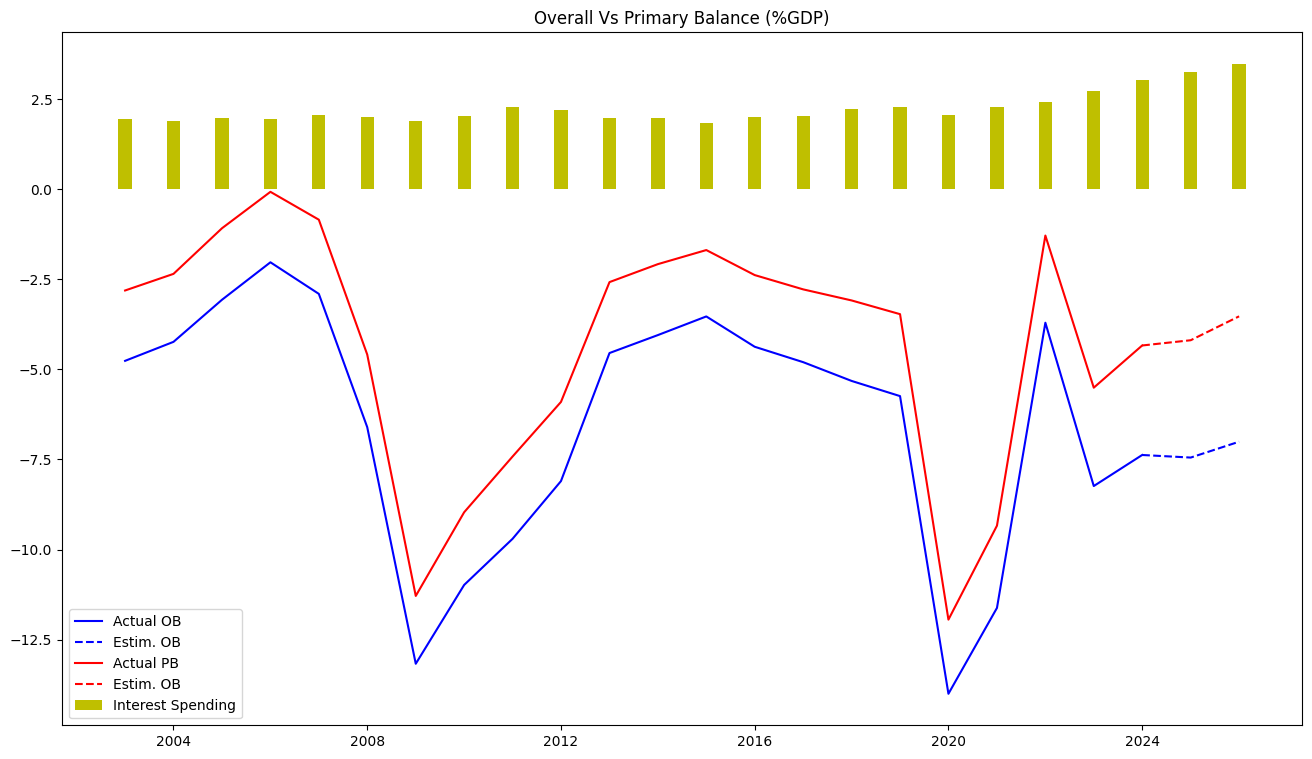

In [ ]:
#Plot Overall vs Primary Balance and Interest Spending
plt.figure(figsize=(16,9))
plt.bar(fiscal_monitor.index, fiscal_monitor['Interest Spending'], width=100, color='y')
plt.plot(fiscal_monitor['Overall Balance (% GDP)'].loc[:today], color='blue')
plt.plot(fiscal_monitor['Overall Balance (% GDP)'].loc[today:], linestyle='--', color='blue')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[:today], color='red')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[today:], linestyle='--', color='red')
plt.title('Overall Vs Primary Balance (%GDP)')
plt.legend(['Actual OB', 'Estim. OB', 'Actual PB', 'Estim. OB', 'Interest Spending'])
plt.show()

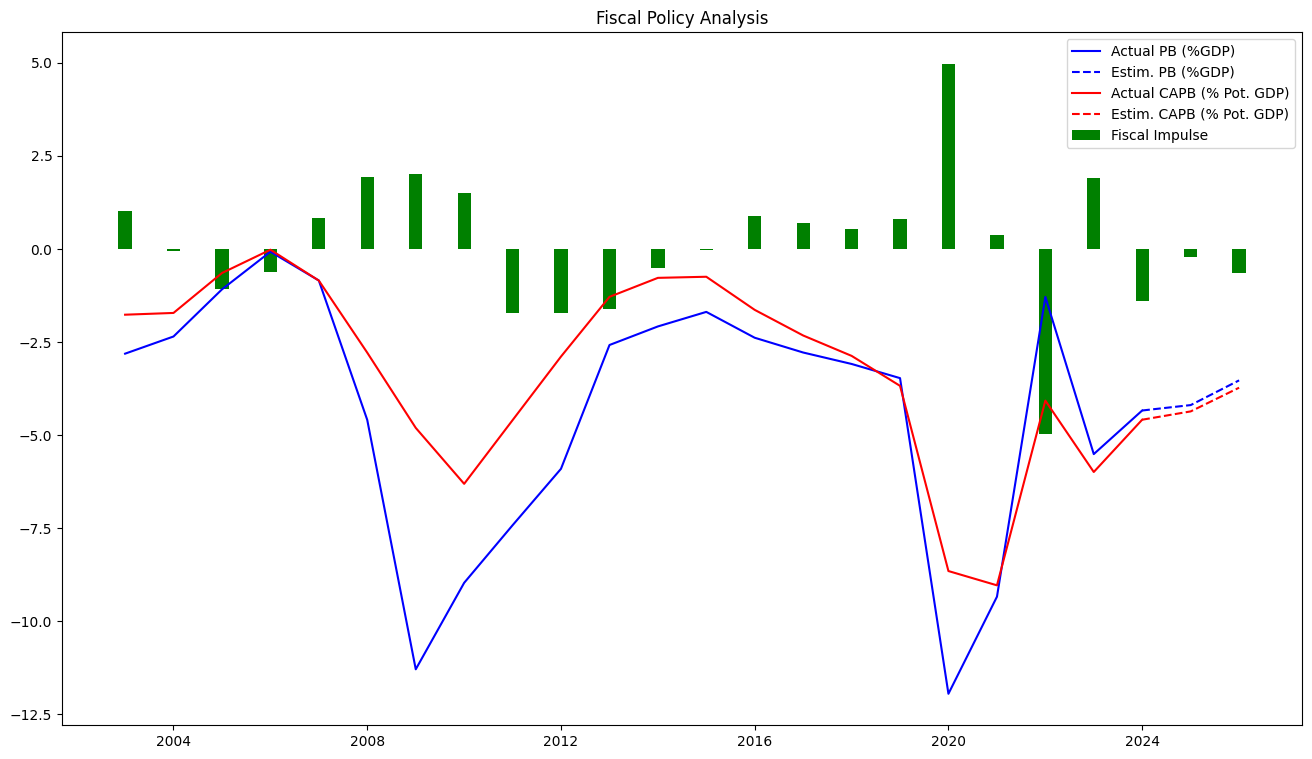

In [ ]:
#Plot fiscal impulse to analyze if the fiscal policy is pro-cyclical or counter-cyclical
plt.figure(figsize=(16,9))
plt.bar(fiscal_monitor.index, fiscal_monitor['Fiscal Impulse'], width=100, color='g')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[:today], color='blue')
plt.plot(fiscal_monitor['Primary Balance (% GDP)'].loc[today:], linestyle='--', color='blue')
plt.plot(fiscal_monitor['Cyclically Adjusted Primary Balance (% Pot. GDP)'].loc[:today], color='red')
plt.plot(fiscal_monitor['Cyclically Adjusted Primary Balance (% Pot. GDP)'].loc[today:], linestyle='--', color='red')
plt.title('Fiscal Policy Analysis')
plt.legend(['Actual PB (%GDP)', 'Estim. PB (%GDP)', 'Actual CAPB (% Pot. GDP)', 'Estim. CAPB (% Pot. GDP)','Fiscal Impulse'])
plt.show()

When Primary Balance > Cyclically Adjusted Primary Balance, output gap is positive: if fiscal impulse is positive, then fiscal policy is pro-cyclical, otherwise it is counter-cyclical.

When Primary Balance < Cyclically Adjusted Primary Balance, output gap is negative: if fiscal impulse is negative, then fiscal policy is pro-cyclical, otherwise it is counter-cyclical.

Generally, we would like to see counter-cyclical fiscal policy to face short-term business cycle needs, but sometimes fiscal policy is pro-cyclical in order to balance medium-term fiscal policy sustainability.

# Section 8: Fiscal Sustainability Analysis

In this section we are going to look at how Debt to GDP varies according to different scenarios: in fact, changing hypothesis about gdp growth, interest rates, primary balance and currency depreciation/appreciation, we will obtain different paths of debt evolution.

In [ ]:
#Fetch and plot Debt to GDP data
gross_debt_gdp = fetch_series('IMF/FM/A.US.G_XWDG_G01_GDP_PT')
gross_debt_gdp = clean_data(gross_debt_gdp, 'Gross Debt to GDP')

net_debt_gdp = fetch_series('IMF/FM/A.US.GGXWDN_G01_GDP_PT')
net_debt_gdp = clean_data(net_debt_gdp, 'Net Debt to GDP')

In [ ]:
gross_debt_gdp.tail(7)

Gross Debt to GDP
period                       
2022-01-01         121.306431
2023-01-01         123.284833
2024-01-01         126.854686
2025-01-01         130.254520
2026-01-01         132.856172
2027-01-01         135.110000
2028-01-01         137.489661

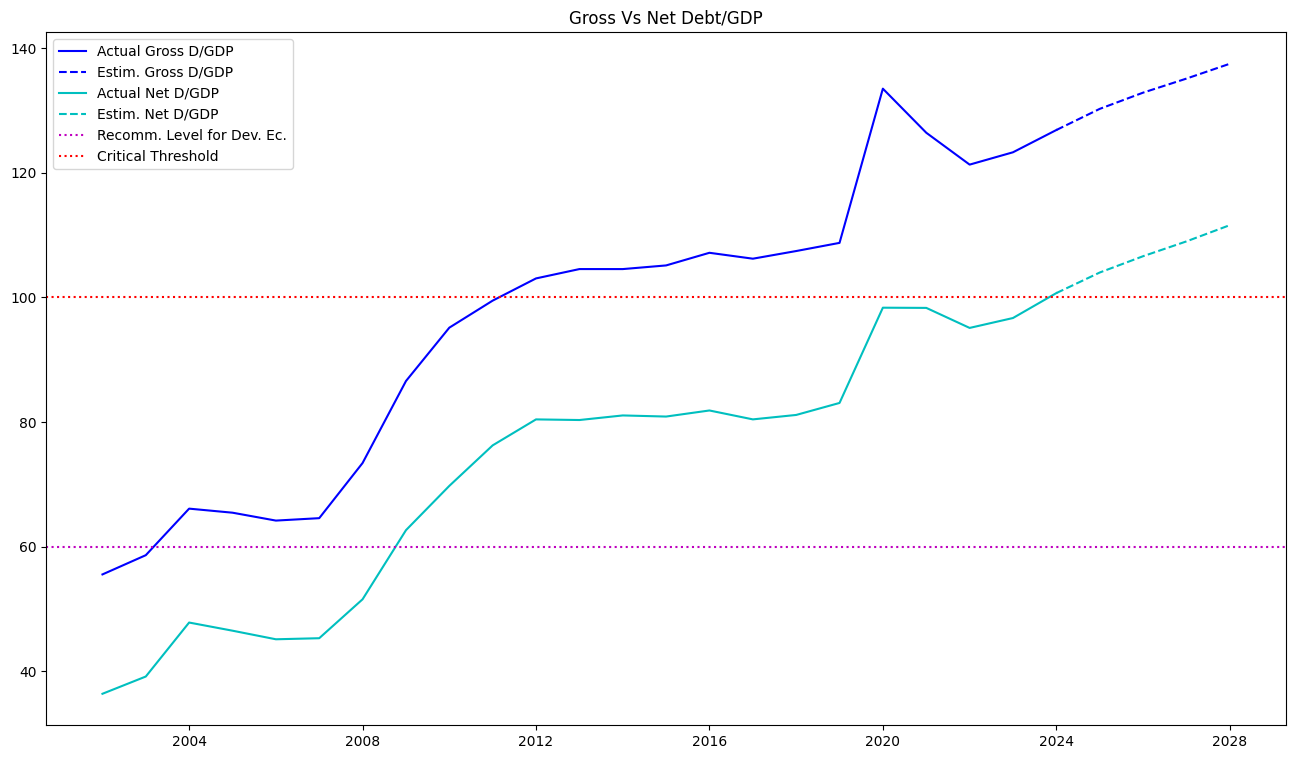

In [ ]:
#Plot gross vs net Debt to GDP
plt.figure(figsize=(16,9))
plt.plot(gross_debt_gdp.loc[:today], color='b')
plt.plot(gross_debt_gdp.loc[today:], linestyle='--', color='b')
plt.plot(net_debt_gdp.loc[:today], color='c')
plt.plot(net_debt_gdp.loc[today:], linestyle='--', color='c')
plt.axhline(y=60, color='m', linestyle='dotted')
plt.axhline(y=100, color='red', linestyle='dotted')
plt.title('Gross Vs Net Debt/GDP')
plt.legend(['Actual Gross D/GDP', 'Estim. Gross D/GDP', 'Actual Net D/GDP', 'Estim. Net D/GDP', 'Recomm. Level for Dev. Ec.', 'Critical Threshold'])
plt.show()

In [ ]:
#Let's define a function to calculate Public Debt to GDP
def fiscal_debt_path(gr1, gr2, gr3, gr4, gr5, r1, r2, r3, r4, r5, pb1, pb2, pb3, pb4, pb5):

    public_debt_t0 = gross_debt_gdp.loc[today]

    public_debt_t1 = (1 + r1) / (1 + gr1) * public_debt_t0 - pb1
    public_debt_t2 = (1 + r2) / (1 + gr2) * public_debt_t1 - pb2
    public_debt_t3 = (1 + r3) / (1 + gr3) * public_debt_t2 - pb3
    public_debt_t4 = (1 + r4) / (1 + gr4) * public_debt_t3 - pb4
    public_debt_t5 = (1 + r5) / (1 + gr5) * public_debt_t4 - pb5

    rng = pd.date_range(today, periods=6, freq='YS')
    scenario = pd.DataFrame()
    scenario = scenario.append([public_debt_t0, public_debt_t1, public_debt_t2, public_debt_t3, public_debt_t4, public_debt_t5])
    scenario = scenario.set_index(rng)

    plt.figure(figsize=(15,7))
    plt.plot(scenario, color='b', marker='s')
    plt.title('Public Debt to GDP - Scenario Analysis')


interactive(children=(FloatSlider(value=0.0, description='gr1', max=0.1, min=-0.1, step=0.005), FloatSlider(va…

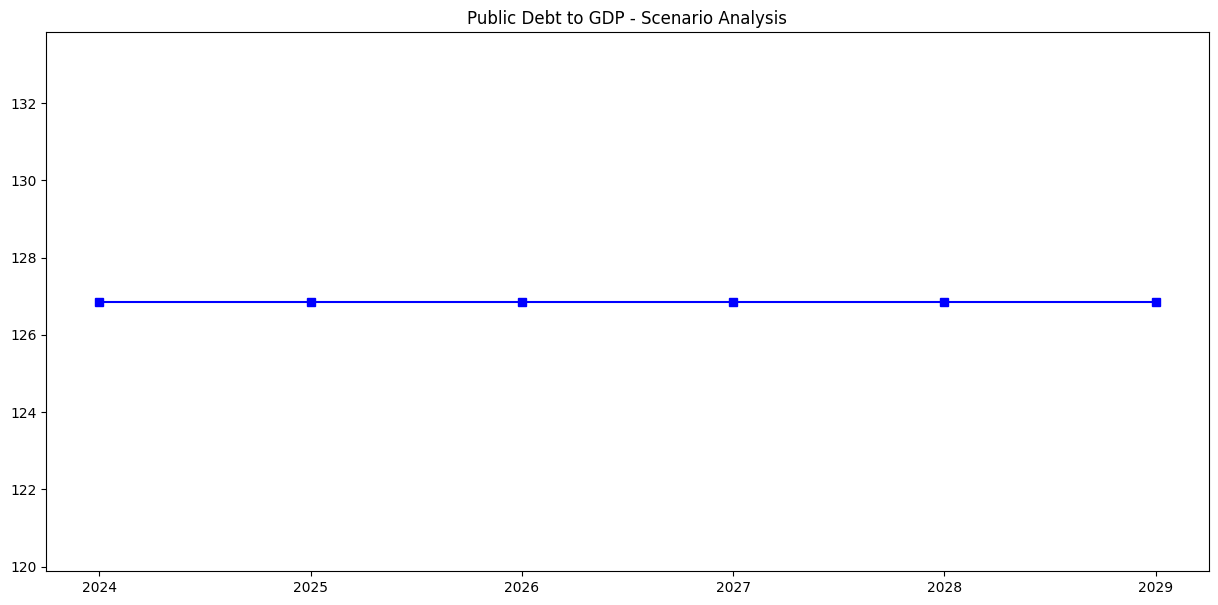

In [ ]:
#Create a slider to make scenario analysis for Public Debt to GDP
widgets.interact(fiscal_debt_path, gr1=(-0.1, 0.1, 0.005), gr2=(-0.1, 0.1, 0.005), gr3=(-0.1, 0.1, 0.005), gr4=(-0.1, 0.1, 0.005), gr5=(-0.1, 0.1, 0.005), r1=(-0.1, 0.1, 0.005), r2=(-0.1, 0.1, 0.005), r3=(-0.1, 0.1, 0.005), r4=(-0.1, 0.1, 0.005), r5=(-0.1, 0.1, 0.005), pb1=(-15, 15, 1), pb2=(-15, 15, 1), pb3=(-15, 15, 1), pb4=(-15, 15, 1), pb5=(-15, 15, 1));

# Section 9: External Position Analysis

In this section we will analyze the current account situation of the country. Specifically, we want to understand if the country is running a surplus or a deficit. The CA can be seen from two perspectives: net exports + primary and secondary income; or savings - investment. A deficit means the country is receiving more flows from abroad to finance its investment and have imports > exports; a surplus means that the country is investing more abroad to fund foreign countries investment and have exports > imports. We will also analyze the different components of the financial account.

In [ ]:
#Fetch quarterly CA data in USD and in %GDP
ca_usd_q = fetch_series('OECD/MEI/USA.B6BLTT01.CXCUSA.Q')
ca_usd_q = clean_data(ca_usd_q, 'Current Account - Tot. Balance (USD)')

ca_gdp_q = fetch_series('OECD/MEI/USA.B6BLTT02.STSA.Q')
ca_gdp_q = clean_data(ca_gdp_q, 'Current Account - Tot. Balance (%GDP)')

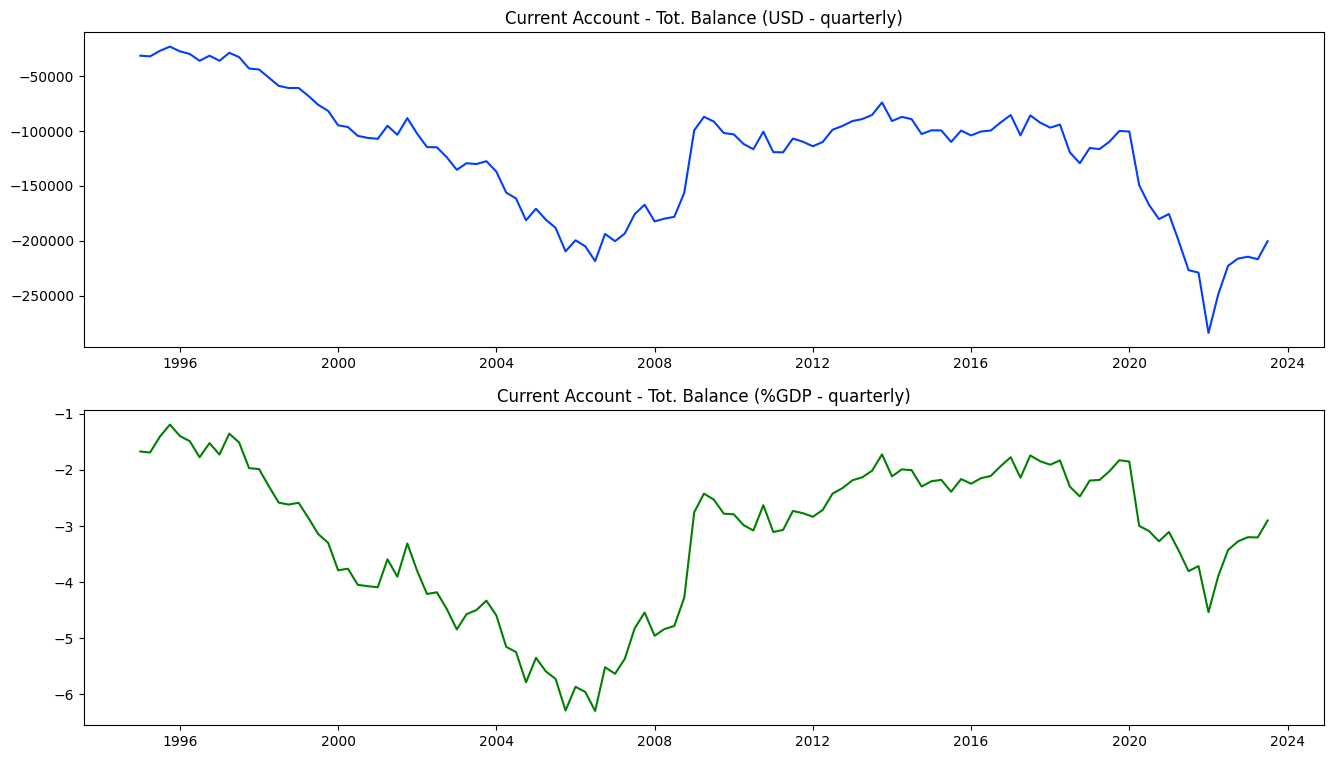

In [ ]:
#Plot CA quarterly data
plt.subplots(figsize=(16,9))
plt.subplot(211)
plt.plot(ca_usd_q)
plt.title('Current Account - Tot. Balance (USD - quarterly)')

plt.subplot(212)
plt.plot(ca_gdp_q, color='g')
plt.title('Current Account - Tot. Balance (%GDP - quarterly)')

plt.show()

In [ ]:
#Fetch Current Account, Savings and Investments data (annual figures)
ca = fetch_series('IMF/WEO:2021-10/USA.BCA_NGDPD.pcent_gdp')
ca = clean_data(ca, 'Current Account - %GDP')

savings = fetch_series('IMF/WEO:2021-10/USA.NGSD_NGDP.pcent_gdp')
savings = clean_data(savings, 'Gross National Savings - %GDP')

investments = fetch_series('IMF/WEO:2021-10/USA.NID_NGDP.pcent_gdp')
investments = clean_data(investments, 'Total Investments - %GDP')

ext_pos = pd.concat([ca, savings, investments], axis=1)

ext_pos.tail()

Current Account - %GDP  Gross National Savings - %GDP  \
period                                                              
2022-01-01                  -3.500                         20.186   
2023-01-01                  -3.293                         20.421   
2024-01-01                  -2.950                         20.617   
2025-01-01                  -2.625                         20.797   
2026-01-01                  -2.364                         20.940   

            Total Investments - %GDP  
period                                
2022-01-01                    22.377  
2023-01-01                    22.465  
2024-01-01                    22.366  
2025-01-01                    22.265  
2026-01-01                    22.190

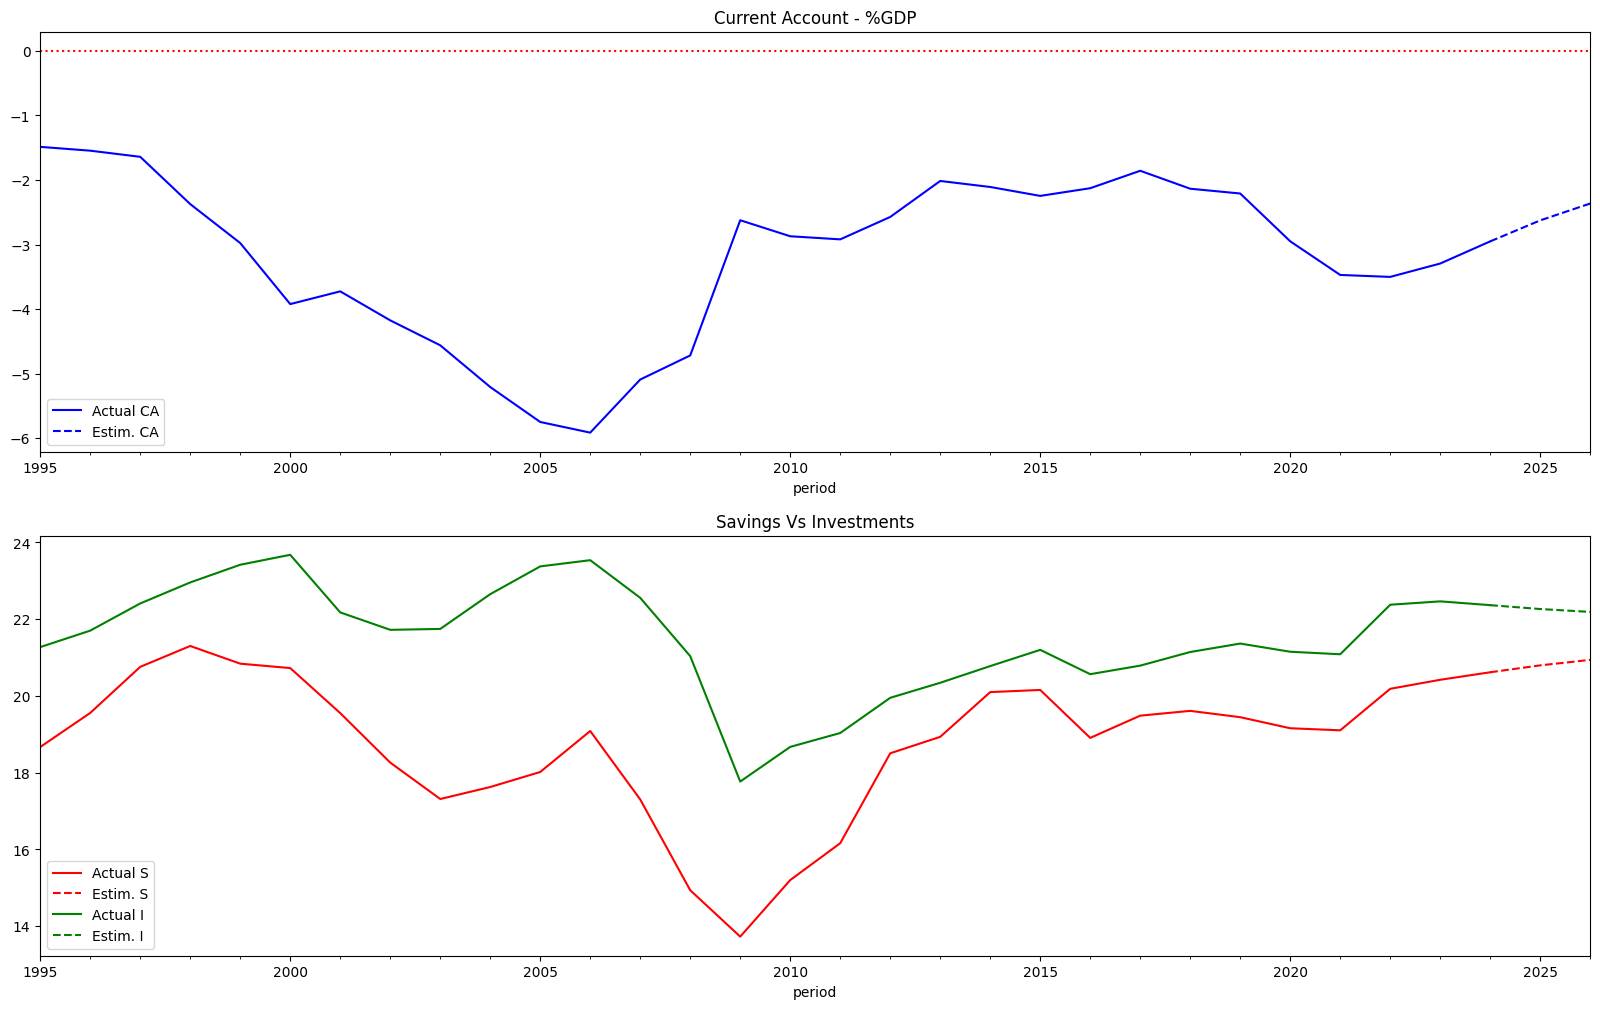

In [ ]:
#Plot decomposition of CA
plt.figure(figsize=(20,12))

plt.subplot(211)
ext_pos['Current Account - %GDP'].loc[:today].plot(color='blue')
ext_pos['Current Account - %GDP'].loc[today:].plot(color='blue', linestyle='--')
plt.axhline(y=0, color='red', linestyle='dotted')
plt.title('Current Account - %GDP')
plt.legend(['Actual CA', 'Estim. CA'])

plt.subplot(212)
ext_pos['Gross National Savings - %GDP'].loc[:today].plot(color='red')
ext_pos['Gross National Savings - %GDP'].loc[today:].plot(color='red', linestyle='--')
ext_pos['Total Investments - %GDP'].loc[:today].plot(color='green')
ext_pos['Total Investments - %GDP'].loc[today:].plot(color='green', linestyle='--')
plt.title('Savings Vs Investments')
plt.legend(['Actual S', 'Estim. S', 'Actual I', 'Estim. I'])
plt.show()

If the country is running a current account deficit this means that our investment is being funded from abroad. From the financial perspective the country is accumulating liabilities. On the contrary, a current account surplus tells us that the country is providing savings to fund investment in other countries. From the financial perspective it is accumulating assets.

In [ ]:
#Fetch quarterly data on Terms of Trade and Current account
tot = fetch_series('AMECO/APGS/USA.3.0.0.0.APGS')
tot = clean_data(tot, 'Terms of Trade goods and services - A')


ca_ann = fetch_series('OECD/EO/USA.CBGDPR.A')
ca_ann = clean_data(ca_ann, 'Current Account - A')

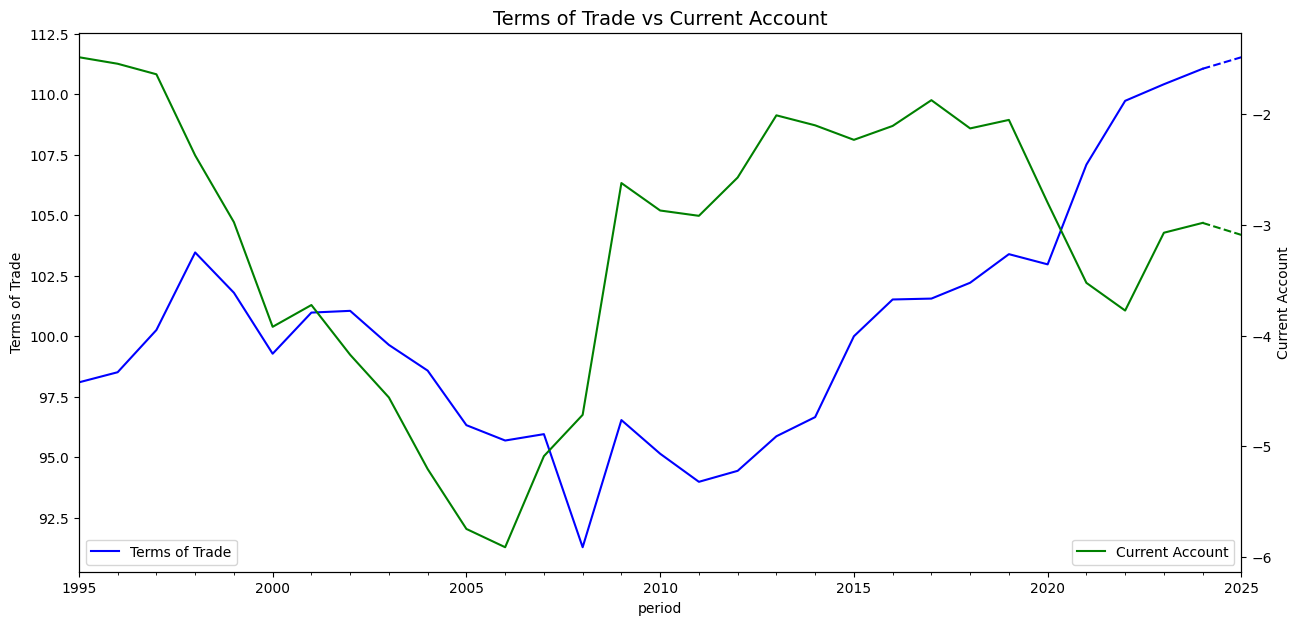

In [ ]:
#Plot Terms of Trade and CA data
fig, ax = plt.subplots(figsize=(15,7))
ax=tot.loc[:today].plot(ax=ax, color='b', legend=False)
ax=tot.loc[today:].plot(ax=ax, color='b', linestyle='--', legend=False)
ax1=ca_ann.loc[:today].plot(ax=ax, color='g', legend=False, secondary_y=True)
ax1=ca_ann.loc[today:].plot(ax=ax, color='g', legend=False, secondary_y=True, linestyle='--')
plt.title('Terms of Trade vs Current Account', fontsize =14)

ax.legend(['Terms of Trade'], loc='lower left')
ax1.legend(['Current Account'], loc='lower right')

ax.set(ylabel='Terms of Trade')
ax1.set(ylabel='Current Account')

plt.show()

External Terms of Trade (i.e. Price of exports / Price of imports) tell us how much did the changes in export prices or import prices, holding all else constant, boost or push down the CA balance.

In [ ]:
#Fetch REER data
reer = fetch_series('IMF/IFS/Q.US.EREER_IX')
reer = clean_data(reer, 'REER - Q')

ca_q = fetch_series('OECD/EO/USA.CBGDPR.Q')
ca_q = clean_data(ca_q, 'Current Account - Q')

ca_vs_reer = pd.concat([reer, ca_q], axis=1)
ca_vs_reer = ca_vs_reer.dropna()
ca_vs_reer.tail()

REER - Q  Current Account - Q
period                                     
2022-07-01  129.733987            -3.427738
2022-10-01  131.106269            -3.274018
2023-01-01  126.408994            -3.199451
2023-04-01  126.286847            -3.134965
2023-07-01  127.481853            -2.973756

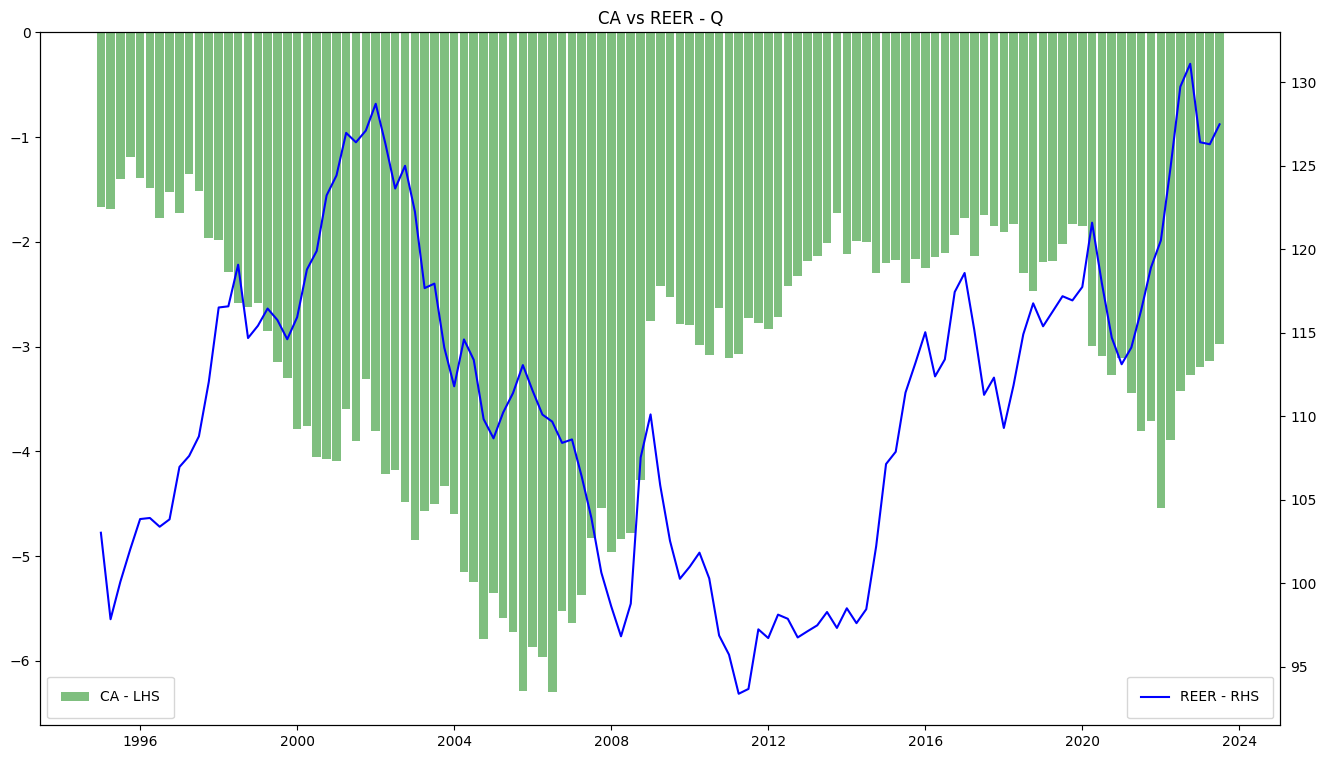

In [ ]:
#Plot REER and CA data
fig, ax = plt.subplots(figsize=(16,9))
ax = plt.bar(ca_vs_reer.index, ca_vs_reer['Current Account - Q'], width=80, color='g', alpha=0.5)
ax = plt.legend(['CA - LHS'], loc='lower left', borderpad=1)
plt.twinx()
ax1 = plt.plot(ca_vs_reer['REER - Q'], color='b')
ax1 = plt.legend(['REER - RHS'], loc='lower right', borderpad=1)
plt.title('CA vs REER - Q')

plt.show()

The Real Exchange Rate is inversely proportioned to the CA. In fact, an appreciation of the REER leads to an increasing CA deficit (because exports tend to decrease compared to imports if the currency appreciates); on the other hand, if the REER depreciates, we may expect a decreasing deficit or an increasing surplus (because exports tend to increase compared to imports if the currency depreciates). The elasticity of CA to variations in REER is given by eta (i.e. the CA elasticity).

In [ ]:
fa = ['IMF/BOPAGG/A.US.BFD_BP6_USD',
       'IMF/BOPAGG/A.US.BFF_BP6_USD',
       'IMF/BOPAGG/A.US.BFOFR_BP6_USD',
       'IMF/BOPAGG/A.US.BFP_BP6_USD',
       'IMF/BOPAGG/A.US.BFRAFR_BP6_USD',
       'IMF/BOPAGG/A.US.BOPFR_BP6_USD']

fin_acc = pd.DataFrame()

for i in fa:
    fin_acc = fin_acc.append(fetch_series(i)[['period', 'series_name', 'value']])

fin_acc = fin_acc.pivot(index='period', columns='series_name', values='value')

ann_gdp = fetch_series('OECD/QNA/USA.B1_GS1.CARSA.A')
ann_gdp = clean_data(ann_gdp, 'Annual GDP')

fin_acc['GDP'] = ann_gdp

fin_acc = fin_acc.dropna()
fin_acc.head()

series_name  Annual – United States – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                                  
2006-01-01                                            -29710.0                                                                                          
2007-01-01                                             -6222.0                                                                                          
2008-01-01                                             32947.0                                                                                          
2009-01-01                                            -44816.0                                                                                          
2010-01-01                                            -14076.0                                                                                          

series_name  Annual – United States – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                                   
2006-01-01                                            -14662.0                                                                                                           
2007-01-01                                            177277.0                                                                                                           
2008-01-01                                              2491.0                                                                                                           
2009-01-01                                            151514.0                                                                                                           
2010-01-01                                             85789.0                                                                                                           

series_name  Annual – United States – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                                
2006-01-01                                           -633367.0                                        
2007-01-01                                           -775806.0                                        
2008-01-01                                           -807954.0                                        
2009-01-01                                             18530.0                                        
2010-01-01                                           -620815.0                                        

series_name  Annual – United States – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                                     
2006-01-01                                        -1501.315217                                                             
2007-01-01                                       109776.068325                                                             
2008-01-01                                       -50368.021762                                                             
2009-01-01                                       146246.619422                                                             
2010-01-01                                        -7502.950633                                                             

series_name  Annual – United States – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                

In [ ]:
fin_acc_to_gdp = fin_acc.iloc[:,:-1].div(fin_acc.GDP, axis=0)
fin_acc_to_gdp.head()

series_name  Annual – United States – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                                  
2006-01-01                                           -0.002150                                                                                          
2007-01-01                                           -0.000430                                                                                          
2008-01-01                                            0.002231                                                                                          
2009-01-01                                           -0.003095                                                                                          
2010-01-01                                           -0.000935                                                                                          

series_name  Annual – United States – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                                   
2006-01-01                                           -0.001061                                                                                                           
2007-01-01                                            0.012248                                                                                                           
2008-01-01                                            0.000169                                                                                                           
2009-01-01                                            0.010465                                                                                                           
2010-01-01                                            0.005701                                                                                                           

series_name  Annual – United States – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                                
2006-01-01                                           -0.045844                                        
2007-01-01                                           -0.053599                                        
2008-01-01                                           -0.054703                                        
2009-01-01                                            0.001280                                        
2010-01-01                                           -0.041253                                        

series_name  Annual – United States – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                                     
2006-01-01                                           -0.000109                                                             
2007-01-01                                            0.007584                                                             
2008-01-01                                           -0.003410                                                             
2009-01-01                                            0.010101                                                             
2010-01-01                                           -0.000499                                                             

series_name  Annual – United States – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                

In [ ]:
fin_acc_to_gdp = fin_acc_to_gdp * 100
fin_acc_to_gdp.tail()

series_name  Annual – United States – Financial account, Financial derivatives (other than reserves) and employee stock options, US Dollars, Millions  \
period                                                                                                                                                  
2018-01-01                                           -0.098778                                                                                          
2019-01-01                                           -0.193621                                                                                          
2020-01-01                                           -0.023951                                                                                          
2021-01-01                                           -0.165415                                                                                          
2022-01-01                                           -0.313462                                                                                          

series_name  Annual – United States – Financial account, Net lending (+) / net borrowing (-) (balance from financial account), Direct investment, US Dollars, Millions  \
period                                                                                                                                                                   
2018-01-01                                           -1.672281                                                                                                           
2019-01-01                                           -0.934219                                                                                                           
2020-01-01                                            0.695490                                                                                                           
2021-01-01                                           -0.419661                                                                                                           
2022-01-01                                            0.148279                                                                                                           

series_name  Annual – United States – Financial account, Portfolio investment, US Dollars, Millions  \
period                                                                                                
2018-01-01                                            0.381405                                        
2019-01-01                                           -1.138030                                        
2020-01-01                                           -2.533383                                        
2021-01-01                                            0.412236                                        
2022-01-01                                           -1.700047                                        

series_name  Annual – United States – Supplementary Items, Errors and Omissions (with Fund Record), US Dollars, Millions  \
period                                                                                                                     
2018-01-01                                            0.683819                                                             
2019-01-01                                           -0.511816                                                             
2020-01-01                                           -0.310396                                                             
2021-01-01                                            0.191316                                                             
2022-01-01                                            0.665807                                                             

series_name  Annual – United States – Supplementary Items, Other Investment Net (with Fund Record), US Dollars, Millions  \
period                

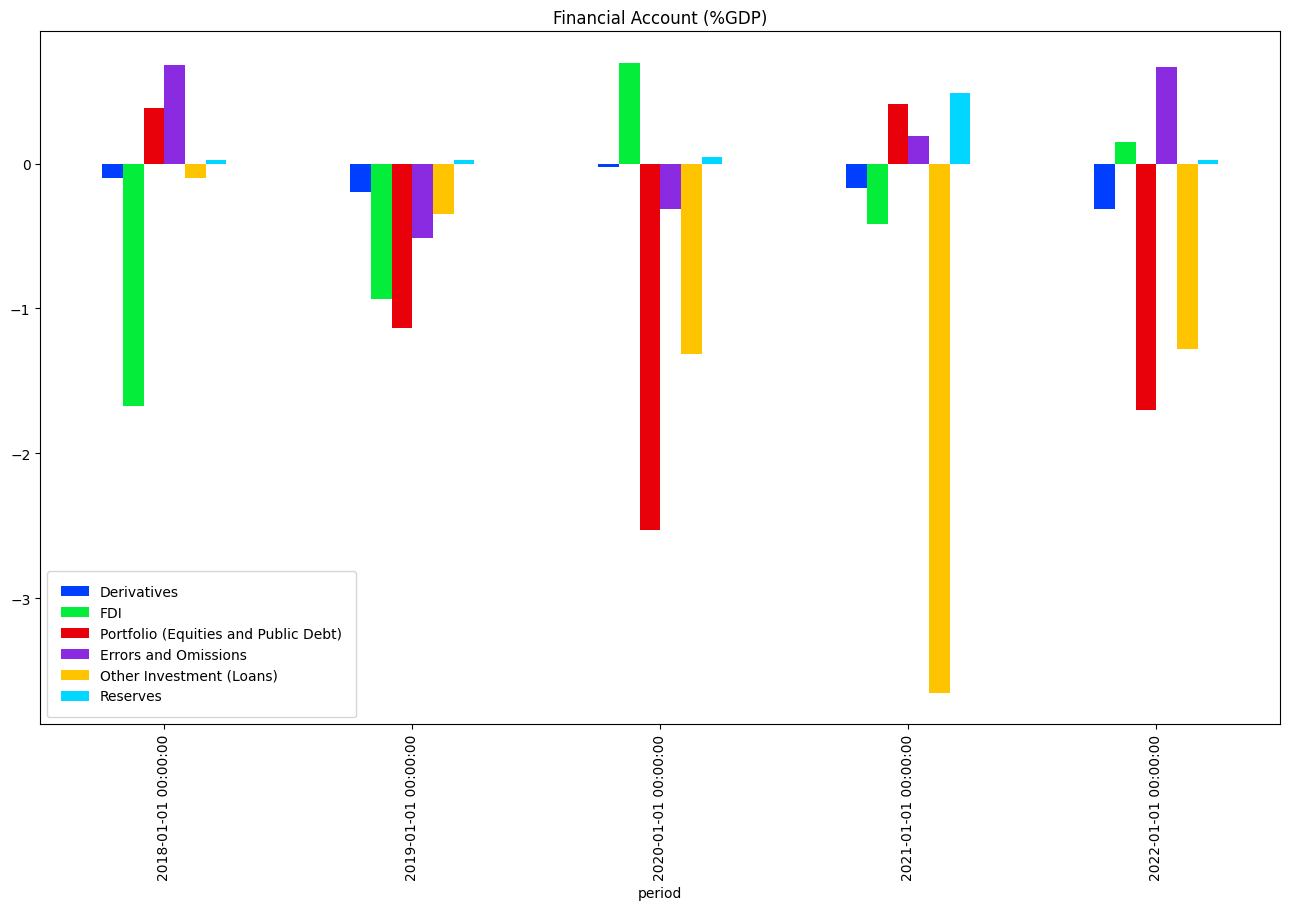

In [ ]:
#Plot financial account components evolution
fin_acc_to_gdp.iloc[-5:].plot(kind='bar', figsize=(16,9))
plt.legend(['Derivatives', 'FDI', 'Portfolio (Equities and Public Debt)', 'Errors and Omissions', 'Other Investment (Loans)', 'Reserves'], loc='lower left', borderpad=1)
plt.title('Financial Account (%GDP)')
plt.show()

The Financial Account has to be interpreted as: if CA > 0, then FA > 0; if CA < 0, then FA < 0. In fact, the financial account is the way current account is financed. Therefore, a negative change in FDI/Portfolio/Derivatives/Other Investment means that the country is accumulating more liabilities (i.e. inward flows > outward flows); on the contrary, if there is a positive change in FDI/Portfolio/Derivatives/Other Investment this means that the country is accumulating more assets abroad (i.e. inward flows < outward flows). When reserves are decreasing, it's likely that the country is financing temporary shocks to the CA with its stock of reserves. This is a short-term strategy that cannot be sustained for long periods, especially if reserves are depleted rapidly. In fact, in such instances speculative attacks on the local currency can easily take place.

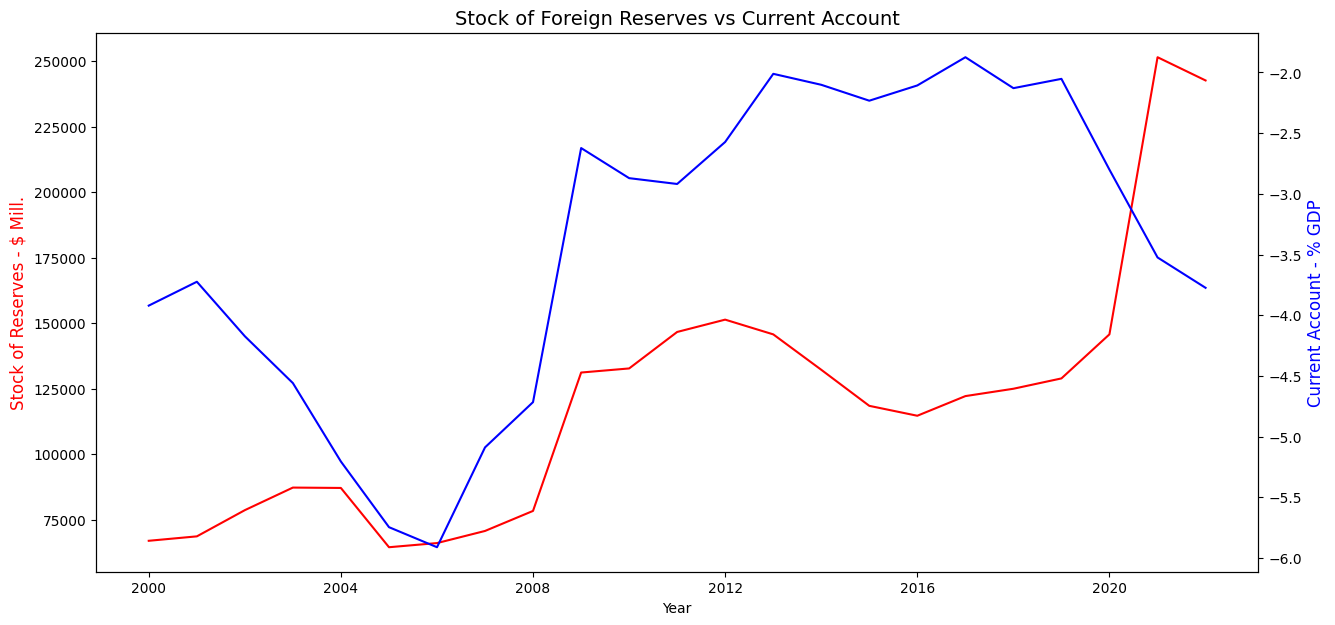

In [ ]:
#Download stock of foreign reserves data
fx_reserves = fetch_series('IMF/IRFCL/A.US.RAF_USD.S1X')
fx_reserves = clean_data(fx_reserves, 'Stock of Foreign Reserves - A')
fx_reserves['CA'] = ca_ann
fx_reserves = fx_reserves.dropna()

#Plot stock of foreign reserves data
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(fx_reserves.index, fx_reserves['Stock of Foreign Reserves - A'], color='r')
ax.set_xlabel('Year')
ax.set_ylabel('Stock of Reserves - $ Mill.', fontsize=12, color='r')
ax2 = ax.twinx()
ax2.plot(fx_reserves.index, fx_reserves['CA'], color='b')
ax2.set_ylabel('Current Account - % GDP', fontsize=12, color='b')

plt.title('Stock of Foreign Reserves vs Current Account', fontsize=14)
plt.show()

# Section 10: Real Exchange Rate and Competitiveness

In this section we are looking at how the current account and REER are positioned relative to their equilibrium levels. Specifically, with the help of the IMF External Balance Assessment framework, we will see if the country is running a positive current account gap (i.e., Actual CA > Norm CA) or a negative current account gap (i.e., Actual CA < Norm CA). In the former case, the REER is relatively undervalued and it has to appreciate to bring the CA balance back to its equilibrium level (in this scenario, exports are more stimulated than imports); in the latter case, REER is to be considered overvalued and it has to depreciate to bring the CA balance back to its equilibrium level (in this scenario, imports are more stimulated than exports).

There are several methods used by IMF to assess the current account gap and REER gap compared to their equilibrium level (i.e., EBA CA Regression, External Sustainability approach, EBA REER Regression). Since data for these estimates cannot be downloaded from public datasets and that calculations are not easy to implement, we will only report lates data from the IMF EBA website and compared them with significant thresholds.

https://www.imf.org/external/np/res/eba/data.htm

In [ ]:
#CURRENT ACCOUNT REGRESSION-BASED ANALYSIS
period = [2014, 2015, 2016, 2017, 2018, 2019, 2020]

reg_ca_gap = [-1.2, -1.7, -1.0, -1.6, -1.2, -1.3, -2.2]

In [ ]:
#EXTERNAL SUSTAINABILITY ANALYSIS
es_ca_gap = [-1.2, -1.3, -2.0, -1.5, -1.2, -1.2, 0.5]

In [ ]:
#REER REGRESSION-BASED ANALYSIS: INDEX REER
index_reer_gap = [2.3, 14.1, 15.8, 8.1, 8.0 ,8.1, 8.3]

In [ ]:
#REER REGRESSION-BASED ANALYSIS: LEVEL REER
level_reer_gap = [8.2, 23.3, 25.0, 14.4, 11.9, 10.9, 12.4]

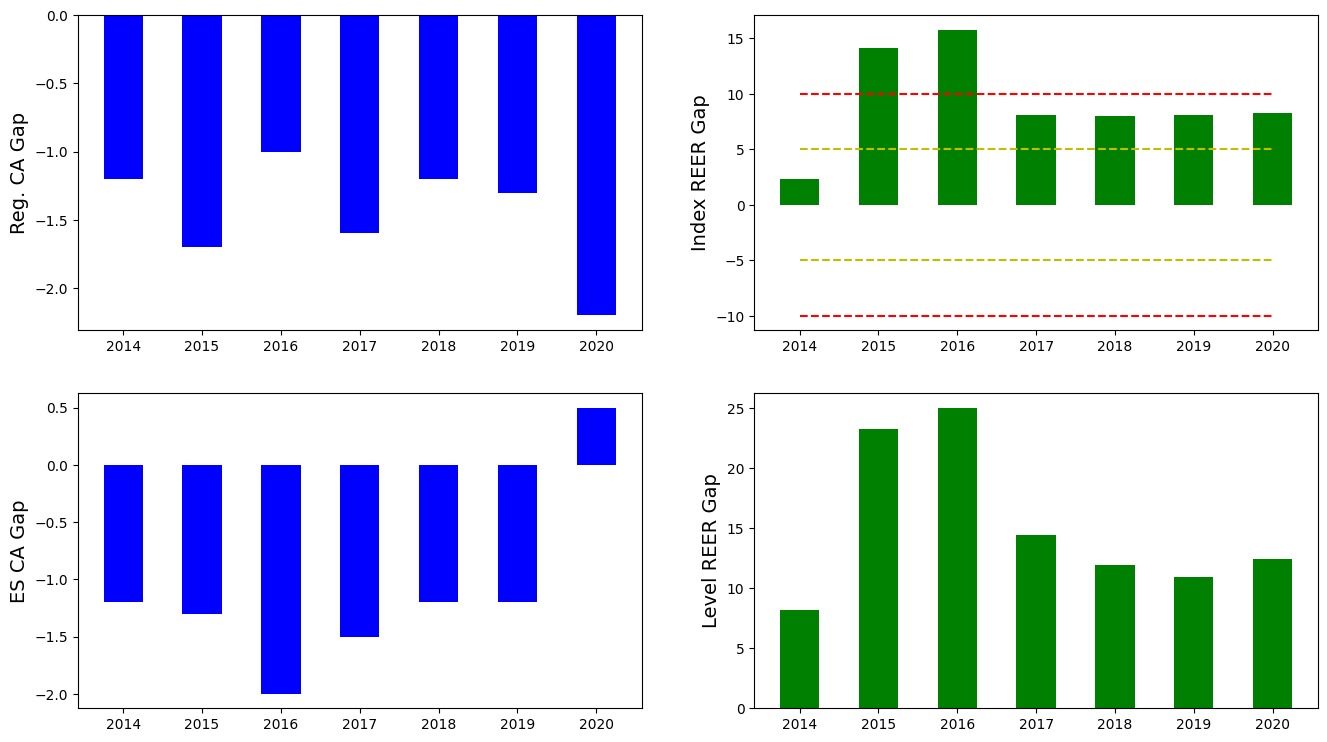

In [ ]:
#Plot CA and REER gap according to EBA framework
fig, axs = plt.subplots(2, 2, figsize=(16, 9))

axs[0,0].bar(period, reg_ca_gap, width=0.5, color='b')
axs[0,0].set_ylabel('Reg. CA Gap', fontsize=14)

axs[1,0].bar(period, es_ca_gap, width=0.5, color='b')
axs[1,0].set_ylabel('ES CA Gap', fontsize=14)

axs[0,1].bar(period, index_reer_gap, width=0.5, color='g')
axs[0,1].plot([period[0], period[-1]], [5,5], color='y', linestyle='--')

axs[0,1].plot([period[0], period[-1]], [10,10], color='r', linestyle='--')
axs[0,1].plot([period[0], period[-1]], [-5,-5], color='y', linestyle='--')

axs[0,1].plot([period[0], period[-1]], [-10,-10], color='r', linestyle='--')
axs[0,1].set_ylabel('Index REER Gap', fontsize=14)

axs[1,1].bar(period, level_reer_gap, width=0.5, color='g')
axs[1,1].set_ylabel('Level REER Gap', fontsize=14)

plt.show()

According to the IMF framework, if the value of the REER gap is between -5% and 5%, then the REER is broadly in line with fundamentals. If it is between -5% and -10% or between 5% and 10%, then it is moderately misaligned.

# Section 11: Trading Partners Analysis

In this section we will assess economic health status of main trading partners of the country to determine if there is an external threat to growth.

In [ ]:
#URL with the table containing the list of main trading partners
url="https://en.wikipedia.org/wiki/List_of_the_largest_trading_partners_of_the_United_States"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

In [ ]:
#Let’s just first print the title of the webpage
print(soup.title.text)

List of the largest trading partners of the United States - Wikipedia


In [ ]:
#Put data from Wikipedia into a DataFrame
tp_table = soup.find("table", attrs={"class": "wikitable"})
tp_data = pd.read_html(str(tp_table))
tp_data = pd.DataFrame(tp_data[0])
tp_data = tp_data.drop(['Exports', 'Imports'], axis=1)
tp_data.head(13)

Rank   Country/District  Total Trade  Trade Balance  Exports/Imports
0     -              World       4700.0        -1100.0            0.620
1     1             Canada        665.6          -50.0            0.860
2     2             Mexico        661.2         -108.2            0.718
3     3              China        655.4         -353.5            0.299
4     -  European Union[2]        631.8         -166.9            0.582
5     -              ASEAN        368.9         -183.1            0.336
6     4              Japan        209.5          -60.3            0.553
7     5            Germany        200.5          -69.9            0.482
8     6        South Korea        160.8          -29.0            0.694
9     7     United Kingdom        117.8            5.0            1.088
10    8             Taiwan        114.0          -40.2            0.478
11    9              India        113.3          -33.1            0.548
12   10            Vietnam        112.9          -90.9            0.108

In [ ]:
#Let's create a list with top trading partners GDP growth forecasts
tp_list = ['OECD/EO/CAN.GDP_ANNPCT.A',
          'OECD/EO/CHN.GDP_ANNPCT.A',
          'OECD/EO/DEU.GDP_ANNPCT.A',
          'OECD/EO/FRA.GDP_ANNPCT.A',
          'OECD/EO/GBR.GDP_ANNPCT.A',
          'OECD/EO/IND.GDP_ANNPCT.A',
          'OECD/EO/ITA.GDP_ANNPCT.A',
          'OECD/EO/JPN.GDP_ANNPCT.A',
          'OECD/EO/KOR.GDP_ANNPCT.A',
          'OECD/EO/MEX.GDP_ANNPCT.A']

#Fetch data of annual GDP grwoth for main trading partners and store them in a DataFrame
trad_part = pd.DataFrame()

for i in tp_list:
    trad_part = trad_part.append(fetch_series(i)[['period', 'series_name', 'value']])

trad_part = trad_part.pivot(index='period', columns='series_name', values='value')

trad_part.tail()

series_name  Canada – Gross domestic product, nominal value, growth – Annual  \
period                                                                         
2021-01-01                                           13.573769                 
2022-01-01                                           10.879225                 
2023-01-01                                            2.412212                 
2024-01-01                                            3.796231                 
2025-01-01                                            3.842859                 

series_name  China (People's Republic of) – Gross domestic product, nominal value, growth – Annual  \
period                                                                                               
2021-01-01                                           13.385398                                       
2022-01-01                                            5.305282                                       
2023-01-01                                            5.209021                                       
2024-01-01                                            6.454813                                       
2025-01-01                                            6.295344                                       

series_name  France – Gross domestic product, nominal value, growth – Annual  \
period                                                                         
2021-01-01                                            7.883399                 
2022-01-01                                            5.551594                 
2023-01-01                                            6.233626                 
2024-01-01                                            3.307105                 
2025-01-01                                            3.220360                 

series_name  Germany – Gross domestic product, nominal value, growth – Annual  \
period                                                                          
2021-01-01                                            6.229101                  
2022-01-01                                            7.257622                  
2023-01-01                                            6.196571                  
2024-01-01                                            3.046586                  
2025-01-01                                            2.985396                  

series_name  India – Gross domestic product, nominal value, growth – Annual  \
period                                                                        
2021-01-01                                           18.361564                
2022-01-01                                           16.061091                
2023-01-01                                            8.005571                
2024-01-01                                           11.082487                
2025-01-01                                           11.802452                

series_name  Italy – Gross domestic product, nominal value, growth – Annual  \
period                                                                        
2021-01-01                                            9.673293                
2022-01-01                                            6.976137                
2023-01-01                                            4.889896                
2024-01-01                                            3.612311                
2025-01-01                                            3.902248                

series_name  Japan – Gross domestic product, nominal value, growth – Annual  \
period                                                                        
2021-01-01                                            2.000743                
2022-01-01                                            1.212363                
2023-01-01                                            5.276027                
2024-01-01                                            3.632883                
2025-01-01   

In [ ]:
#Let's rename the columns
col_names = ['Canada', 'China', 'France', 'Germany', 'India', 'Italy', 'Japan', 'South Korea', 'Mexico', 'UK']
trad_part.columns = col_names
trad_part = trad_part.iloc[-3:]
trad_part.tail()

Canada     China    France   Germany      India     Italy  \
period                                                                    
2023-01-01  2.412212  5.209021  6.233626  6.196571   8.005571  4.889896   
2024-01-01  3.796231  6.454813  3.307105  3.046586  11.082487  3.612311   
2025-01-01  3.842859  6.295344  3.220360  2.985396  11.802452  3.902248   

               Japan  South Korea    Mexico        UK  
period                                                 
2023-01-01  5.276027     3.327563  7.288567  7.848475  
2024-01-01  3.632883     5.874346  6.241585  3.626921  
2025-01-01  3.415450     4.860449  4.838695  3.107470

In [ ]:
#Let's create a list with top trading partners imports (in USD) forecasts
tp_imp_list = ['OECD/EO/CAN.MGSD.A',
              'OECD/EO/CHN.MGSD.A',
              'OECD/EO/DEU.MGSD.A',
              'OECD/EO/FRA.MGSD.A',
              'OECD/EO/GBR.MGSD.A',
              'OECD/EO/IND.MGSD.A',
              'OECD/EO/ITA.MGSD.A',
              'OECD/EO/JPN.MGSD.A',
              'OECD/EO/KOR.MGSD.A',
              'OECD/EO/MEX.MGSD.A']

#Fetch data of annual GDP grwoth for main trading partners and store them in a DataFrame
trad_part_imp = pd.DataFrame()

for i in tp_imp_list:
    trad_part_imp = trad_part_imp.append(fetch_series(i)[['period', 'series_name', 'value']])

trad_part_imp = trad_part_imp.pivot(index='period', columns='series_name', values='value')

trad_part_imp.tail()

series_name  Canada – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                         
2021-01-01                                        6.197198e+11                                                 
2022-01-01                                        7.192551e+11                                                 
2023-01-01                                        7.143024e+11                                                 
2024-01-01                                        7.248813e+11                                                 
2025-01-01                                        7.512919e+11                                                 

series_name  China (People's Republic of) – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                                               
2021-01-01                                        3.093737e+12                                                                       
2022-01-01                                        3.139498e+12                                                                       
2023-01-01                                        3.086374e+12                                                                       
2024-01-01                                        3.188735e+12                                                                       
2025-01-01                                        3.379847e+12                                                                       

series_name  France – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                         
2021-01-01                                        9.404235e+11                                                 
2022-01-01                                        1.068857e+12                                                 
2023-01-01                                        1.066300e+12                                                 
2024-01-01                                        1.079972e+12                                                 
2025-01-01                                        1.118805e+12                                                 

series_name  Germany – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                          
2021-01-01                                        1.781465e+12                                                  
2022-01-01                                        1.989429e+12                                                  
2023-01-01                                        1.947858e+12                                                  
2024-01-01                                        1.957005e+12                                                  
2025-01-01                                        2.037224e+12                                                  

series_name  India – Imports of goods and services, nominal value in USD (national accounts basis) – Annual  \
period                                                                                                        
2021-01-01                                        7.119040e+11                                                
2022-01-01                                        8.972980e+11                                                
2023-01-01                                        8.401118e+11                                                
2024-01-01                                        9.003224e+11                                                
2025-01-01                       

In [ ]:
#Let's rename the columns
trad_part_imp.columns = col_names
trad_part_imp = trad_part_imp.iloc[-3:]
trad_part_imp.tail()

Canada         China        France       Germany  \
period                                                               
2023-01-01  7.143024e+11  3.086374e+12  1.066300e+12  1.947858e+12   
2024-01-01  7.248813e+11  3.188735e+12  1.079972e+12  1.957005e+12   
2025-01-01  7.512919e+11  3.379847e+12  1.118805e+12  2.037224e+12   

                   India         Italy         Japan   South Korea  \
period                                                               
2023-01-01  8.401118e+11  7.688887e+11  9.741933e+11  7.751046e+11   
2024-01-01  9.003224e+11  7.746695e+11  9.388327e+11  8.150440e+11   
2025-01-01  9.908230e+11  7.994744e+11  9.577506e+11  8.597812e+11   

                  Mexico            UK  
period                                  
2023-01-01  7.028148e+11  1.098980e+12  
2024-01-01  7.576678e+11  1.089305e+12  
2025-01-01  8.175713e+11  1.112561e+12

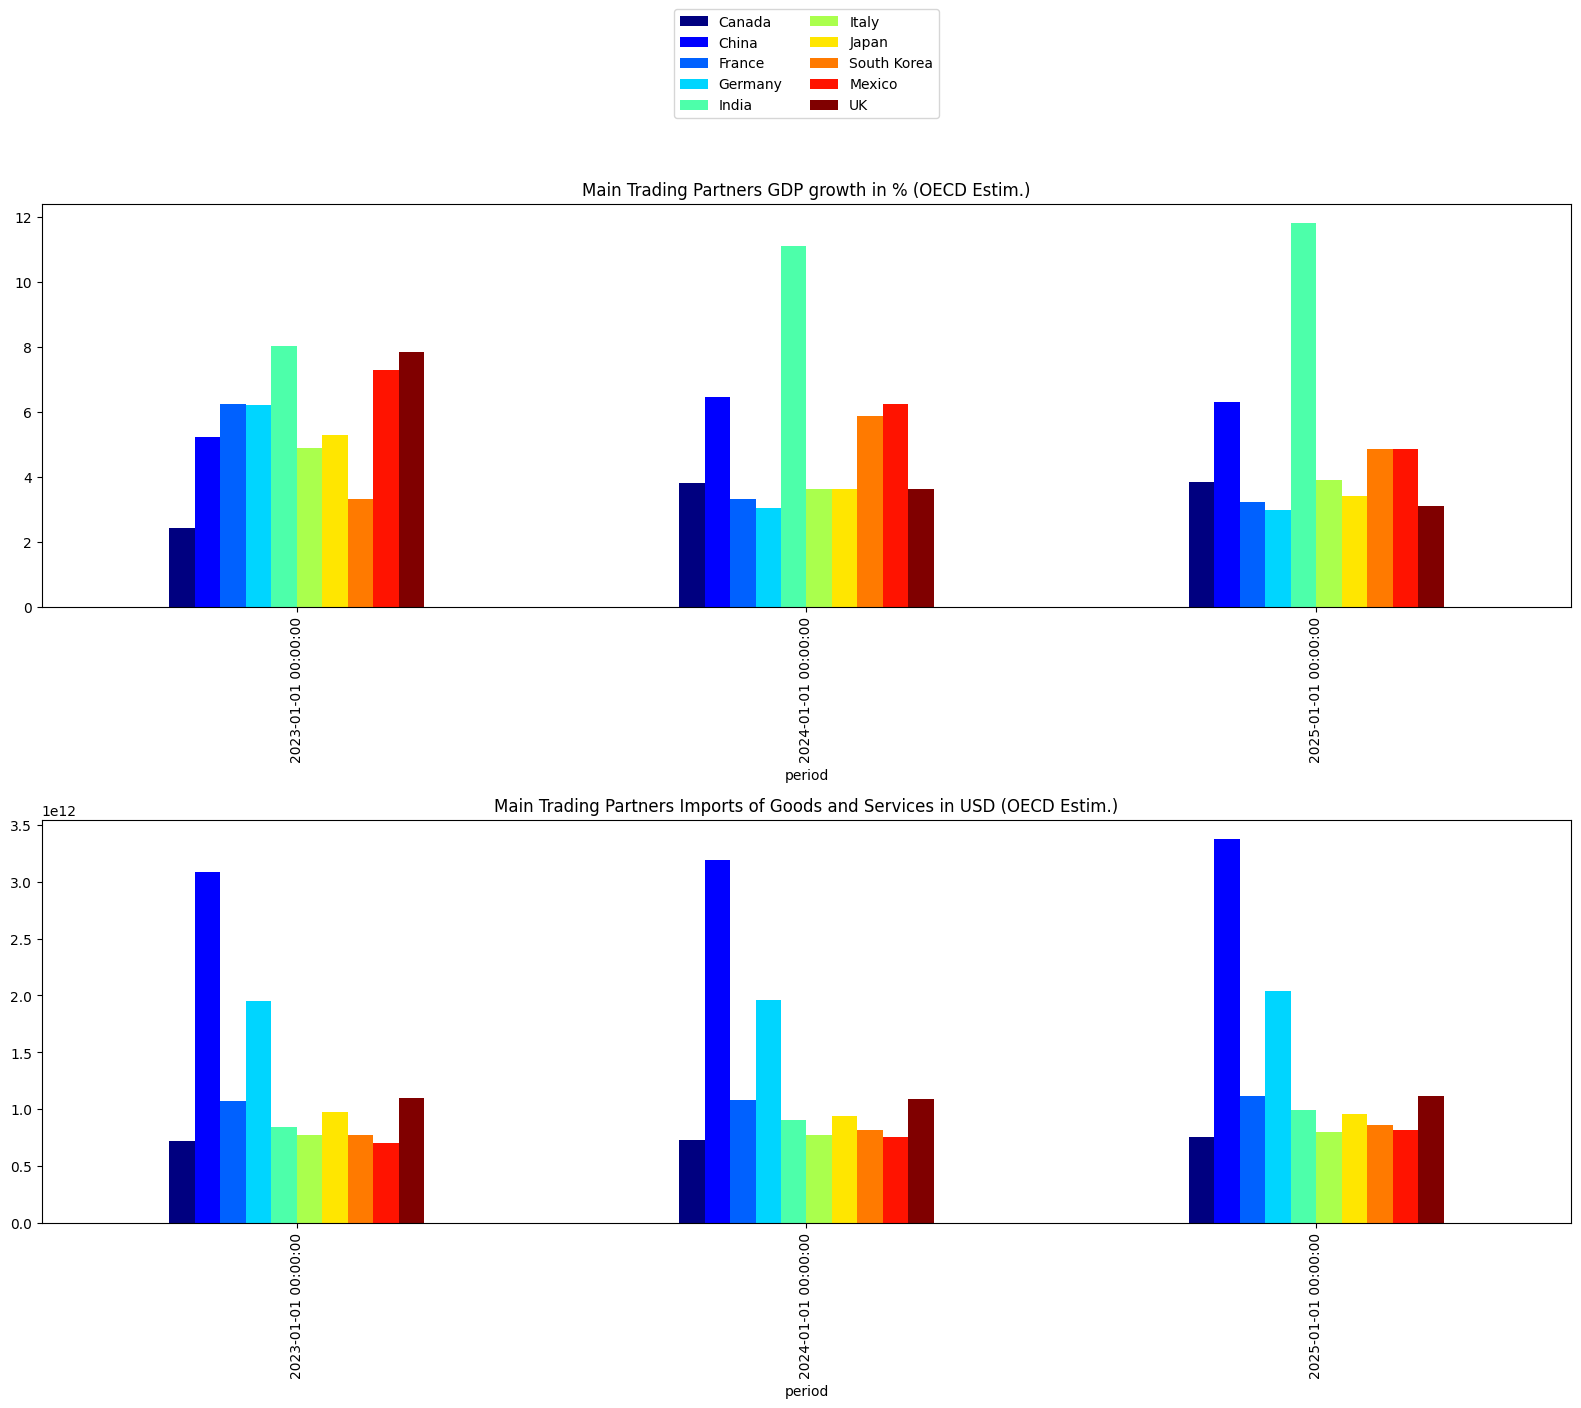

In [ ]:
#Plot trading partners growth and imports forecasts
colors = plt.cm.jet(np.linspace(0, 1, 10))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,13))

ax = trad_part.plot(ax=axes[0], kind='bar', color=colors, stacked=False, legend=True, title='Main Trading Partners GDP growth in % (OECD Estim.)')

ax1 = trad_part_imp.plot(ax=axes[1], kind='bar', color=colors, stacked=False, legend=False, title='Main Trading Partners Imports of Goods and Services in USD (OECD Estim.)')

ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5), ncol=2)

fig.subplots_adjust(bottom=0.6)

fig.tight_layout()

plt.show()

# Section 12: COVID-19 Analysis

In this section we are about to analyze the evolution of Covid-19 and its impact on the economy. Besides cases, deaths and vaccinations statistics, we will also look at mobility trends and the cost of transportation to assess the resiliency of the country to the pandemic.

In [ ]:
#Fetch covid-19 data
cases = fetch_series('JHU/confirmed/USA')
cases = clean_data(cases, 'Confirmed Cases')
cases['3-M Avg.'] = cases['Confirmed Cases'].rolling(90).mean()

deaths = fetch_series('JHU/deaths/USA')
deaths = clean_data(deaths, 'Deaths')
deaths['3-M Avg.'] = deaths['Deaths'].rolling(90).mean()

KeyboardInterrupt: 

NameError: name 'cases' is not defined

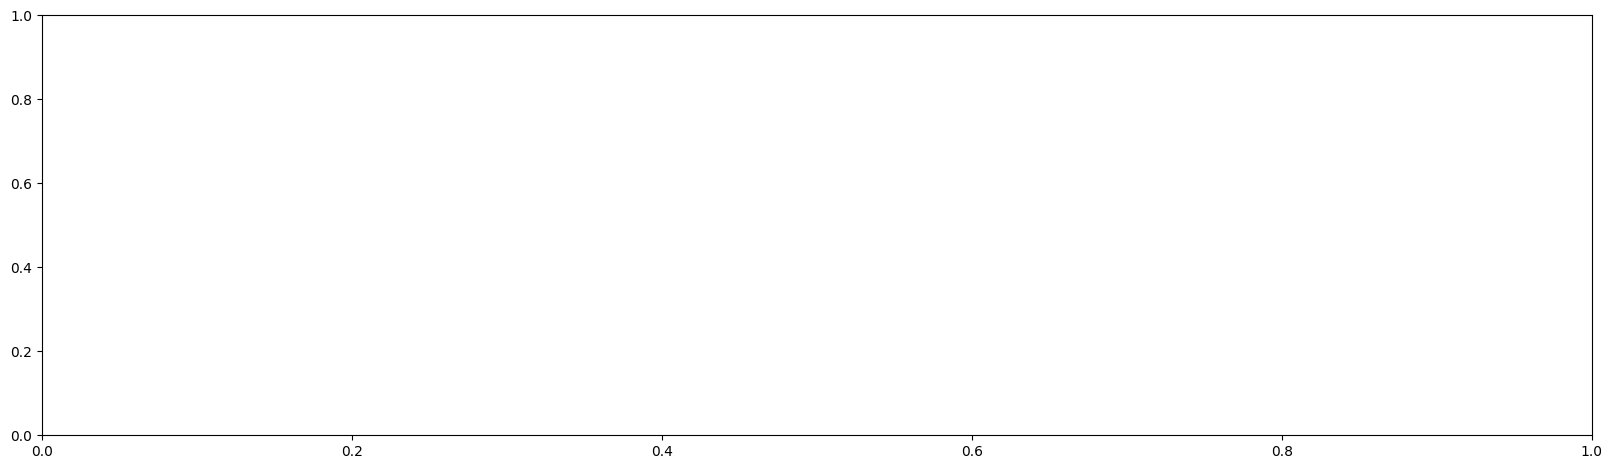

In [ ]:
#Plot covid-19 data
plt.subplots(figsize=(20,12))

plt.subplot(211)
plt.plot(cases['Confirmed Cases'])
plt.plot(cases['3-M Avg.'])
plt.title('Covid Cases (Millions)')
plt.legend(['Cases', '3-M Average'])

plt.subplot(212)
plt.plot(deaths['Deaths'])
plt.plot(deaths['3-M Avg.'])
plt.title('Covid Deaths')
plt.legend(['Deaths', '3-M Average'])

plt.show()

In [ ]:
#Fetch vaccinations data
first_dose = fetch_series('oppins/COV/vaccine_rate.US.VACCINE.CUM.D')
first_dose = clean_data(first_dose, 'First Vaccine Dose Administered')

full_vaccine = fetch_series('oppins/COV/fullvaccine_rate.US.FULLVACCINE.CUM.D')
full_vaccine = clean_data(full_vaccine, 'Vaccine Series Completed')

In [ ]:
#Plot vaccinations data
plt.subplots(figsize=(20,12))

plt.subplot(211)
plt.plot(first_dose)
plt.title('First Vaccine Dose Administered')

plt.subplot(212)
plt.plot(full_vaccine)
plt.axhline(y=70, color='red', linestyle='dotted')
plt.title('Vaccine Series Completed')
plt.legend(['Fully Vaccinated - %Pop.', 'WHO Target'])

plt.show()

In [ ]:
#Fetch Apple Mobility Trend data
driving = fetch_series('Apple/AMT/USA.driving')
driving = clean_data(driving, 'Driving')
driving = driving.fillna(method='ffill')
driving['3-M Avg.'] = driving['Driving'].rolling(90).mean()

transit = fetch_series('Apple/AMT/USA.transit')
transit = clean_data(transit, 'Transit')
transit = transit.fillna(method='ffill')
transit['3-M Avg.'] = transit['Transit'].rolling(90).mean()

walking = fetch_series('Apple/AMT/USA.walking')
walking = clean_data(walking, 'Walking')
walking = walking.fillna(method='ffill')
walking['3-M Avg.'] = walking['Walking'].rolling(90).mean()

Reports are published daily and reflect requests for directions in Apple Maps.

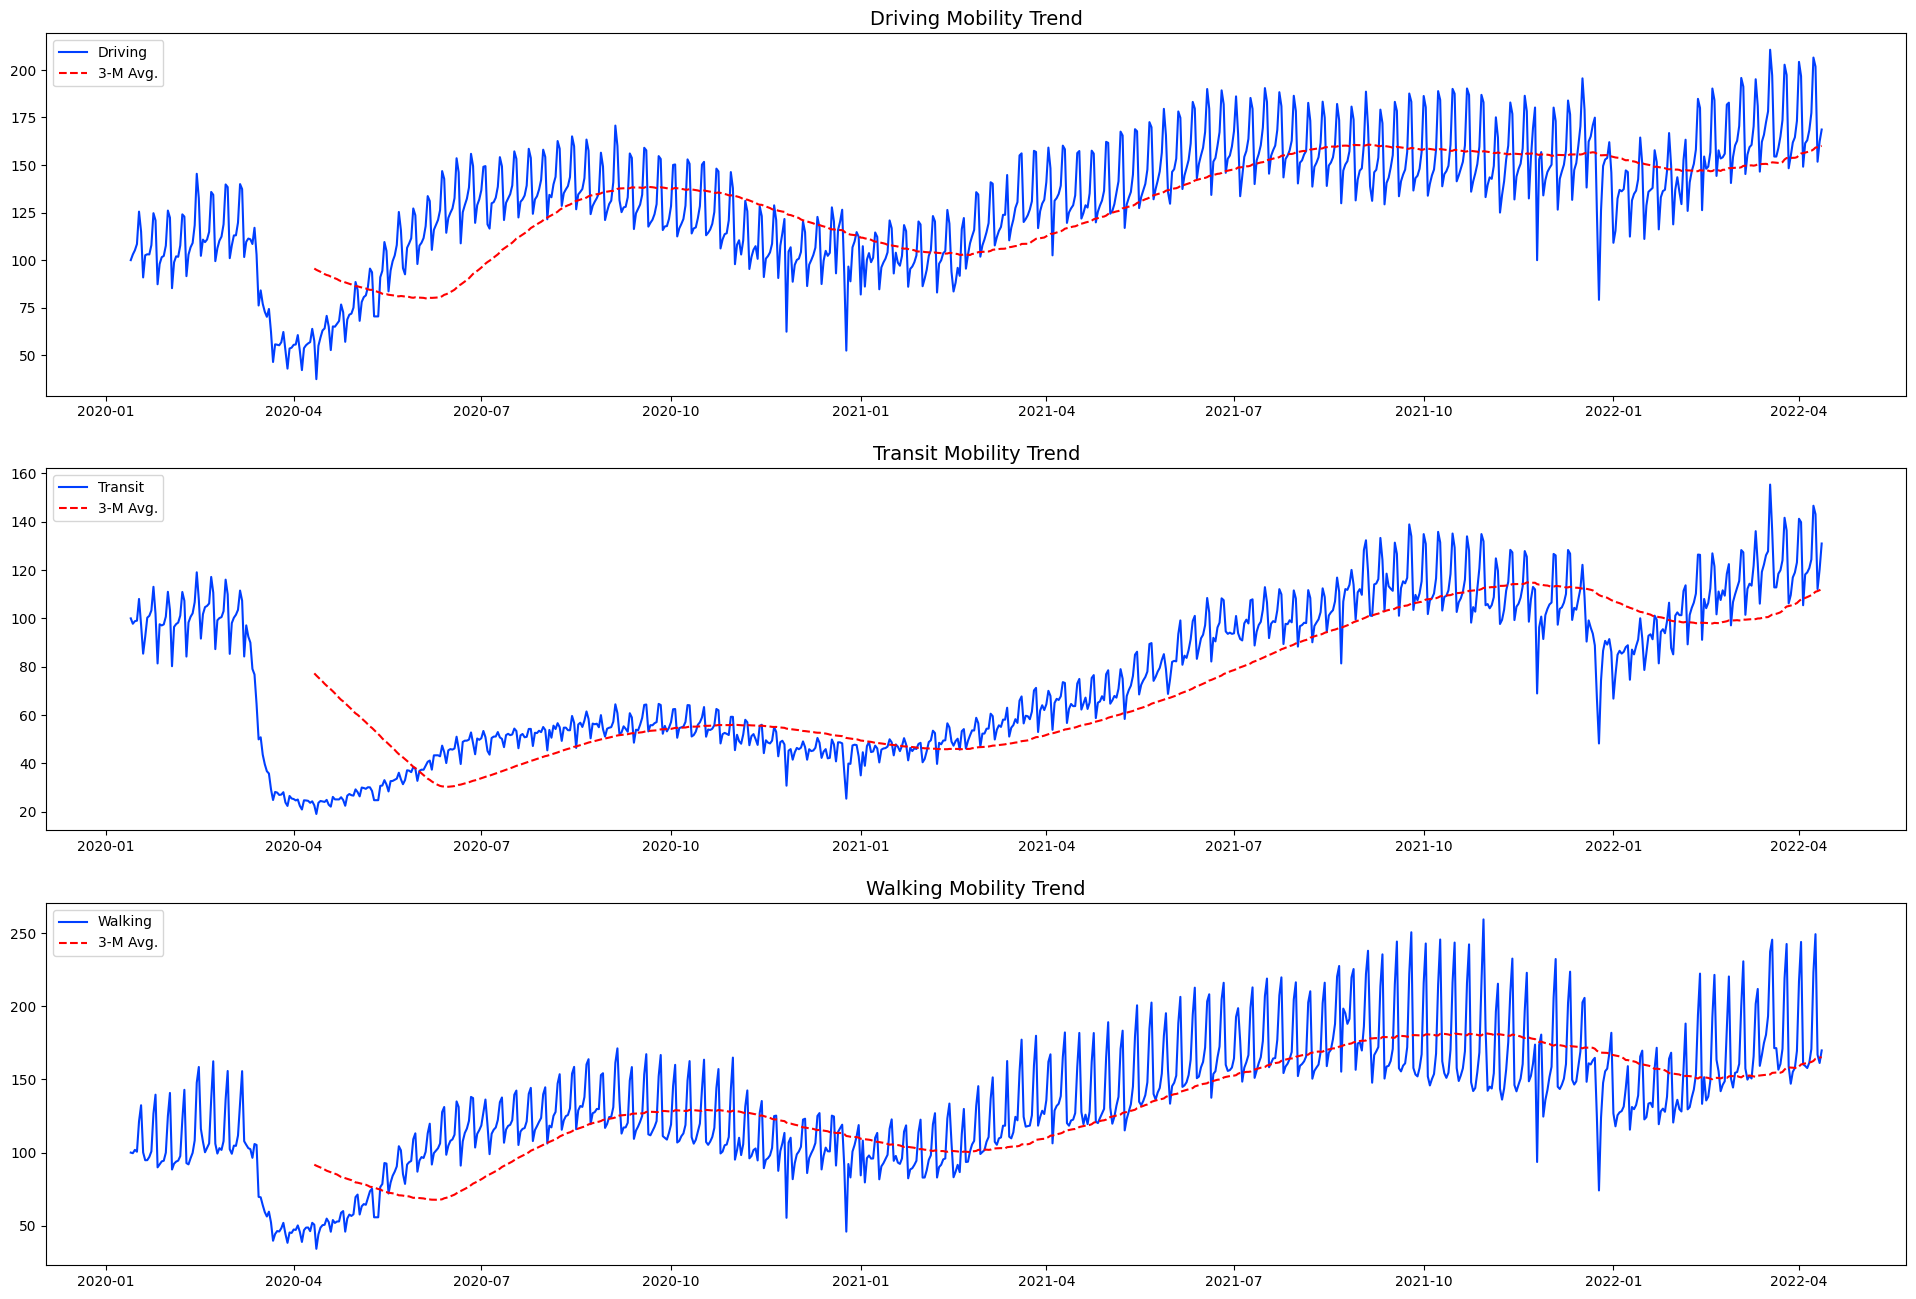

In [ ]:
#Plot Apple Mobility Trend data
plt.subplots(figsize=(24,16))

plt.subplot(311)
plt.plot(driving['Driving'])
plt.plot(driving['3-M Avg.'], linestyle='--', color='r')
plt.legend(['Driving', '3-M Avg.'])
plt.title('Driving Mobility Trend', fontsize=14)

plt.subplot(312)
plt.plot(transit['Transit'])
plt.plot(transit['3-M Avg.'], linestyle='--', color='r')
plt.legend(['Transit', '3-M Avg.'])
plt.title('Transit Mobility Trend', fontsize=14)

plt.subplot(313)
plt.plot(walking['Walking'])
plt.plot(walking['3-M Avg.'], linestyle='--', color='r')
plt.legend(['Walking', '3-M Avg.'])
plt.title('Walking Mobility Trend', fontsize=14)


plt.show()

In [ ]:
#Fetch Google Global Mobility Report data
retail = fetch_series('Google/GMR/US.retrec')
retail = clean_data(retail, 'Retail and Recreation')
retail = retail.fillna(method='ffill')
retail['3-M Avg.'] = retail['Retail and Recreation'].rolling(90).mean()

transit_stations = fetch_series('Google/GMR/US.transit')
transit_stations = clean_data(transit_stations, 'Transit Stations')
transit_stations = transit_stations.fillna(method='ffill')
transit_stations['3-M Avg.'] = transit_stations['Transit Stations'].rolling(90).mean()

work = fetch_series('Google/GMR/US.work')
work = clean_data(work, 'Work')
work = work.fillna(method='ffill')
work['3-M Avg.'] = work['Work'].rolling(90).mean()

These Community Mobility Reports aim to provide insights into what has changed in response to policies aimed at combating COVID-19. The reports chart movement trends over time by geography, across different categories of places such as retail and recreation, groceries and pharmacies, parks, transit stations, workplaces, and residential.

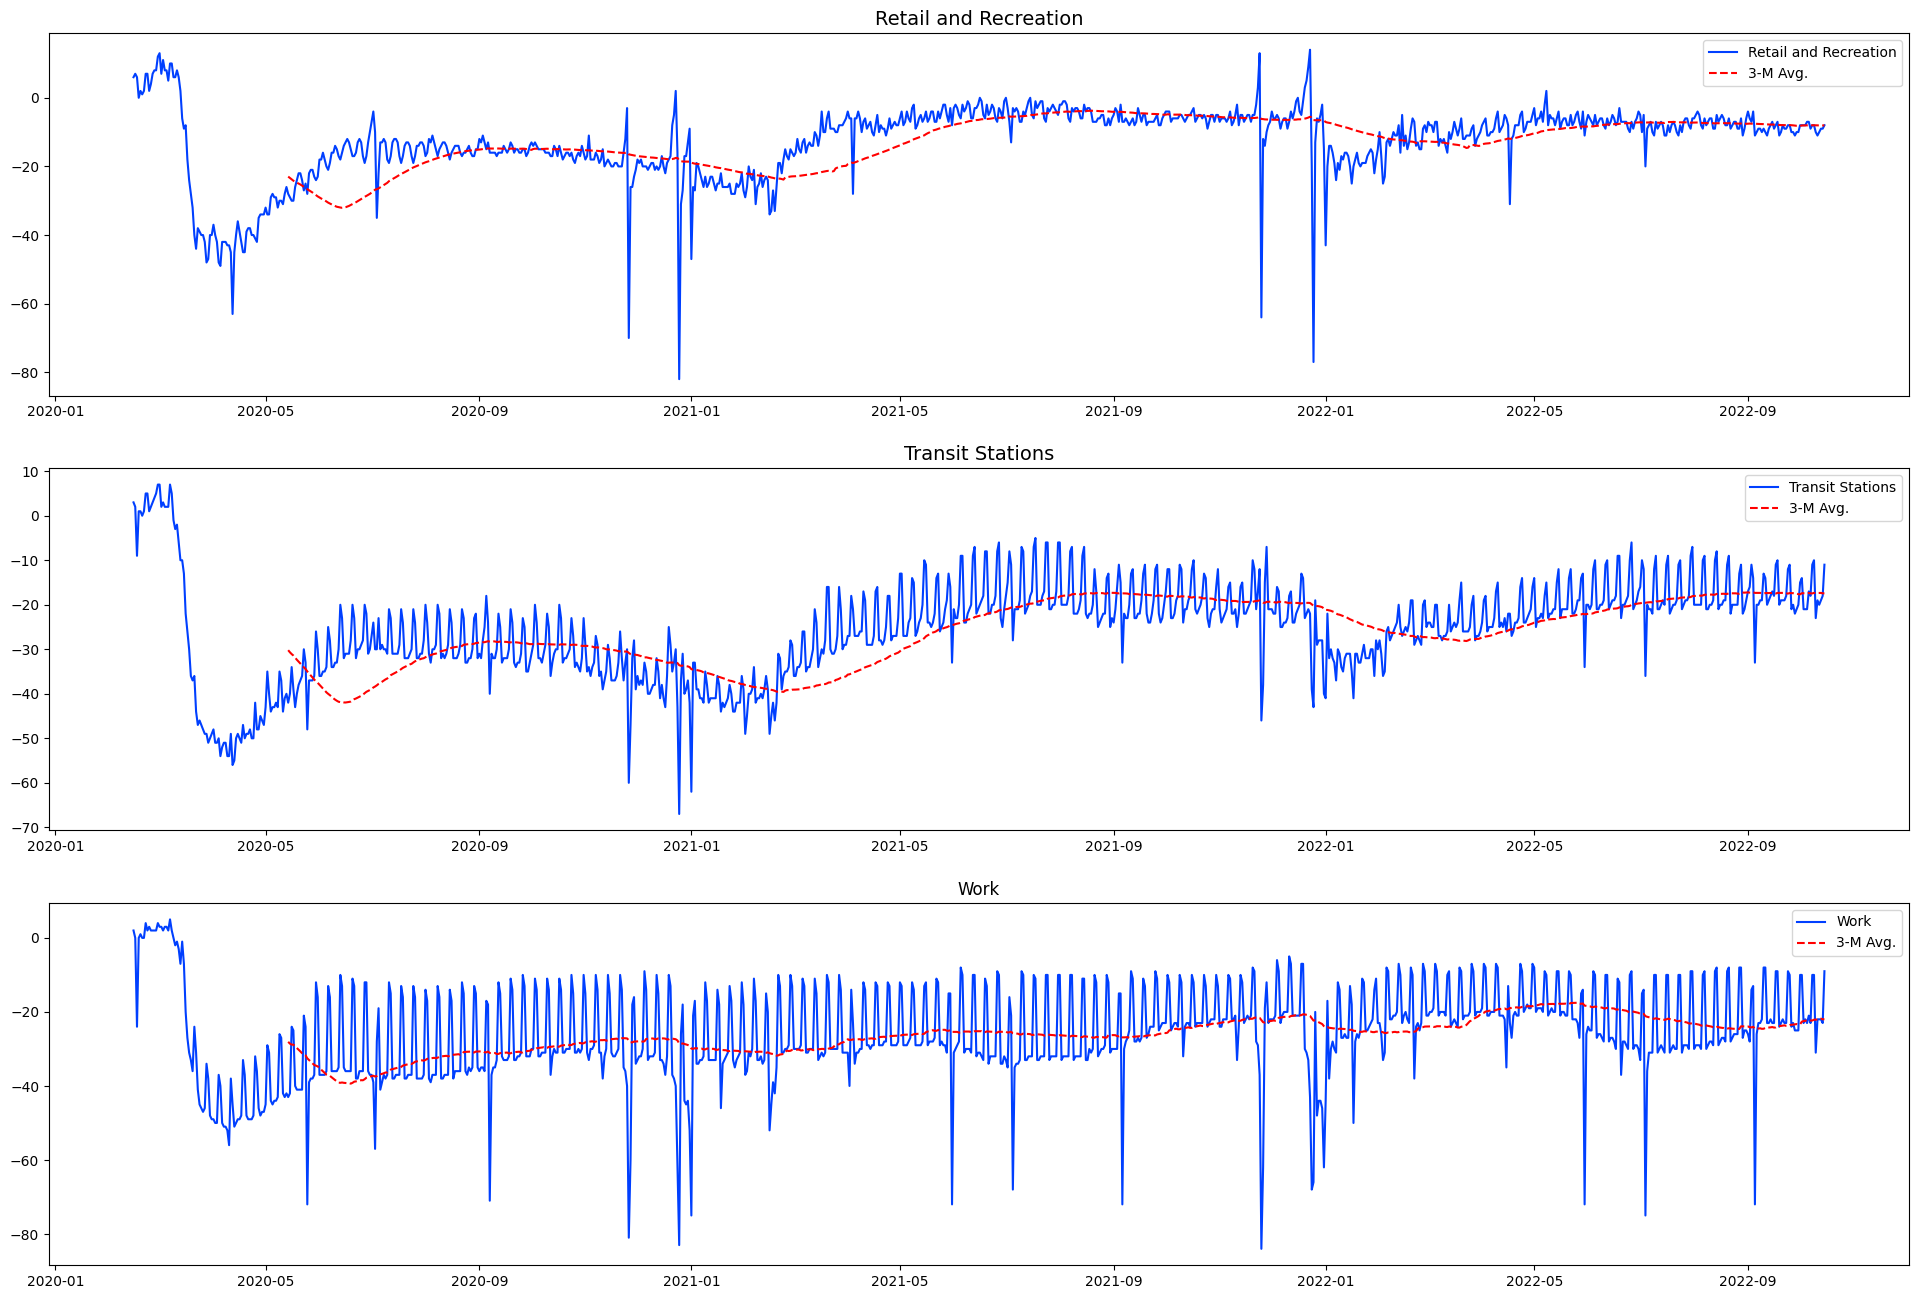

In [ ]:
#Plot Google Mobility Report data
plt.subplots(figsize=(24,16))

plt.subplot(311)
plt.plot(retail['Retail and Recreation'])
plt.plot(retail['3-M Avg.'], color='r', linestyle='--')
plt.legend(['Retail and Recreation', '3-M Avg.'])
plt.title('Retail and Recreation', fontsize=14)

plt.subplot(312)
plt.plot(transit_stations['Transit Stations'])
plt.plot(transit_stations['3-M Avg.'], color='r', linestyle='--')
plt.legend(['Transit Stations', '3-M Avg.'])
plt.title('Transit Stations', fontsize=14)

plt.subplot(313)
plt.plot(work['Work'])
plt.plot(work['3-M Avg.'], color='r', linestyle='--')
plt.legend(['Work', '3-M Avg.'])
plt.title('Work')

plt.show()

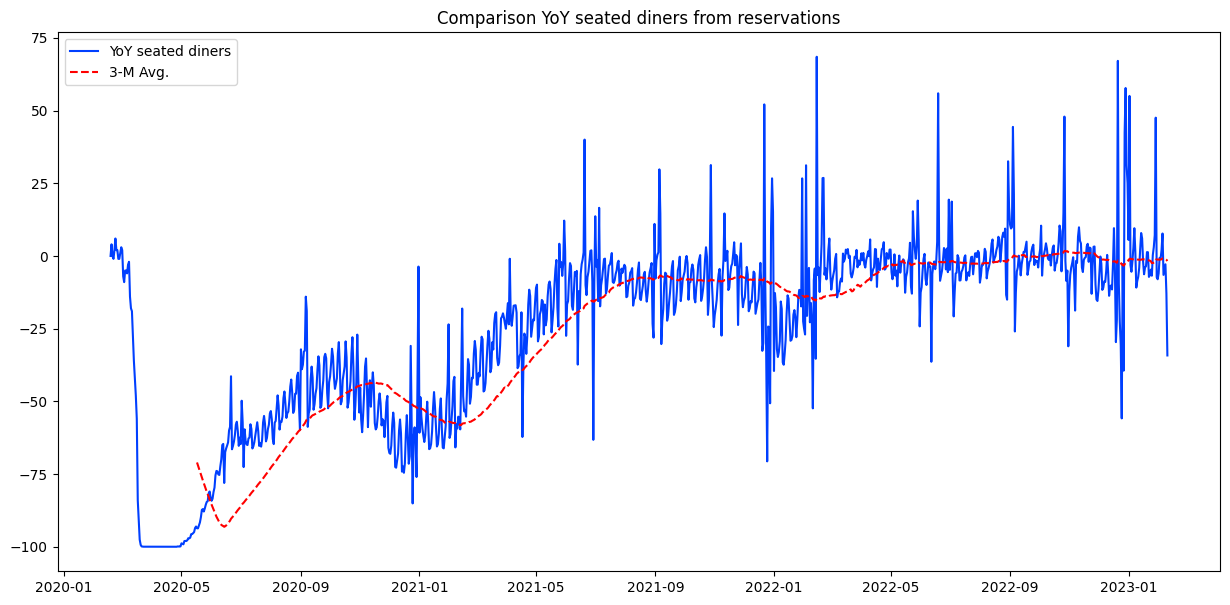

In [ ]:
#Fetch State of Restaurant Industry by OpenTable to assess re-openness of the economy
opentable = fetch_series('OpenTable/SRI/united_states.country.yoy')
opentable = clean_data(opentable, 'Comparison YoY seated diners')

#Plot OpenTable data
plt.figure(figsize=(15,7))
plt.plot(opentable)
plt.plot(opentable.rolling(90).mean(), color='r', linestyle='--')
plt.legend(['YoY seated diners', '3-M Avg.'])
plt.title('Comparison YoY seated diners from reservations')
plt.show()

In [ ]:
#Fetch Airline Ticket Price Index and Gasoline retail price data

airline_ticket = fetch_series('EIA/STEO/ACTKFUS.M')
airline_ticket = clean_data(airline_ticket, 'Airline Ticket Price Index')
airline_ticket = airline_ticket.iloc[-72:]
airline_ticket['12-M Avg.'] = airline_ticket['Airline Ticket Price Index'].rolling(12).mean()

gasoline = fetch_series('EIA/STEO/MGRARUS_$.M')
gasoline = clean_data(gasoline, 'Gasoline - $/gallon')
gasoline = gasoline.iloc[-72:]
gasoline['12-M Avg.'] = gasoline['Gasoline - $/gallon'].rolling(12).mean()

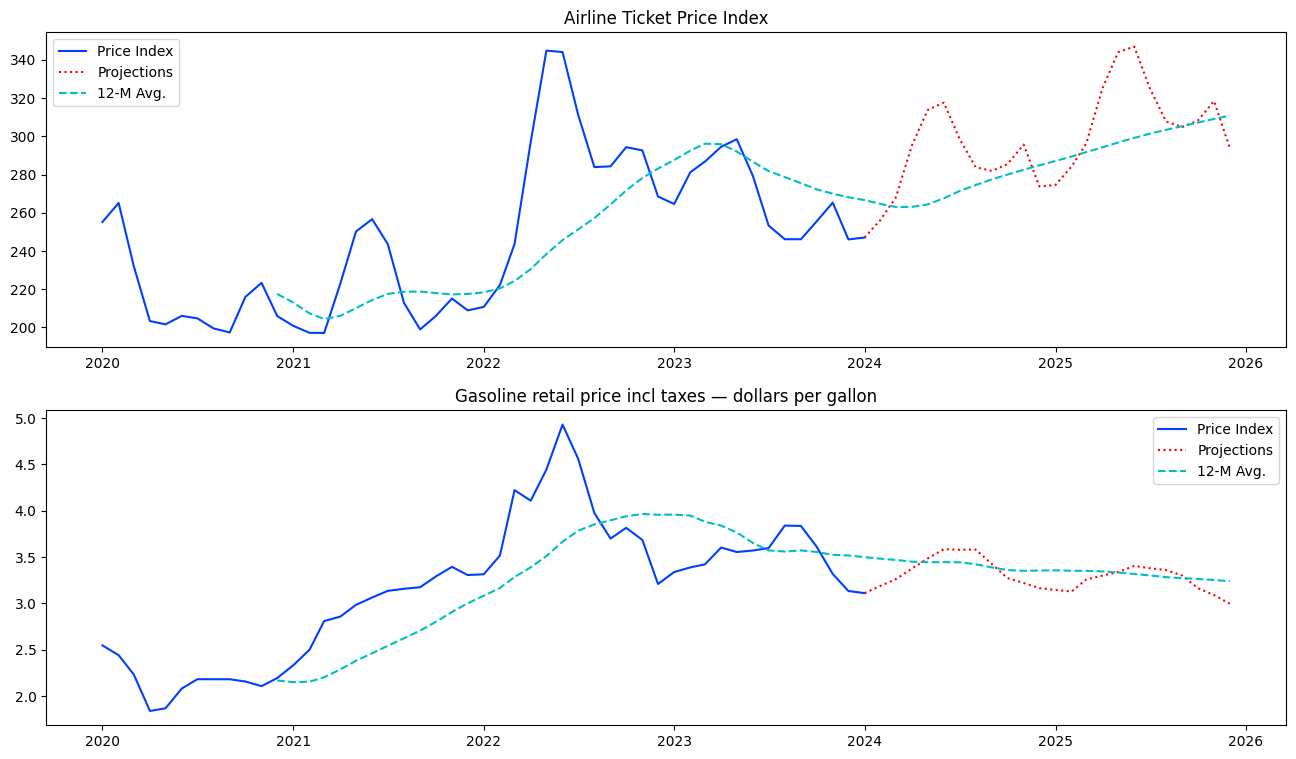

In [ ]:
#Plot Airline Ticket Price Index and Gasoline retail price data
plt.subplots(figsize=(16,9))

plt.subplot(211)
plt.plot(airline_ticket['Airline Ticket Price Index'].loc[:current_month])
plt.plot(airline_ticket['Airline Ticket Price Index'].loc[current_month:], linestyle='dotted', color='r')
plt.plot(airline_ticket['12-M Avg.'], color='c', linestyle='--')
plt.legend(['Price Index', 'Projections', '12-M Avg.'])
plt.title('Airline Ticket Price Index')

plt.subplot(212)
plt.plot(gasoline['Gasoline - $/gallon'].loc[:current_month])
plt.plot(gasoline['Gasoline - $/gallon'].loc[current_month:], linestyle='dotted', color='r')
plt.plot(gasoline['12-M Avg.'], color='c', linestyle='--')
plt.legend(['Price Index', 'Projections', '12-M Avg.'])
plt.title('Gasoline retail price incl taxes — dollars per gallon')

plt.show()

# Section 13: Climate Change Readiness and Vulnerability Analysis

In this section we will analyse the evolution of the readiness and vulnerability to climate change indicators of the country. We will specifically look at the Notre Dame-Global Adaptation Index (ND-GAIN) framework, even if data is available only up to 2019. Therefore, an educated guess has to be taken for the most current period and future expectations.

The Notre Dame-Global Adaptation Index (ND-GAIN) Country Index is a free opensource index that shows a country’s current vulnerability to climate disruptions. It also assesses a country’s readiness to leverage private and public sector investment for adaptive actions. ND-GAIN brings together over 74 variables to form 45 core indicators to measure vulnerability and readiness of 192 UN countries from 1995 to the present. All countries, to different extents, are facing the challenges of adaptation. Due to geographical location or socio-economic condition, some countries are more vulnerable to the impacts of climate change than others. Further, some countries are more ready to take on adaptation actions by leveraging public and private sector investments, through government action, community awareness, and the ability to facilitate private sector responses. ND-GAIN measures both of these dimensions:
vulnerability and readiness.

For more information: https://gain.nd.edu/assets/254377/nd_gain_technical_document_2015.pdf

ND-GAIN’s framework breaks the measure of vulnerability into exposure, sensitivity and adaptive capacity, and the measure of readiness into economic, governance and social components. The construction of the ND-GAIN framework is based on published peer-reviewed material, the IPCC Review process, and feedback from corporate stakeholders, practitioners and development users.

In [ ]:
#Fetch ND-GAIN index data and store them in a DataFrame
nd_gain_list = ['ND_GAIN/gain/A.USA',
                'ND_GAIN/gain/A.AUS',
                'ND_GAIN/gain/A.CAN',
                'ND_GAIN/gain/A.CHN',
                'ND_GAIN/gain/A.DEU',
                'ND_GAIN/gain/A.FRA',
                'ND_GAIN/gain/A.GBR',
                'ND_GAIN/gain/A.ITA',
                'ND_GAIN/gain/A.JPN',
                'ND_GAIN/gain/A.NZL']

nd_gain = pd.DataFrame()

for i in nd_gain_list:
    nd_gain = nd_gain.append(fetch_series(i)[['period', 'series_name', 'value']])

nd_gain = nd_gain.pivot(index='period', columns='series_name', values='value')

nd_gain.tail()

series_name  Annual – Australia  Annual – Canada  Annual – China  \
period                                                             
2017-01-01            69.275628        68.891444       53.545954   
2018-01-01            69.566273        68.428333       53.838262   
2019-01-01            69.508230        68.438006       57.168262   
2020-01-01            68.821372        68.111872       58.125543   
2021-01-01            68.910950        68.088405       58.324542   

series_name  Annual – France  Annual – Germany  Annual – Italy  \
period                                                           
2017-01-01         67.525755         70.449231       58.852674   
2018-01-01         67.390794         70.446968       59.582176   
2019-01-01         68.037946         70.261682       59.730800   
2020-01-01         67.247979         70.084091       59.841612   
2021-01-01         67.489736         70.214865       60.117865   

series_name  Annual – Japan  Annual – New Zealand  Annual – United Kingdom  \
period                                                                       
2017-01-01        65.813980             74.736927                70.726305   
2018-01-01        65.645819             74.415794                70.289189   
2019-01-01        65.609164             70.308285                70.506158   
2020-01-01        65.514940             70.364915                70.129569   
2021-01-01        65.610963             70.327223                70.115767   

series_name  Annual – United States  
period                               
2017-01-01                68.236652  
2018-01-01                68.155901  
2019-01-01                67.478932  
2020-01-01                67.178020  
2021-01-01                67.365535

In [ ]:
#Rename columns of ND-GAIN DataFrame
columns = ['Australia', 'Canada', 'China', 'France', 'Germany', 'Italy', 'Japan', 'New Zealand', 'UK', 'USA']

nd_gain.columns = columns
nd_gain.tail()

In [ ]:
#Plot ND-GAIN data for country comparison
plt.figure(figsize=(16,9))
fig2 = px.line(nd_gain, x=nd_gain.index, y=['Australia', 'Canada', 'China', 'France', 'Germany', 'Italy', 'Japan', 'New Zealand', 'UK', 'USA'], title='ND-GAIN')
fig2.update_xaxes(rangeslider_visible=True)
fig2.show()

<Figure size 1600x900 with 0 Axes>

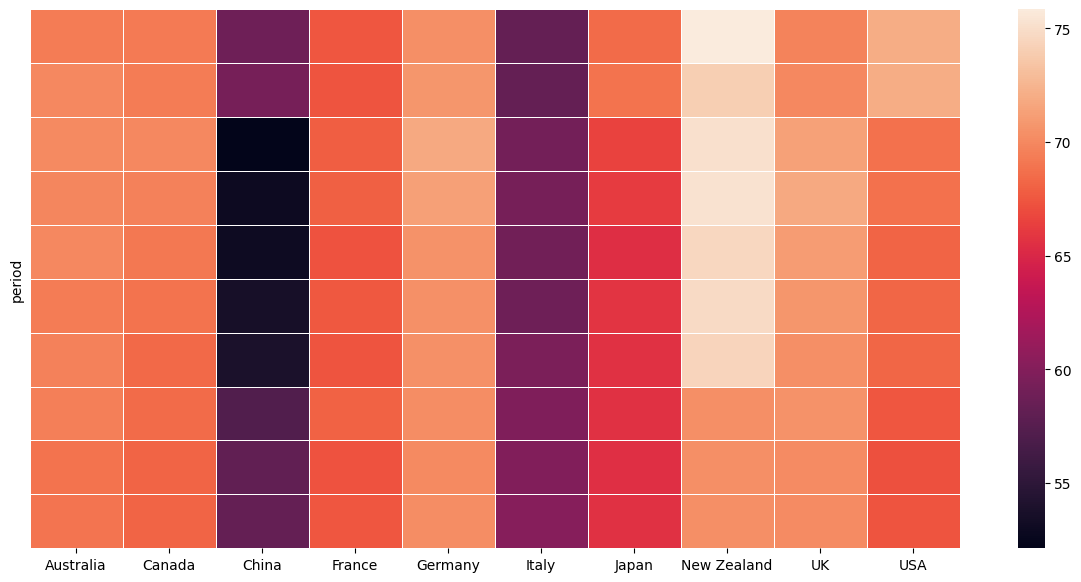

In [ ]:
#Plot a heatmap to better assess the trend in the ND-GAIN index
plt.figure(figsize=(15,7))
ax = sns.heatmap(nd_gain.iloc[-10:], linewidths=.5, yticklabels=False)

In [ ]:
#Fetch ND-GAIN Vulnerability and Readiness data
vulnerability = fetch_series('ND_GAIN/vulnerability/A.USA')
vulnerability = clean_data(vulnerability, 'Vulnerability')

readiness = fetch_series('ND_GAIN/readiness/A.USA')
readiness = clean_data(readiness, 'Readiness')

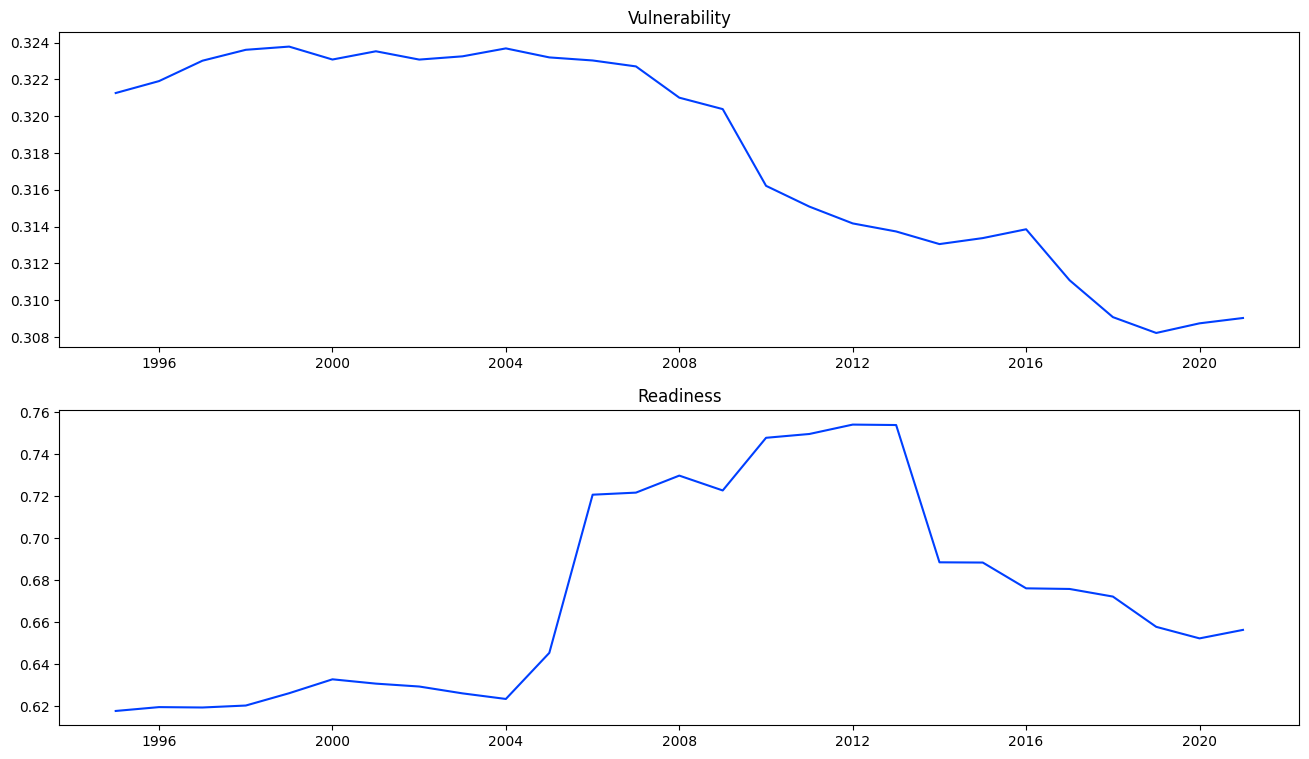

In [ ]:
#Plot ND-GAIN Vulnerability and Readiness data
plt.subplots(figsize=(16,9))

plt.subplot(211)
plt.plot(vulnerability)
plt.title('Vulnerability')

plt.subplot(212)
plt.plot(readiness)
plt.title('Readiness')

plt.show()

Propensity or predisposition of human societies to be negatively impacted by climate hazards.

ND-GAIN assesses the vulnerability of a country by considering six life-supporting sectors: food, water, health, ecosystem services, human habitat and infrastructure. Each sector is in turn represented by six indicators that represent three cross-cutting components: the exposure of the sector to climate-related or climate-exacerbated hazards; the sensitivity of that sector to the impacts of the hazard and the adaptive capacity of the sector to cope or adapt to these impacts.

Exposure: The extent to which human society and its supporting sectors are stressed by the future changing climate conditions. Exposure in ND-GAIN captures the physical factors external to the system that contribute to vulnerability.

Sensitivity: The degree to which people and the sectors they depend upon are affected by climate related perturbations. The factors increasing sensitivity include the degree of dependency on sectors that are climate-sensitive and proportion of populations sensitive to climate hazard due to factors such as topography and demography.

Adaptive capacity: The ability of society and its supporting sectors to adjust to reduce potential damage and to respond to the negative consequences of climate events. In ND-GAIN adaptive capacity indicators seek to capture a collection of means, readily deployable to deal with sector-specific climate change impacts.

In [ ]:
#Fetch data for Vulnerability assessment
exposure = fetch_series('ND_GAIN/eposure/A.USA')
exposure = clean_data(exposure, 'Exposure')

sensitivity = fetch_series('ND_GAIN/sensitivity/A.USA')
sensitivity = clean_data(sensitivity, 'Sensitivity')

adapt_capac = fetch_series('ND_GAIN/capacity/A.USA')
adapt_capac = clean_data(adapt_capac, 'Adaptive Capacity')

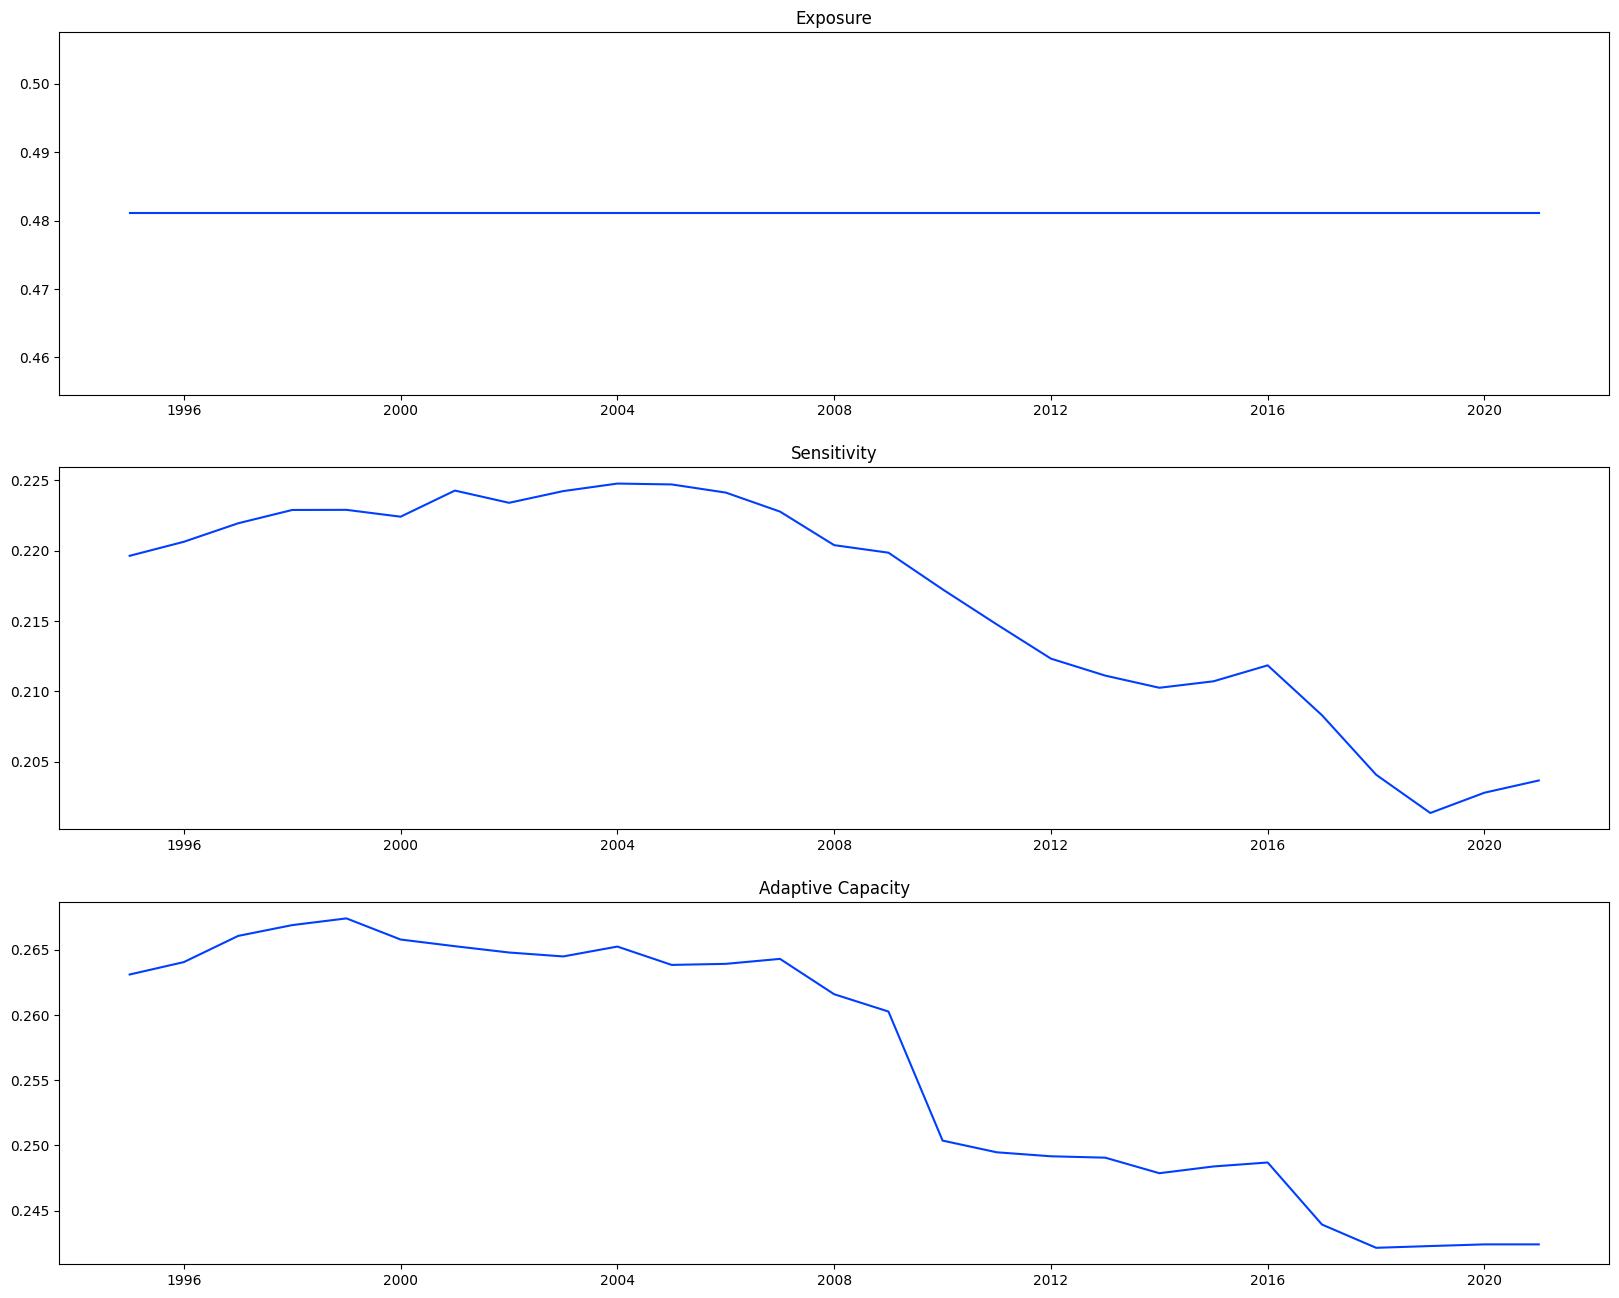

In [ ]:
#Plot data for Vulnerability assessment
plt.subplots(figsize=(20,16))

plt.subplot(311)
plt.plot(exposure)
plt.title('Exposure')

plt.subplot(312)
plt.plot(sensitivity)
plt.title('Sensitivity')

plt.subplot(313)
plt.plot(adapt_capac)
plt.title('Adaptive Capacity')

plt.show()

In [ ]:
#Fetch vulnerability-related data for each sector considered
food = fetch_series('ND_GAIN/food/A.USA')
food = clean_data(food, 'Food')

water = fetch_series('ND_GAIN/water/A.USA')
water = clean_data(water, 'Water')

health = fetch_series('ND_GAIN/health/A.USA')
health = clean_data(health, 'Health')

ecosystem = fetch_series('ND_GAIN/ecosystems/A.USA')
ecosystem = clean_data(ecosystem, 'Ecosystem')

habitat = fetch_series('ND_GAIN/habitat/A.USA')
habitat = clean_data(habitat, 'Habitat')

infrastructure = fetch_series('ND_GAIN/infrastructure/A.USA')
infrastructure = clean_data(infrastructure, 'Infrastructure')

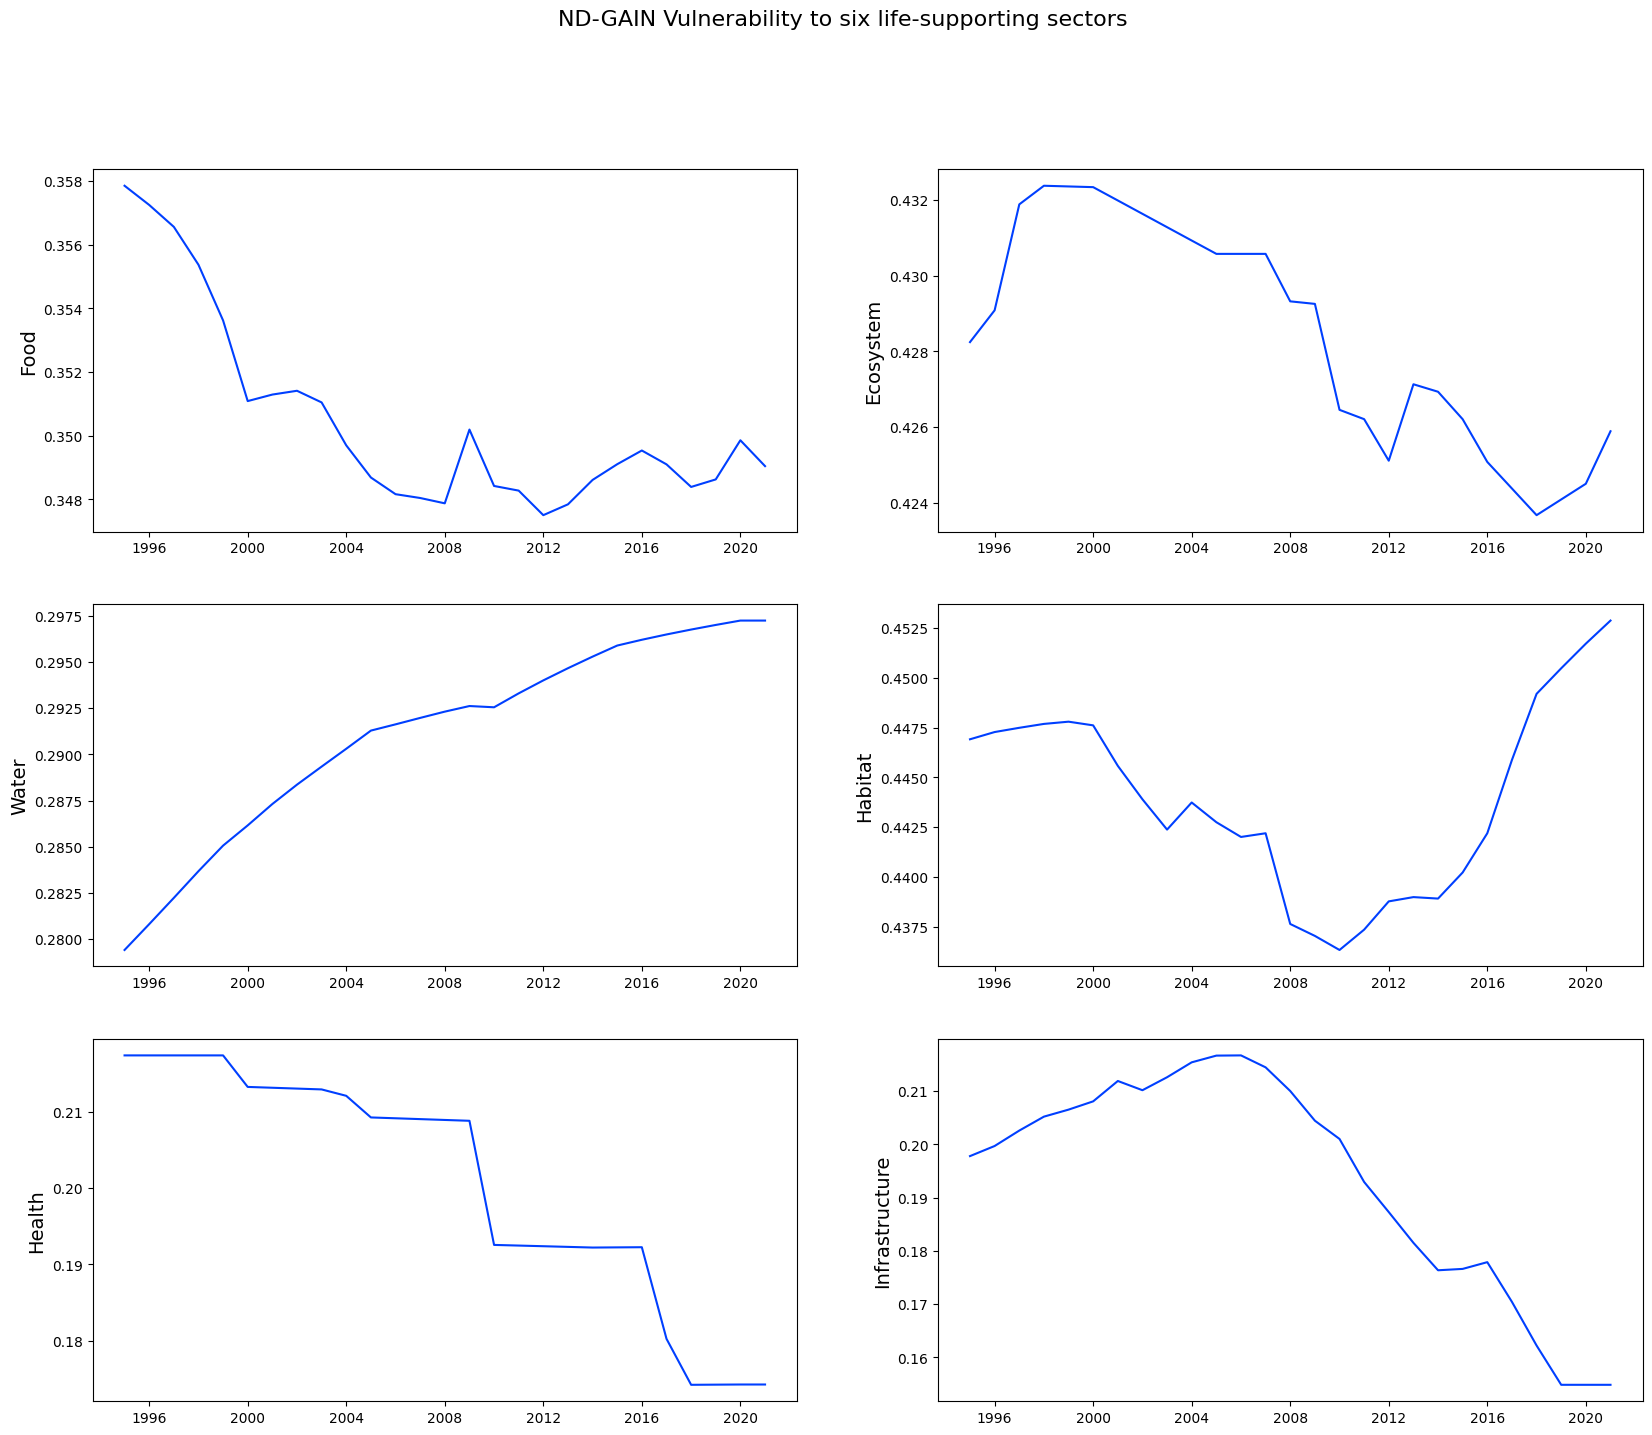

In [ ]:
#Plot vulnerability-related data for each sector considered
fig, axs = plt.subplots(3, 2, figsize=(20, 16))

plt.suptitle('ND-GAIN Vulnerability to six life-supporting sectors', size=16)

axs[0,0].plot(food)
axs[0,0].set_ylabel('Food', fontsize=14)

axs[1,0].plot(water)
axs[1,0].set_ylabel('Water', fontsize=14)

axs[2,0].plot(health)
axs[2,0].set_ylabel('Health', fontsize=14)

axs[0,1].plot(ecosystem)
axs[0,1].set_ylabel('Ecosystem', fontsize=14)

axs[1,1].plot(habitat)
axs[1,1].set_ylabel('Habitat', fontsize=14)

axs[2,1].plot(infrastructure)
axs[2,1].set_ylabel('Infrastructure', fontsize=14)

plt.show()

Readiness to make effective use of investments for adaptation actions thanks to a safe and efficient business environment ND-GAIN measures readiness by considering a country’s ability to leverage investments to adaptation actions.

ND-GAIN measures overall readiness by considering three components: economic readiness, governance readiness and social readiness.

Economic Readiness: The investment climate that facilitates mobilizing capitals from private sector.

Governance Readiness: The stability of the society and institutional arrangements that contribute to the investment risks. A stable country with high governance capacity reassures investors that the invested capitals could grow under the help of responsive public services and without significant interruption.

Social readiness: Social conditions that help society to make efficient and equitable use of investment and yield more benefit from the investment

In [ ]:
#Fetch data for Readiness assessment
economic = fetch_series('ND_GAIN/economic/A.USA')
economic = clean_data(economic, 'Economic')

governance = fetch_series('ND_GAIN/governance/A.USA')
governance = clean_data(governance, 'Governance')

social = fetch_series('ND_GAIN/social/A.USA')
social = clean_data(social, 'Social')

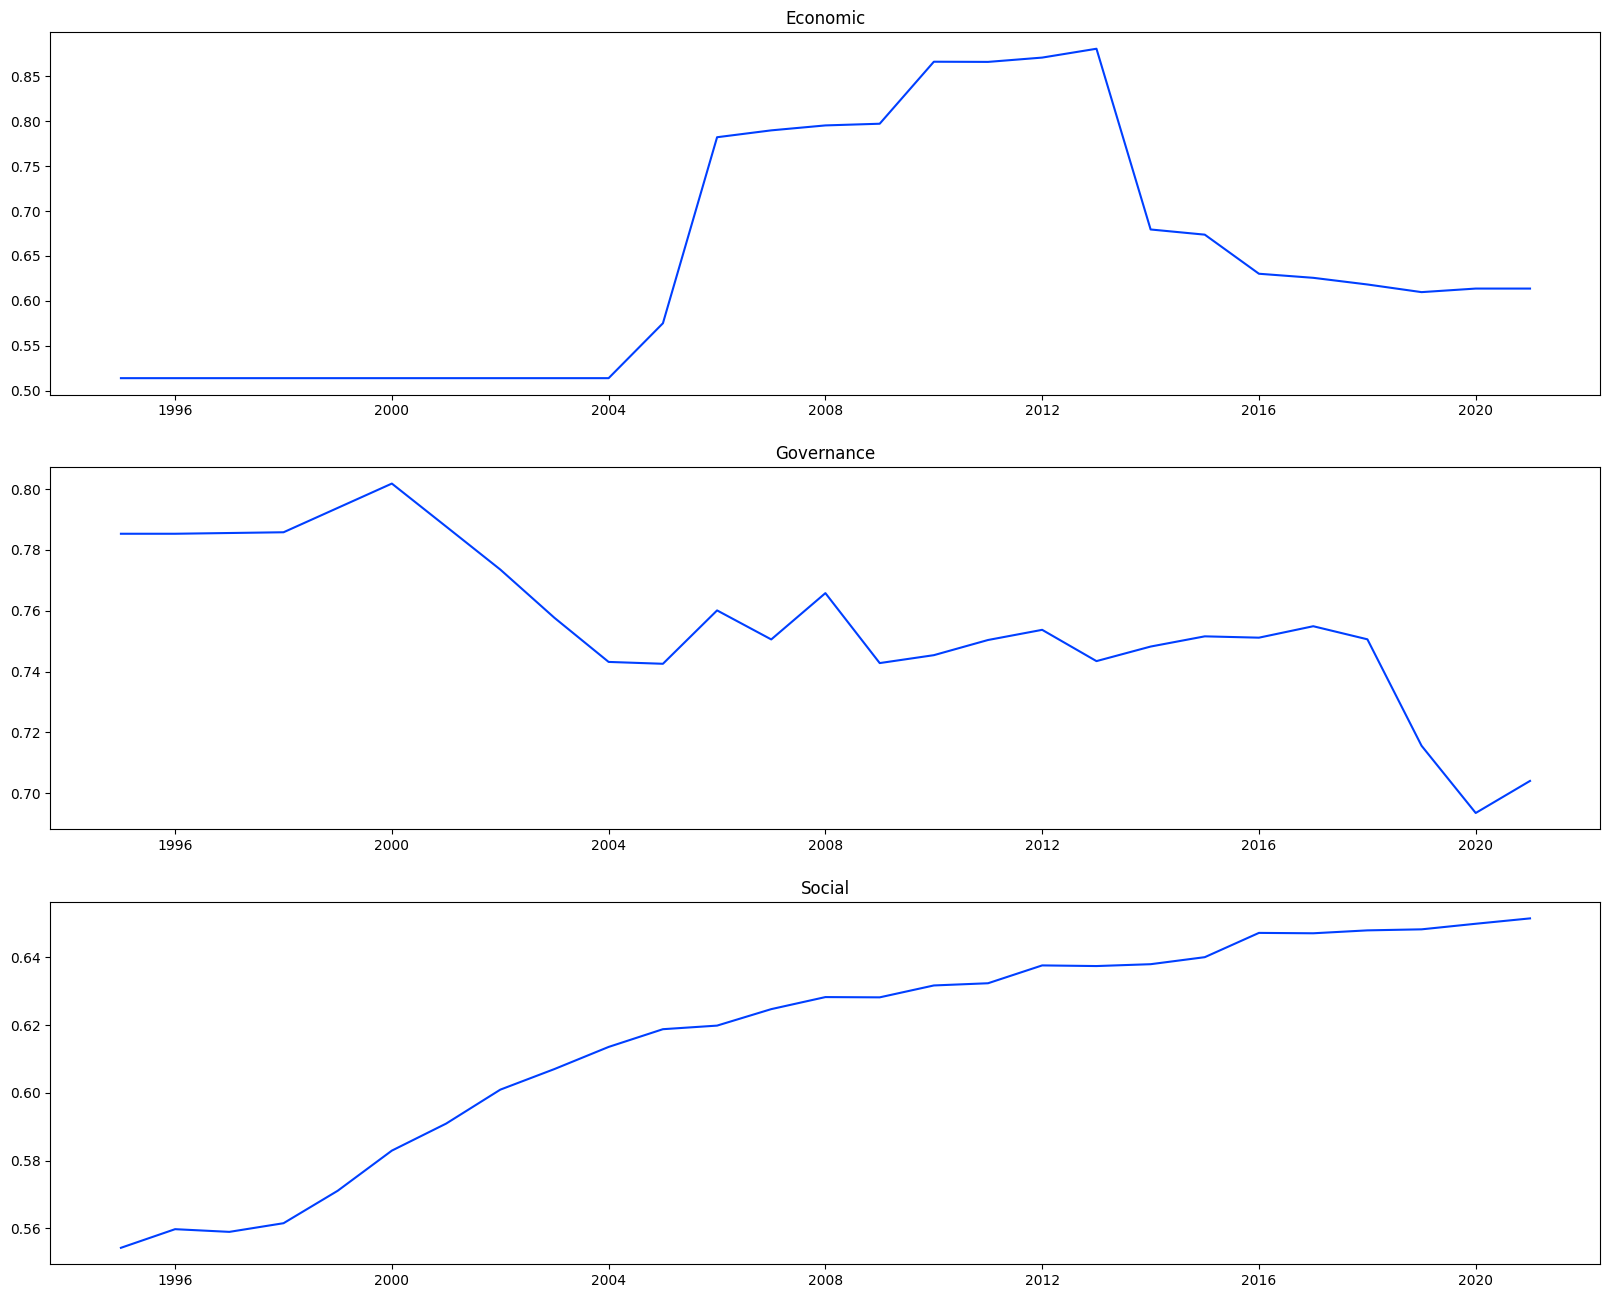

In [ ]:
#Plot data for Readiness assessment
plt.subplots(figsize=(20,16))

plt.subplot(311)
plt.plot(economic)
plt.title('Economic')

plt.subplot(312)
plt.plot(governance)
plt.title('Governance')

plt.subplot(313)
plt.plot(social)
plt.title('Social')

plt.show()

# Section 14: Risk Assessment Matrix

|Nature of risk | Source of Risk |Most Direct Indicators | Likelihood of Severe Impact |
|:- | :- |:-| :-|
|Domestic | Growth | TFP, Labour, Capital, Agg. Demand, Covid-19 Stats. | Medium |
|External | Growth | Trading Partners Analysis| High |
|Domestic | Monetary / Inflation | Output Gap, Inflation Expectations, RMCI | High |
|Domestic | Fiscal | Fiscal Stance and Impulse, Fiscal Sustainability| Medium |
|Domestic |Financial Sector | FSI | Low |
|External |External Trade | External Sector Indicators | Medium |
|External |External Financial | EBA | Low|
|Global | Climate Change | ND-GAIN | Medium |

### Final comment

From the Risk Assessment Matrix we can claim that the overall country risk for the USA is "medium". The growth analysis seems to indicate that prospects are positive, with a strong growth path in 2021 followed by a slowdown in 2022, despite keeping on a positive trajectory. Demand remains strong, with services that are rebounding compared to last year as economy re-opening kicked-in (evidenced by mobility data too). The main threat seems to come from inflationary pressures, with an output gap that is becoming positive, as the economy heats up. Despite policymakers claiming that inflationary pressures will fade in the following months, we have to be careful of the trajectory on which salaries and commodity prices are positioned. On the fiscal side, the stimulus provided from the Government to boost households consumption and support businesses after the pandemic is accelerating an upward spiral, which can be difficult to sustain in the long-run, unless the country proves to grow faster than the cost of its debt. Low risks seem to come from the financial sector where each indicator is well below critical thresholds. At the moment, it doesn't seem that external risks may poise particular threats, but current supply-chain bottlenecks may endanger growth in the coming months. Climate change remains a risk to consider as evidenced by the recent damages the country has suffered, so it has to invest more to make its adaptation to climate impacts more effective.

In [1]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00


In [ ]:
!streamlit hello




  Welcome to Streamlit. Check out our demo in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.221.156.154:8501

  Ready to create your own Python apps super quickly?
  Head over to https://docs.streamlit.io

  May you create awesome apps!


